# A basic example of how to fit a light curve
To generate a lightcurve for a set of binary parameters, ellc is used 

To install:
pip install ellc --user

Other python packages needed to run this whole notebook:
scipy: pip install scipy
emcee: pip install emcee
corner: pip install corner


In [97]:
import numpy as np
import ellc
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

In [98]:
# two spherical stars
def basic_model(t,pars,grid='default'):
    """ a function which returns model values at times t for parameters pars
    
    input:
        t    a 1D array with times
        pars a 1D array with parameter values; r1,r2,J,i,t0,p
        
    output:
        m    a 1D array with model values at times t
    
    """
    try:
        m = ellc.lc(t_obs=t,
                radius_1=pars[0],
                radius_2=pars[1],
                sbratio=pars[2],
                incl=pars[3],
                t_zero=pars[4],
                period=pars[5],
                shape_1='sphere',
                shape_2='sphere',
                grid_1=grid,
                grid_2=grid)
        m *= pars[6]

    except:
        print "Failed with parameters:", pars
        return t * 10**99

    return m

In [99]:
# Parameters used to generate a test lightcurve
r1 = 0.11234
r2 = 0.051243
J = 0.22321
i = 88.7438
t0 = 0.0432
p = 0.18563
scale = 1.231

In [100]:
# generate the test light curve given parameters
model_pars = [r1,r2,J,i,t0,p,scale] # the parameters
t = np.arange(0,6./24.,1./60./24) # a lightcurve with a 1 minute sampling for 6 hours
dy = 0.01 * scale # uncertainty on the points

# and add errors
y = basic_model(t,model_pars)
y += dy*np.random.randn(np.size(t))
lc = np.c_[t,y,dy*np.ones_like(y)]

# save the test lc to disk
np.savetxt('test.lc',lc)

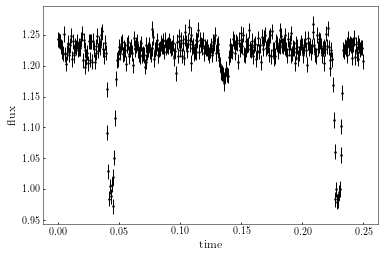

In [101]:
# lets have a look:
plt.errorbar(lc[:,0],lc[:,1],lc[:,2],fmt='k.')
plt.ylabel('flux')
plt.xlabel('time')
plt.show()


# HOW TO FIND THE SYSTEM PARAMETERS FOR THIS LC?

Given a lightcure, what are the underlying parameters? 
This process can be divided in three steps:
- find the global solution
- find the optimal solution
- find the uncertainty on the best solution


## The global solution
This step requires some intuition about eclipsing lightcurve binary stars (a neural net might be usefull here). Read up on the geometry of binary stars before trying to tackle lightcurves in real life.

The most important parameter you want to determine first is the period (*P*). This can be done by using some kind of period finding algorithm in the case of long baseline data or in this case simply by eyeballing the data. 

The second parameter is t0; which is usually lowest point in the LC.

After this it gets more tricky: you need to adjust the values for *r1*,*r2* and *J* (keep *i* at 90 and set the scale to the median of the lc).

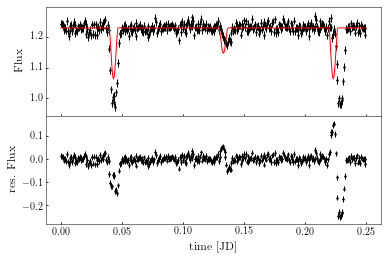

In [102]:
# my initial guess (r1,r2,J,i,t0,p,scale)
guess = np.array([0.1,0.05,0.5,85.,0.043,0.18,np.median(y)])
plot(guess,lc,basic_model)

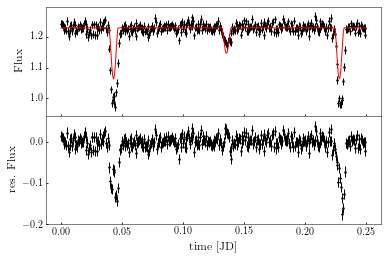

In [103]:
# update the guess: the period estimate seems to be slightly wrong
# my initial guess (r1,r2,J,i,t0,p,scale)
guess = np.array([0.1,0.05,0.5,85.,0.043,0.185,np.median(y)])
plot(guess,lc,basic_model)

## The optimal solution
While the lightcurve model is cleary not correct, but it is close enough to be able to use a minimizer. When you have reached this point is difficult to say, but atleast make sure the period and t0 are correct. The depth of the eclipses is less important.

To be able to use a minimizer we need to define a 'goodness-of-fit' score; the lnp function.
For background, read "Data analysis recipes: Fitting a model to data" https://arxiv.org/abs/1008.4686 or 
"Data Analysis: A Bayesian Tutorial" by Sivia

In [104]:
# we need to compare the data with the model. This function calculates the lnp value
def lnp(pars,data,model,grid='very_sparse',verbose=1):
    """A function which takes as input the parameters, the lightcurve data, and 
    the modelfunction and return the lnp value"""
    
    # first, check the parameters
    if pars[3] > 90: # i cannot be more than 90
        return -np.inf

    m = model(data[:,0],pars,grid) # calculate the model values
    chi2 = np.sum( ((data[:,1]-m)/data[:,2])**2 ) # calculate the chi-square value
    lnp = -0.5*chi2 # lnp=-0.5*chi2 

    if verbose:
        print('%d/%.1f' %(np.size(t),chi2))
    return lnp


In [105]:
# now we have a way to compare data with a model, lets find the best model
from scipy.optimize import minimize

# optimizers work better if you give them the typical scalefactor of each parameter
guess_scale = np.array([-2.,-2.,-2.,0.,-2.,-2.,-2.],dtype=float)


In [106]:
# because scipy has minimizers, we convert lnp to chi2
chi2 = lambda *args: -2*lnp(*args)

# find the optimal solution using nelder-mead
out = minimize(
            fun=chi2, # function to minimize
            x0=guess, # initial value
            args=(lc,basic_model,'very_sparse',False), # the arguments for 'fun'
            method='nelder-mead', # method
            options={'maxiter': 1000, # method options
                     'fatol': 0.1, # if improvement is <fatol, stop
                     'initial_simplex':make_initial_simplex(guess,guess_scale)})
print("N/Chi2: %d/%.1f" %(np.size(lc[:,0]),out.fun))

N/Chi2: 360/367.4


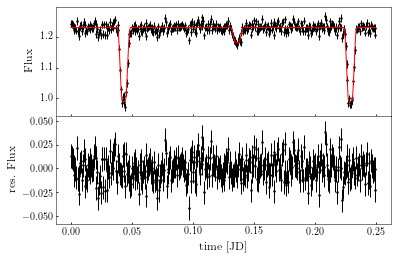

In [107]:
# lets check what the minimizer found as best solution
plot(out.x,lc,basic_model)

## the uncertainties
with a good enough solution (no significant trends in the residual) 
we can try to get the uncertainties on the parameter estimates. The go-to method is emcee, a paralel Markov Chain Monte Carlo sampler. I strongly recommend to have a look at the tutorial here: http://dfm.io/emcee/current/

In [108]:
import emcee

# emcee setup
ndim, nwalkers = np.size(guess), 256
sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                lnp, 
                                args=(lc,basic_model,'very_sparse'),
                                threads=7)

# set start position for all walkers
pos = [out.x + 10**(guess_scale-2)*np.random.randn(ndim) for i in range(nwalkers)]



360/397.6
360/382.4
360/371.6
360/370.4
360/367.6
360/374.6
360/385.0
360/367.7
360/377.5
360/382.3
360/405.9
360/369.3
360/370.6
360/391.0
360/388.3
360/400.0
360/373.4
360/373.0
360/387.8
360/375.3
360/368.0
360/376.9
360/439.0
360/372.4
360/378.0
360/375.6
360/375.6
360/370.5
360/412.4
360/367.6
360/369.7
360/372.4
360/370.2
360/383.1
360/395.1
360/372.1
360/372.2
360/393.6
360/368.4
360/369.3
360/377.9
360/380.4
360/368.3
360/370.1
360/380.5
360/381.6
360/369.9
360/371.5
360/391.9
360/383.8
360/367.6
360/370.8
360/409.0
360/402.6
360/382.6
360/381.8
360/369.3
360/382.3
360/371.7
360/394.7
360/367.9
360/368.4
360/373.2
360/421.3
360/375.8
360/369.0
360/373.1
360/367.8
360/367.7
360/378.6
360/425.3
360/370.1
360/369.0
360/387.9
360/399.4
360/375.0
360/384.9
360/369.1
360/381.3
360/368.8
360/369.9
360/372.6
360/368.2
360/377.5
360/369.4
360/381.8
360/376.4
360/374.7
360/368.4
360/370.3
360/369.8
360/393.0
360/415.7
360/367.6
360/367.5
360/385.2
360/386.7
360/368.2
360/372.1
360/371.7


360/386.6
360/396.2
360/389.5
360/374.6
360/367.6
360/379.4
360/440.1
360/420.7
360/380.7
360/371.5
360/375.4
360/369.8
360/369.8
360/404.2
360/369.1
360/370.8
360/370.1
360/372.0
360/394.6
360/372.9
360/369.1
360/443.8
360/368.0
360/385.7
360/369.3
360/401.6
360/381.2
360/369.5
360/377.1
360/423.4
360/371.8
360/370.0
360/370.3
360/380.2
360/369.7
360/390.4
360/428.1
360/368.6
360/403.5
360/379.4
360/397.7
360/385.6
360/371.8
360/391.1
360/407.0
360/373.5
360/372.1
360/479.6
360/368.5
360/397.3
360/372.8
360/370.0
360/422.2
360/384.1
360/378.8
360/373.2
360/372.6
360/374.0
360/407.9
360/369.5
360/377.8
360/435.6
360/433.6
360/429.5
360/371.7
360/397.2
360/506.1
360/434.8
360/390.0
360/367.7
360/423.4
360/377.4
360/369.3
360/381.5
360/367.6
360/371.0
360/412.3
360/368.3
360/423.2
360/379.9
360/372.2
360/367.7
360/376.4
360/383.5
360/388.1
360/371.9
360/368.0
360/378.3
360/373.8
360/387.7
360/368.8
360/374.5
360/368.6
360/374.8
360/394.3
360/374.6
360/376.3
360/369.5
360/389.2
360/371.5


360/368.2
360/368.7
360/368.4
360/384.1
360/372.0
360/391.5
360/404.0
360/375.4
360/377.1
360/409.4
360/368.3
360/368.4
360/372.5
360/406.0
360/368.1
360/369.7
360/402.0
360/373.3
360/367.7
360/422.9
360/390.5
360/370.5
360/376.7
360/369.4
360/370.4
360/402.3
360/401.2
360/369.2
360/377.7
360/395.1
360/368.6
360/375.0
360/387.3
360/370.3
360/400.1
360/369.6
360/381.4
360/371.2
360/376.1
360/368.0
360/370.9
360/372.1
360/368.1
360/371.1
360/373.5
360/373.3
360/368.9
360/372.3
360/376.2
360/368.2
360/402.4
360/391.4
360/368.5
360/368.0
360/403.2
360/373.6
360/377.3
360/373.3
360/377.5
360/368.0
360/378.7
360/369.9
360/374.2
360/367.9
360/370.6
360/372.6
360/396.9
360/379.7
360/372.6
360/378.4
360/379.7
360/373.3
360/370.5
360/382.7
360/386.1
360/369.4
360/370.0
360/372.6
360/391.2
360/380.1
360/385.4
360/396.5
360/368.0
360/371.6
360/374.8
360/369.7
360/380.0
360/400.0
360/369.1
360/374.4
360/383.0
360/376.3
360/396.5
360/410.7
360/394.0
360/377.5
360/379.8
360/368.2
360/373.3
360/368.0


360/371.0
360/372.9
360/401.6
360/372.5
360/386.8
360/371.4
360/369.7
360/371.2
360/389.3
360/371.5
360/451.2
360/368.8
360/384.0
360/399.5
360/376.4
360/401.5
360/392.2
360/372.3
360/400.5
360/372.3
360/384.5
360/373.0
360/380.4
360/368.3
360/378.9
360/369.4
360/390.1
360/380.8
360/370.2
360/369.8
360/369.0
360/375.1
360/384.6
360/397.3
360/376.4
360/381.5
360/371.4
360/370.4
360/397.8
360/378.8
360/381.6
360/369.9
360/369.9
360/382.1
360/368.6
360/372.6
360/371.1
360/377.2
360/372.6
360/369.2
360/376.8
360/370.2
360/368.3
360/367.6
360/386.3
360/370.5
360/372.1
360/372.7
360/396.3
360/385.7
360/376.5
360/375.7
360/390.4
360/373.5
360/368.7
360/370.6
360/375.9
360/381.8
360/381.5
360/369.5
360/396.9
360/371.7
360/385.5
360/369.4
360/370.0
360/378.6
360/375.5
360/368.3
360/371.6
360/373.8
360/391.7
360/370.3
360/378.4
360/369.1
360/373.4
360/375.5
360/368.5
360/371.1
360/424.4
360/373.1
360/374.5
360/375.0
360/372.5
360/376.0
360/369.4
360/391.6
360/373.8
360/383.5
360/370.5
360/371.5


360/370.7
360/380.7
360/381.3
360/368.1
360/371.6
360/374.6
360/371.4
360/370.8
360/372.2
360/370.3
360/396.1
360/367.6
360/381.3
360/379.3
360/373.7
360/380.7
360/376.0
360/384.4
360/387.9
360/370.5
360/412.3
360/372.6
360/371.7
360/371.0
360/369.9
360/376.1
360/372.1
360/370.4
360/383.9
360/380.2
360/371.0
360/370.5
360/368.8
360/371.6
360/376.2
360/370.0
360/379.2
360/395.6
360/388.3
360/375.1
360/369.8
360/372.4
360/394.3
360/370.4
360/372.2
360/379.6
360/371.7
360/369.5
360/372.0
360/375.5
360/377.8
360/369.7
360/374.1
360/369.4
360/372.3
360/388.6
360/378.9
360/419.0
360/374.0
360/371.4
360/367.9
360/375.6
360/371.1
360/379.1
360/369.4
360/391.0
360/370.4
360/374.3
360/385.6
360/369.6
360/371.1
360/377.0
360/374.0
360/377.7
360/374.3
360/374.7
360/420.9
360/369.4
360/370.7
360/378.8
360/380.9
360/378.6
360/372.4
360/368.0
360/376.4
360/374.2
360/419.8
360/382.4
360/381.7
360/373.5
360/397.7
360/373.0
360/373.4
360/371.9
360/410.7
360/396.3
360/379.9
360/369.7
360/372.0
360/407.0


360/382.8
360/381.8
360/371.1
360/370.9
360/370.3
360/370.9
360/383.8
360/376.8
360/372.9
360/369.0
360/379.6
360/388.6
360/374.1
360/369.0
360/378.3
360/386.4
360/370.0
360/372.7
360/368.6
360/379.8
360/368.5
360/378.7
360/373.8
360/394.9
360/379.3
360/377.0
360/381.8
360/373.5
360/372.3
360/374.7
360/374.7
360/370.0
360/379.1
360/371.4
360/389.4
360/372.5
360/387.3
360/373.5
360/371.6
360/369.7
360/391.7
360/370.8
360/368.3
360/373.3
360/375.0
360/370.7
360/379.3
360/381.6
360/371.1
360/368.2
360/367.6
360/370.7
360/396.1
360/368.7
360/370.4
360/389.6
360/377.6
360/372.7
360/386.8
360/376.0
360/372.1
360/373.1
360/398.3
360/369.7
360/412.3
360/372.2
360/385.5
360/370.0
360/368.2
360/381.8
360/372.2
360/393.0
360/372.7
360/370.7
360/412.6
360/399.0
360/371.8
360/378.2
360/370.1
360/370.5
360/385.8
360/369.8
360/369.2
360/369.8
360/370.4
360/369.8
360/367.9
360/380.7
360/376.2
360/368.2
360/370.2
360/369.2
360/371.6
360/389.0
360/373.2
360/374.1
360/370.7
360/373.8
360/380.6
360/376.4


360/369.2
360/374.5
360/384.4
360/368.1
360/371.3
360/368.8
360/394.5
360/372.8
360/370.8
360/398.3
360/372.4
360/373.7
360/368.4
360/377.9
360/368.4
360/390.1
360/369.8
360/369.1
360/375.4
360/368.3
360/399.3
360/379.9
360/388.0
360/371.4
360/385.9
360/379.2
360/394.5
360/370.1
360/374.1
360/388.6
360/372.1
360/367.8
360/383.8
360/371.0
360/376.1
360/372.4
360/375.8
360/374.3
360/382.4
360/369.9
360/376.4
360/374.5
360/372.3
360/373.4
360/368.2
360/374.0
360/384.3
360/375.6
360/375.7
360/370.8
360/371.3
360/382.1
360/375.1
360/380.8
360/370.9
360/372.6
360/382.9
360/387.3
360/371.8
360/385.5
360/377.9
360/385.6
360/369.4
360/379.5
360/367.9
360/396.7
360/368.3
360/367.8
360/388.8
360/371.0
360/420.0
360/378.4
360/369.1
360/370.6
360/383.1
360/374.9
360/420.9
360/381.7
360/396.8
360/406.7
360/372.3
360/368.4
360/380.3
360/379.2
360/369.5
360/389.7
360/373.2
360/368.3
360/392.5
360/369.8
360/372.7
360/371.7
360/369.2
360/373.2
360/382.8
360/369.5
360/411.5
360/369.1
360/368.6
360/370.3


360/404.5
360/403.0
360/383.7
360/376.8
360/369.3
360/372.2
360/373.5
360/396.4
360/375.1
360/380.7
360/377.1
360/377.3
360/393.9
360/375.0
360/368.2
360/368.7
360/375.6
360/393.6
360/375.9
360/376.7
360/374.0
360/381.5
360/371.6
360/382.9
360/370.5
360/370.6
360/369.4
360/377.2
360/391.2
360/394.0
360/369.3
360/379.3
360/384.9
360/370.9
360/369.2
360/379.8
360/381.4
360/372.7
360/385.8
360/395.2
360/372.2
360/372.6
360/378.3
360/376.3
360/373.2
360/377.1
360/372.0
360/368.9
360/372.4
360/380.3
360/373.6
360/370.7
360/398.9
360/370.5
360/397.9
360/369.7
360/380.7
360/385.8
360/374.4
360/370.3
360/371.9
360/434.1
360/370.8
360/384.7
360/375.8
360/408.7
360/368.0
360/397.5
360/369.3
360/381.6
360/368.6
360/368.9
360/373.0
360/371.4
360/396.7
360/372.9
360/368.5
360/407.1
360/377.8
360/371.2
360/368.2
360/387.8
360/369.5
360/370.6
360/370.3
360/373.4
360/371.6
360/369.5
360/369.6
360/370.1
360/388.2
360/368.1
360/383.5
360/375.7
360/400.0
360/372.5
360/368.2
360/370.3
360/368.7
360/371.2


360/369.7
360/374.7
360/375.0
360/384.7
360/371.7
360/382.9
360/369.9
360/399.0
360/373.3
360/376.3
360/389.5
360/402.9
360/397.4
360/371.1
360/372.2
360/376.0
360/369.5
360/372.4
360/399.6
360/383.0
360/403.7
360/368.5
360/375.0
360/369.7
360/374.7
360/369.8
360/368.2
360/391.0
360/373.9
360/381.2
360/374.3
360/373.0
360/386.8
360/371.6
360/372.8
360/397.4
360/378.4
360/370.0
360/375.0
360/369.8
360/377.3
360/373.7
360/376.1
360/372.2
360/370.7
360/378.1
360/370.8
360/380.2
360/369.3
360/369.8
360/378.0
360/372.8
360/369.7
360/367.9
360/382.8
360/376.4
360/370.1
360/369.5
360/375.5
360/371.4
360/385.5
360/369.7
360/369.8
360/371.5
360/398.2
360/378.2
360/377.9
360/374.3
360/370.2
360/375.6
360/369.4
360/372.3
360/401.3
360/369.0
360/391.3
360/371.2
360/380.7
360/371.9
360/397.3
360/368.9
360/373.3
360/376.2
360/397.3
360/409.9
360/387.3
360/372.6
360/389.6
360/405.6
360/374.2
360/372.1
360/371.6
360/371.1
360/378.7
360/369.6
360/387.1
360/372.0
360/370.8
360/369.4
360/372.8
360/369.3


360/373.3
360/377.8
360/372.0
360/372.0
360/371.2
360/381.7
360/381.8
360/370.7
360/372.8
360/379.5
360/368.6
360/369.6
360/394.9
360/370.4
360/375.6
360/371.3
360/370.1
360/373.2
360/396.9
360/373.2
360/374.8
360/379.0
360/371.3
360/370.1
360/371.5
360/373.1
360/369.5
360/371.5
360/374.7
360/369.6
360/372.0
360/370.2
360/388.1
360/401.9
360/373.7
360/369.1
360/392.0
360/370.9
360/385.9
360/373.5
360/375.1
360/374.2
360/387.5
360/371.6
360/375.2
360/378.4
360/370.5
360/370.6
360/369.5
360/368.3
360/369.6
360/371.7
360/376.8
360/372.2
360/370.8
360/389.9
360/377.5
360/374.4
360/373.4
360/371.4
360/385.6
360/373.2
360/371.6
360/380.7
360/375.5
360/378.3
360/376.7
360/369.7
360/401.9
360/371.7
360/371.4
360/372.6
360/385.1
360/371.3
360/389.5
360/371.9
360/370.4
360/373.0
360/369.3
360/369.9
360/376.3
360/379.5
360/372.5
360/378.9
360/370.6
360/375.8
360/375.7
360/370.2
360/372.9
360/382.1
360/372.3
360/371.9
360/417.3
360/369.2
360/390.7
360/368.5
360/391.3
360/380.8
360/396.0
360/369.3


360/376.4
360/399.3
360/384.7
360/408.3
360/391.0
360/373.7
360/382.2
360/376.9
360/393.1
360/411.6
360/371.2
360/370.7
360/369.7
360/373.1
360/390.8
360/425.3
360/394.7
360/376.5
360/369.3
360/418.5
360/370.2
360/369.1
360/377.5
360/379.3
360/369.3
360/369.2
360/369.3
360/375.2
360/372.3
360/436.0
360/384.5
360/373.6
360/388.7
360/370.8
360/376.3
360/370.0
360/382.7
360/386.3
360/370.3
360/372.1
360/367.7
360/368.7
360/370.7
360/376.4
360/373.7
360/373.3
360/397.7
360/369.9
360/378.7
360/369.8
360/373.4
360/380.1
360/374.4
360/375.8
360/399.7
360/372.0
360/368.0
360/379.1
360/387.5
360/372.7
360/372.9
360/371.2
360/373.4
360/383.3
360/369.3
360/372.0
360/384.6
360/373.2
360/380.2
360/384.6
360/372.1
360/372.2
360/369.9
360/369.1
360/384.3
360/371.5
360/370.8
360/402.2
360/372.3
360/380.4
360/401.1
360/369.7
360/391.3
360/372.1
360/371.8
360/369.8
360/388.5
360/378.5
360/370.3
360/377.8
360/373.5
360/370.4
360/378.4
360/388.6
360/401.7
360/372.1
360/386.1
360/370.0
360/371.2
360/375.7


360/379.0
360/377.2
360/380.3
360/378.8
360/379.6
360/368.5
360/374.3
360/378.8
360/438.5
360/370.7
360/377.3
360/374.8
360/372.6
360/370.1
360/398.8
360/378.6
360/369.8
360/384.6
360/371.8
360/383.0
360/368.1
360/369.8
360/379.5
360/376.9
360/389.0
360/414.2
360/384.2
360/379.1
360/370.6
360/372.1
360/392.5
360/371.8
360/378.2
360/382.6
360/391.3
360/425.3
360/377.6
360/390.1
360/369.7
360/376.5
360/383.7
360/375.0
360/371.7
360/376.1
360/383.4
360/370.8
360/372.7
360/402.5
360/380.5
360/368.7
360/372.1
360/370.9
360/378.8
360/378.9
360/371.6
360/370.0
360/384.3
360/371.9
360/368.1
360/372.8
360/373.2
360/376.0
360/395.7
360/394.4
360/369.5
360/369.5
360/372.4
360/373.7
360/373.5
360/372.9
360/371.7
360/377.9
360/371.2
360/380.2
360/370.8
360/379.6
360/386.3
360/377.2
360/425.4
360/373.7
360/375.4
360/374.1
360/370.2
360/432.5
360/377.1
360/375.6
360/373.4
360/372.6
360/372.6
360/402.1
360/376.8
360/368.8
360/371.3
360/373.1
360/400.9
360/371.7
360/385.0
360/375.9
360/383.3
360/456.0


360/370.6
360/396.2
360/394.0
360/374.5
360/368.1
360/389.3
360/369.9
360/372.7
360/370.5
360/378.8
360/418.1
360/395.7
360/371.9
360/371.8
360/373.9
360/377.6
360/368.4
360/381.3
360/380.7
360/375.4
360/393.1
360/374.5
360/381.2
360/378.3
360/372.4
360/371.5
360/389.1
360/368.8
360/371.0
360/386.4
360/401.6
360/393.4
360/372.0
360/377.9
360/377.9
360/411.6
360/387.2
360/370.1
360/368.6
360/386.3
360/371.3
360/390.8
360/369.8
360/378.0
360/369.1
360/426.6
360/419.4
360/377.5
360/374.3
360/369.2
360/388.4
360/389.9
360/374.5
360/426.8
360/371.8
360/373.9
360/370.8
360/372.7
360/372.2
360/424.2
360/383.6
360/376.4
360/380.9
360/380.8
360/375.0
360/368.0
360/368.3
360/378.7
360/373.1
360/407.5
360/371.7
360/378.7
360/371.3
360/375.5
360/369.0
360/382.0
360/374.3
360/382.9
360/403.2
360/370.0
360/376.2
360/368.3
360/382.7
360/371.0
360/370.8
360/383.4
360/381.6
360/368.1
360/393.3
360/374.3
360/377.4
360/411.7
360/373.2
360/392.9
360/377.1
360/377.2
360/369.9
360/382.2
360/371.8
360/373.7


360/369.7
360/389.1
360/400.7
360/378.0
360/445.1
360/404.2
360/397.2
360/401.0
360/397.1
360/424.0
360/372.6
360/383.2
360/387.0
360/370.1
360/369.5
360/382.3
360/376.2
360/370.5
360/381.2
360/374.4
360/371.4
360/376.9
360/372.3
360/376.1
360/373.1
360/372.7
360/368.8
360/368.5
360/398.6
360/383.4
360/398.7
360/372.4
360/409.7
360/387.5
360/419.8
360/370.0
360/373.9
360/369.9
360/370.7
360/374.4
360/369.8
360/394.7
360/378.6
360/394.5
360/380.9
360/377.8
360/386.7
360/378.2
360/375.1
360/397.5
360/420.6
360/378.1
360/375.8
360/369.7
360/376.4
360/369.4
360/385.9
360/371.6
360/372.9
360/372.0
360/390.8
360/382.7
360/375.2
360/378.7
360/374.2
360/385.5
360/429.2
360/381.7
360/373.2
360/375.4
360/375.4
360/370.0
360/368.5
360/382.0
360/372.5
360/369.0
360/374.4
360/405.5
360/380.2
360/372.3
360/372.3
360/373.8
360/381.3
360/369.0
360/400.0
360/385.9
360/381.9
360/376.4
360/373.3
360/372.8
360/412.0
360/380.2
360/371.2
360/379.5
360/375.5
360/370.0
360/371.9
360/397.6
360/373.8
360/369.6


360/372.5
360/371.6
360/376.2
360/413.7
360/377.1
360/368.8
360/370.6
360/376.2
360/374.4
360/377.1
360/374.7
360/415.3
360/379.9
360/380.0
360/381.3
360/402.4
360/368.3
360/372.5
360/390.6
360/375.0
360/380.6
360/379.0
360/368.3
360/372.3
360/392.8
360/382.7
360/369.7
360/369.3
360/408.0
360/370.1
360/376.0
360/423.1
360/379.8
360/400.1
360/371.3
360/385.7
360/400.0
360/389.8
360/374.8
360/372.1
360/372.1
360/376.9
360/388.2
360/378.2
360/376.2
360/386.4
360/387.4
360/377.0
360/382.7
360/378.9
360/371.9
360/373.8
360/374.9
360/374.1
360/375.7
360/373.8
360/371.5
360/383.8
360/376.1
360/409.0
360/368.1
360/377.9
360/374.5
360/369.9
360/369.4
360/368.6
360/371.0
360/384.9
360/369.8
360/371.8
360/373.4
360/370.3
360/382.5
360/378.8
360/367.5
360/388.0
360/371.9
360/372.4
360/371.2
360/407.4
360/370.9
360/372.8
360/371.4
360/394.2
360/373.4
360/371.1
360/397.4
360/383.4
360/376.9
360/405.7
360/380.8
360/373.7
360/381.6
360/390.1
360/375.4
360/380.7
360/378.4
360/374.9
360/371.9
360/370.8


360/376.4
360/375.2
360/368.9
360/385.5
360/370.9
360/375.4
360/372.0
360/369.6
360/369.6
360/371.4
360/377.2
360/377.0
360/369.4
360/372.3
360/373.8
360/395.2
360/379.9
360/369.9
360/425.4
360/380.0
360/370.9
360/396.9
360/372.1
360/370.0
360/373.8
360/378.7
360/371.0
360/373.3
360/373.5
360/404.6
360/403.0
360/375.1
360/370.1
360/375.6
360/371.9
360/370.9
360/388.8
360/372.0
360/381.1
360/398.2
360/373.8
360/372.5
360/390.4
360/374.3
360/387.0
360/369.8
360/385.4
360/371.3
360/368.8
360/370.5
360/377.0
360/373.8
360/370.8
360/403.5
360/372.9
360/399.6
360/369.0
360/370.7
360/369.2
360/372.7
360/368.4
360/404.0
360/369.4
360/375.8
360/383.4
360/373.4
360/374.6
360/377.2
360/370.3
360/376.3
360/435.3
360/375.5
360/373.5
360/370.8
360/380.3
360/373.2
360/372.2
360/372.8
360/376.3
360/410.9
360/371.6
360/371.5
360/389.5
360/371.0
360/370.9
360/368.7
360/401.4
360/391.9
360/372.9
360/393.9
360/376.3
360/405.4
360/375.9
360/371.0
360/370.5
360/374.8
360/384.0
360/386.2
360/387.2
360/406.5


360/368.8
360/395.8
360/375.2
360/370.9
360/392.0
360/383.2
360/370.1
360/380.7
360/372.5
360/380.0
360/376.7
360/400.3
360/370.9
360/388.2
360/379.5
360/372.7
360/381.5
360/395.5
360/388.4
360/369.2
360/393.6
360/379.9
360/371.1
360/391.3
360/386.5
360/372.8
360/369.2
360/379.3
360/369.1
360/378.1
360/377.6
360/381.5
360/370.6
360/367.9
360/371.9
360/390.2
360/372.2
360/370.7
360/369.9
360/395.9
360/376.8
360/383.6
360/371.9
360/371.2
360/416.9
360/369.0
360/369.2
360/373.8
360/373.0
360/416.5
360/413.3
360/378.9
360/369.8
360/369.2
360/378.4
360/368.0
360/390.9
360/378.1
360/427.9
360/400.4
360/377.7
360/370.1
360/382.3
360/377.7
360/373.9
360/369.9
360/372.3
360/375.6
360/368.8
360/381.9
360/381.6
360/391.5
360/375.4
360/384.7
360/371.0
360/376.5
360/391.8
360/371.6
360/372.8
360/373.1
360/372.0
360/381.7
360/381.6
360/374.0
360/395.4
360/371.0
360/367.8
360/370.1
360/371.2
360/379.6
360/399.7
360/371.2
360/368.6
360/372.7
360/377.3
360/373.3
360/381.9
360/377.3
360/376.6
360/376.5


360/381.1
360/372.1
360/415.6
360/385.4
360/371.0
360/369.4
360/374.6
360/369.4
360/372.6
360/378.6
360/394.9
360/374.6
360/386.5
360/384.7
360/368.5
360/389.4
360/374.0
360/374.7
360/391.2
360/369.6
360/387.0
360/377.4
360/374.3
360/384.9
360/414.1
360/390.9
360/373.8
360/382.4
360/383.6
360/372.3
360/369.4
360/371.6
360/369.8
360/384.6
360/406.7
360/372.5
360/378.4
360/369.9
360/377.9
360/386.0
360/369.7
360/369.2
360/368.3
360/372.8
360/410.7
360/395.8
360/387.6
360/370.3
360/368.9
360/376.3
360/386.8
360/425.6
360/389.6
360/369.8
360/391.4
360/390.4
360/399.4
360/371.2
360/384.8
360/368.7
360/370.9
360/370.5
360/370.5
360/372.5
360/410.0
360/372.6
360/369.6
360/376.6
360/374.5
360/368.5
360/379.7
360/389.4
360/376.3
360/393.3
360/368.8
360/378.5
360/415.9
360/383.2
360/399.2
360/376.9
360/397.2
360/380.3
360/397.6
360/371.1
360/391.0
360/368.7
360/372.8
360/396.2
360/385.2
360/384.8
360/379.4
360/393.9
360/411.8
360/377.2
360/370.2
360/416.2
360/375.7
360/368.6
360/376.8
360/368.8


360/369.7
360/389.1
360/372.9
360/388.7
360/382.2
360/373.4
360/371.7
360/380.5
360/376.1
360/377.6
360/379.7
360/384.7
360/379.5
360/399.3
360/367.9
360/372.5
360/370.9
360/386.1
360/373.3
360/381.8
360/395.6
360/385.7
360/380.4
360/369.3
360/386.3
360/372.3
360/373.2
360/392.4
360/378.7
360/372.1
360/375.8
360/396.7
360/382.9
360/380.3
360/379.1
360/417.3
360/402.7
360/376.9
360/380.0
360/374.9
360/372.3
360/385.8
360/388.1
360/380.0
360/372.5
360/370.4
360/388.0
360/375.8
360/379.4
360/372.1
360/371.0
360/374.2
360/388.1
360/374.3
360/410.0
360/386.9
360/371.3
360/374.2
360/374.4
360/383.6
360/393.7
360/381.8
360/377.7
360/376.7
360/373.5
360/371.0
360/372.4
360/378.2
360/372.7
360/378.0
360/380.9
360/369.9
360/371.2
360/369.7
360/368.1
360/372.4
360/374.7
360/393.7
360/368.7
360/382.7
360/386.0
360/369.1
360/376.9
360/380.8
360/369.7
360/371.5
360/371.3
360/370.9
360/398.3
360/376.4
360/369.5
360/374.1
360/369.6
360/370.6
360/378.4
360/370.7
360/369.1
360/391.7
360/379.6
360/385.7


360/397.8
360/376.3
360/375.0
360/373.2
360/368.6
360/368.7
360/383.2
360/373.9
360/370.6
360/387.2
360/374.4
360/379.5
360/397.5
360/382.6
360/381.9
360/375.7
360/378.1
360/385.2
360/379.3
360/371.1
360/398.0
360/377.4
360/381.4
360/369.3
360/400.4
360/376.8
360/368.8
360/382.1
360/376.3
360/386.9
360/377.9
360/369.2
360/369.5
360/373.6
360/371.0
360/371.3
360/377.6
360/383.9
360/371.6
360/394.4
360/371.0
360/371.8
360/380.6
360/371.0
360/381.5
360/386.0
360/390.3
360/369.1
360/371.7
360/383.3
360/386.6
360/375.0
360/372.0
360/370.6
360/373.4
360/394.6
360/371.6
360/371.9
360/368.9
360/367.8
360/371.3
360/385.5
360/374.3
360/376.9
360/394.9
360/373.9
360/377.4
360/374.9
360/372.0
360/370.4
360/371.1
360/408.3
360/369.7
360/371.0
360/384.6
360/376.4
360/372.9
360/376.5
360/390.2
360/380.5
360/367.9
360/372.2
360/420.9
360/403.2
360/392.3
360/372.8
360/378.0
360/372.1
360/369.1
360/370.0
360/375.5
360/369.9
360/374.7
360/371.9
360/374.7
360/370.0
360/369.3
360/370.6
360/377.2
360/378.2


360/375.3
360/413.9
360/400.3
360/375.9
360/404.5
360/371.8
360/389.3
360/370.9
360/387.2
360/369.6
360/376.3
360/370.1
360/396.2
360/378.3
360/369.6
360/370.6
360/394.3
360/369.2
360/387.8
360/372.1
360/370.9
360/369.8
360/383.3
360/371.7
360/371.1
360/384.2
360/379.3
360/378.9
360/371.4
360/413.2
360/369.4
360/384.8
360/385.7
360/374.6
360/369.8
360/369.1
360/369.6
360/369.8
360/393.9
360/375.1
360/379.3
360/391.5
360/368.8
360/395.2
360/372.9
360/389.5
360/376.7
360/395.3
360/397.8
360/368.2
360/374.4
360/384.6
360/379.7
360/374.6
360/372.4
360/369.7
360/371.2
360/374.9
360/404.4
360/371.8
360/381.3
360/405.5
360/422.5
360/374.5
360/383.7
360/370.6
360/373.6
360/375.8
360/382.6
360/377.7
360/369.9
360/375.2
360/380.1
360/389.9
360/374.8
360/371.0
360/376.0
360/369.3
360/376.2
360/381.7
360/369.6
360/368.9
360/375.8
360/376.4
360/413.2
360/372.3
360/376.5
360/376.5
360/374.0
360/372.8
360/378.3
360/370.7
360/376.9
360/375.5
360/371.8
360/369.1
360/377.2
360/370.6
360/371.6
360/390.3


360/373.4
360/380.8
360/380.1
360/371.3
360/380.5
360/372.3
360/370.4
360/378.4
360/393.3
360/368.2
360/373.0
360/370.6
360/393.7
360/376.0
360/371.0
360/377.3
360/379.8
360/394.5
360/398.8
360/370.3
360/373.1
360/379.3
360/374.3
360/380.4
360/370.6
360/370.2
360/403.2
360/369.1
360/375.8
360/400.9
360/404.3
360/373.6
360/393.9
360/371.9
360/370.8
360/369.9
360/369.0
360/368.8
360/378.4
360/388.5
360/379.0
360/389.0
360/371.7
360/370.3
360/379.2
360/370.8
360/383.1
360/370.8
360/370.1
360/384.2
360/386.0
360/386.6
360/390.7
360/386.9
360/370.4
360/373.8
360/375.7
360/377.8
360/376.0
360/412.2
360/387.2
360/369.3
360/372.7
360/370.4
360/369.6
360/407.0
360/373.8
360/378.1
360/375.9
360/376.6
360/384.2
360/387.3
360/374.7
360/372.3
360/402.5
360/375.0
360/370.8
360/375.7
360/371.7
360/395.5
360/388.0
360/375.6
360/379.9
360/393.7
360/372.8
360/371.2
360/384.6
360/381.0
360/390.3
360/370.5
360/379.2
360/371.4
360/401.3
360/396.8
360/371.2
360/390.2
360/379.4
360/371.8
360/368.5
360/383.1


360/383.8
360/373.3
360/372.6
360/369.8
360/373.6
360/387.3
360/379.0
360/371.2
360/369.6
360/411.6
360/369.4
360/398.7
360/372.4
360/382.6
360/378.9
360/381.4
360/380.5
360/373.4
360/378.3
360/376.4
360/370.6
360/384.9
360/393.4
360/378.8
360/394.8
360/393.7
360/376.1
360/376.6
360/378.3
360/400.3
360/385.8
360/380.7
360/372.3
360/406.3
360/374.7
360/378.9
360/370.6
360/379.4
360/368.6
360/377.6
360/368.9
360/373.1
360/381.1
360/377.1
360/369.2
360/371.0
360/393.0
360/373.7
360/371.7
360/369.1
360/410.6
360/375.6
360/378.5
360/383.1
360/370.8
360/399.5
360/371.1
360/370.6
360/378.0
360/374.4
360/381.5
360/430.3
360/373.4
360/382.4
360/371.3
360/370.0
360/395.8
360/370.1
360/402.1
360/377.9
360/389.5
360/374.2
360/369.8
360/372.9
360/370.0
360/440.8
360/382.6
360/368.1
360/376.0
360/372.0
360/380.9
360/371.7
360/405.4
360/371.6
360/382.4
360/371.8
360/379.6
360/372.7
360/384.7
360/369.9
360/371.9
360/370.3
360/378.7
360/369.2
360/377.9
360/372.8
360/370.2
360/372.9
360/411.9
360/371.2


360/378.2
360/381.8
360/386.1
360/370.5
360/430.2
360/375.3
360/374.4
360/377.0
360/375.3
360/393.6
360/374.6
360/374.8
360/373.7
360/371.5
360/373.2
360/422.0
360/376.7
360/371.1
360/375.2
360/375.5
360/388.2
360/395.1
360/369.2
360/380.6
360/389.3
360/373.4
360/406.2
360/378.5
360/370.1
360/388.2
360/379.0
360/388.7
360/377.4
360/380.6
360/386.9
360/373.2
360/375.4
360/369.5
360/371.3
360/370.6
360/387.8
360/377.2
360/371.3
360/401.0
360/399.5
360/387.0
360/378.3
360/379.9
360/387.9
360/371.6
360/372.4
360/370.1
360/401.4
360/385.1
360/371.9
360/377.3
360/375.9
360/387.1
360/369.8
360/389.7
360/371.6
360/371.7
360/370.2
360/377.0
360/373.6
360/372.2
360/370.3
360/390.1
360/374.3
360/373.8
360/391.6
360/372.4
360/381.3
360/372.5
360/409.2
360/415.3
360/388.5
360/371.5
360/369.4
360/422.7
360/390.3
360/390.0
360/374.8
360/385.7
360/373.4
360/372.7
360/376.1
360/438.0
360/383.3
360/377.2
360/378.2
360/374.0
360/373.7
360/368.6
360/380.9
360/375.3
360/368.3
360/371.8
360/369.0
360/380.9


360/430.4
360/373.2
360/391.6
360/369.8
360/371.4
360/377.6
360/379.5
360/374.8
360/374.3
360/369.5
360/390.3
360/379.1
360/379.7
360/375.3
360/386.6
360/373.6
360/392.9
360/375.8
360/371.6
360/370.8
360/384.2
360/374.9
360/383.4
360/382.3
360/375.7
360/376.1
360/369.9
360/370.2
360/395.5
360/375.3
360/388.4
360/373.3
360/403.4
360/370.1
360/405.0
360/368.0
360/389.9
360/393.5
360/372.1
360/451.3
360/424.5
360/372.2
360/373.0
360/376.0
360/369.0
360/369.5
360/368.9
360/397.7
360/404.2
360/396.3
360/374.5
360/383.1
360/373.0
360/415.0
360/369.7
360/373.6
360/379.9
360/371.1
360/377.8
360/372.0
360/391.3
360/371.8
360/376.2
360/377.7
360/386.1
360/371.2
360/399.4
360/376.9
360/394.3
360/379.8
360/368.4
360/370.8
360/369.3
360/373.3
360/376.1
360/369.7
360/375.8
360/370.8
360/387.1
360/374.5
360/379.3
360/396.7
360/374.1
360/370.1
360/391.6
360/372.5
360/375.5
360/381.3
360/372.2
360/401.7
360/409.4
360/370.4
360/373.6
360/369.9
360/436.3
360/375.3
360/387.2
360/370.9
360/371.1
360/373.2


360/379.4
360/379.3
360/370.7
360/384.1
360/370.2
360/373.2
360/387.1
360/370.9
360/381.7
360/372.4
360/377.2
360/383.9
360/378.7
360/407.1
360/418.1
360/372.0
360/380.5
360/374.9
360/371.7
360/388.5
360/368.4
360/370.7
360/384.8
360/390.9
360/369.9
360/378.5
360/405.8
360/372.4
360/386.6
360/396.7
360/397.4
360/387.8
360/382.6
360/370.4
360/369.8
360/386.2
360/372.4
360/373.5
360/370.2
360/382.6
360/392.1
360/374.6
360/370.3
360/369.8
360/389.4
360/373.7
360/371.4
360/369.9
360/376.9
360/369.8
360/372.6
360/381.1
360/394.1
360/383.7
360/370.3
360/374.8
360/388.5
360/380.9
360/378.6
360/373.0
360/380.3
360/375.5
360/370.1
360/396.6
360/371.7
360/376.5
360/397.3
360/381.6
360/377.5
360/371.1
360/381.5
360/372.7
360/368.9
360/388.0
360/379.3
360/368.4
360/369.7
360/375.5
360/370.4
360/399.5
360/371.1
360/370.2
360/373.7
360/384.2
360/401.9
360/376.3
360/376.6
360/377.5
360/370.8
360/369.6
360/372.1
360/376.1
360/385.3
360/377.2
360/372.2
360/381.1
360/394.7
360/380.5
360/370.4
360/380.9


360/375.7
360/395.7
360/381.9
360/368.8
360/375.7
360/385.4
360/373.9
360/375.4
360/371.1
360/368.6
360/369.3
360/393.4
360/375.1
360/368.7
360/398.1
360/373.6
360/374.6
360/381.6
360/373.8
360/396.1
360/378.5
360/379.3
360/371.2
360/368.0
360/372.1
360/403.2
360/369.5
360/376.7
360/375.3
360/385.8
360/372.0
360/375.5
360/393.8
360/370.9
360/383.3
360/372.0
360/381.1
360/376.9
360/371.2
360/370.3
360/385.0
360/380.0
360/372.5
360/388.8
360/369.3
360/373.0
360/383.8
360/367.8
360/376.2
360/379.9
360/375.0
360/369.7
360/370.1
360/383.3
360/371.1
360/370.4
360/380.1
360/391.5
360/376.0
360/449.3
360/373.1
360/369.7
360/384.0
360/370.2
360/375.2
360/379.9
360/371.0
360/396.4
360/372.5
360/378.5
360/371.5
360/400.9
360/387.0
360/371.6
360/434.6
360/369.3
360/401.0
360/374.4
360/375.3
360/375.2
360/367.7
360/369.4
360/405.7
360/369.1
360/370.5
360/374.8
360/370.9
360/381.8
360/370.9
360/377.3
360/374.1
360/380.5
360/391.8
360/377.4
360/370.8
360/372.3
360/372.2
360/376.6
360/375.0
360/372.1


360/383.5
360/391.0
360/369.4
360/369.7
360/375.4
360/374.2
360/387.7
360/370.3
360/368.0
360/388.8
360/385.2
360/377.6
360/370.7
360/369.2
360/388.7
360/370.0
360/374.5
360/372.4
360/372.4
360/391.3
360/379.6
360/411.0
360/372.8
360/376.2
360/374.9
360/375.2
360/370.1
360/389.4
360/368.5
360/369.2
360/387.6
360/383.0
360/377.6
360/370.2
360/368.8
360/373.5
360/375.1
360/375.1
360/423.0
360/371.7
360/376.5
360/371.5
360/370.1
360/380.2
360/371.5
360/375.7
360/381.2
360/374.4
360/413.3
360/372.4
360/373.3
360/380.3
360/374.9
360/381.7
360/371.1
360/374.5
360/380.8
360/380.8
360/382.7
360/370.3
360/376.5
360/371.9
360/373.7
360/373.6
360/369.9
360/375.3
360/376.8
360/379.4
360/370.7
360/387.8
360/387.0
360/395.6
360/373.7
360/417.7
360/385.2
360/371.1
360/373.6
360/369.8
360/371.3
360/370.6
360/371.7
360/380.8
360/372.3
360/369.9
360/377.1
360/377.6
360/371.1
360/371.6
360/388.5
360/370.8
360/377.5
360/371.5
360/378.8
360/377.9
360/368.3
360/399.3
360/387.6
360/370.9
360/379.9
360/375.5


360/372.9
360/371.5
360/369.7
360/372.5
360/392.2
360/375.5
360/388.3
360/385.2
360/375.9
360/369.5
360/372.8
360/406.1
360/394.8
360/373.2
360/369.8
360/371.0
360/369.5
360/369.8
360/375.8
360/383.0
360/377.8
360/369.0
360/372.0
360/373.0
360/389.8
360/373.4
360/380.8
360/368.5
360/380.3
360/424.0
360/393.2
360/376.9
360/399.9
360/371.7
360/385.7
360/375.5
360/369.8
360/377.7
360/378.3
360/379.1
360/377.3
360/373.7
360/380.4
360/388.9
360/369.6
360/369.3
360/374.3
360/384.2
360/381.6
360/403.4
360/370.8
360/389.3
360/382.4
360/370.8
360/371.2
360/381.3
360/378.5
360/377.1
360/379.6
360/372.5
360/399.3
360/372.4
360/370.1
360/369.6
360/390.4
360/378.8
360/368.6
360/375.7
360/386.5
360/371.0
360/369.4
360/384.4
360/376.8
360/377.6
360/383.7
360/370.0
360/378.4
360/374.5
360/398.1
360/386.3
360/369.1
360/382.9
360/372.7
360/369.2
360/373.5
360/369.3
360/375.0
360/380.2
360/378.9
360/389.7
360/369.0
360/376.8
360/375.7
360/399.6
360/383.3
360/380.0
360/371.6
360/375.0
360/372.7
360/380.2


360/379.9
360/462.6
360/376.1
360/371.4
360/374.8
360/369.5
360/383.6
360/381.1
360/427.4
360/372.4
360/371.4
360/369.2
360/373.1
360/378.1
360/368.7
360/369.1
360/369.7
360/387.0
360/378.2
360/370.2
360/402.6
360/400.7
360/372.6
360/373.8
360/370.3
360/373.4
360/369.9
360/381.5
360/371.4
360/379.9
360/371.6
360/369.0
360/384.7
360/372.2
360/369.9
360/372.1
360/408.8
360/367.9
360/381.2
360/367.7
360/389.4
360/384.8
360/399.2
360/369.3
360/377.2
360/399.3
360/372.2
360/386.6
360/377.9
360/370.4
360/376.0
360/401.9
360/370.9
360/372.8
360/372.7
360/390.8
360/373.8
360/369.1
360/389.2
360/381.4
360/368.7
360/375.9
360/375.2
360/372.5
360/394.2
360/374.8
360/371.8
360/393.9
360/369.1
360/394.6
360/372.5
360/392.8
360/375.8
360/405.8
360/369.6
360/371.3
360/372.2
360/377.3
360/369.7
360/369.1
360/380.2
360/369.3
360/380.0
360/399.4
360/386.7
360/388.5
360/394.3
360/369.5
360/372.6
360/370.8
360/370.8
360/372.1
360/376.4
360/381.8
360/370.5
360/380.8
360/368.9
360/371.4
360/368.7
360/372.1


360/370.7
360/375.2
360/391.9
360/373.9
360/387.7
360/390.4
360/379.3
360/382.2
360/371.0
360/400.9
360/398.4
360/402.9
360/371.2
360/376.5
360/369.9
360/371.7
360/374.2
360/382.5
360/371.8
360/404.7
360/369.7
360/397.7
360/375.1
360/376.2
360/370.6
360/398.4
360/372.0
360/369.1
360/393.0
360/370.7
360/375.1
360/379.5
360/380.0
360/396.3
360/371.5
360/371.4
360/395.7
360/447.2
360/417.0
360/405.7
360/376.0
360/373.3
360/369.2
360/386.2
360/371.6
360/380.8
360/386.0
360/369.3
360/373.4
360/376.3
360/380.2
360/373.2
360/388.9
360/376.3
360/380.3
360/369.7
360/389.7
360/374.0
360/382.5
360/370.5
360/392.5
360/370.4
360/376.5
360/368.1
360/370.1
360/377.7
360/370.7
360/372.9
360/373.4
360/378.8
360/375.6
360/371.1
360/383.7
360/370.1
360/370.9
360/371.5
360/386.3
360/389.1
360/373.7
360/371.5
360/371.8
360/374.3
360/377.7
360/372.6
360/377.3
360/372.0
360/371.6
360/375.4
360/378.4
360/369.5
360/371.1
360/384.9
360/379.2
360/380.0
360/378.9
360/392.4
360/368.6
360/379.9
360/370.0
360/384.1


360/386.7
360/373.3
360/371.1
360/374.5
360/370.5
360/374.1
360/371.5
360/373.3
360/372.9
360/379.9
360/370.7
360/393.4
360/370.0
360/371.8
360/370.9
360/367.7
360/370.6
360/370.2
360/370.7
360/371.0
360/390.8
360/370.7
360/392.2
360/381.4
360/374.8
360/371.7
360/386.1
360/383.6
360/383.4
360/373.3
360/374.0
360/370.8
360/371.9
360/372.2
360/396.9
360/419.1
360/376.0
360/369.6
360/375.6
360/378.0
360/372.2
360/395.0
360/387.0
360/372.8
360/397.9
360/370.5
360/371.6
360/385.3
360/376.9
360/407.5
360/372.9
360/373.8
360/387.3
360/399.9
360/383.5
360/390.0
360/384.5
360/368.8
360/391.9
360/370.1
360/368.9
360/370.5
360/375.6
360/380.6
360/417.4
360/380.0
360/369.1
360/394.4
360/378.9
360/371.5
360/378.0
360/370.6
360/377.8
360/387.9
360/368.6
360/380.1
360/380.9
360/374.6
360/371.2
360/407.9
360/377.7
360/388.9
360/371.4
360/372.0
360/369.3
360/370.5
360/370.2
360/382.5
360/375.8
360/382.8
360/401.8
360/386.3
360/374.0
360/368.4
360/380.5
360/396.0
360/383.4
360/369.3
360/370.9
360/370.6


360/379.4
360/372.3
360/386.8
360/373.7
360/382.9
360/381.7
360/377.7
360/374.4
360/370.4
360/371.3
360/396.8
360/376.1
360/379.8
360/388.9
360/369.7
360/370.4
360/372.1
360/368.0
360/376.8
360/377.3
360/387.9
360/396.5
360/371.0
360/369.3
360/377.6
360/449.8
360/370.2
360/371.1
360/386.6
360/371.1
360/385.1
360/374.1
360/416.5
360/370.3
360/373.7
360/373.6
360/370.8
360/371.6
360/376.9
360/369.6
360/371.5
360/374.3
360/370.3
360/378.1
360/385.7
360/370.9
360/369.9
360/377.6
360/368.9
360/378.8
360/368.5
360/369.2
360/369.8
360/373.8
360/369.3
360/369.8
360/379.4
360/371.3
360/372.3
360/370.6
360/375.2
360/368.7
360/379.4
360/390.8
360/370.3
360/393.0
360/369.9
360/368.8
360/380.0
360/437.6
360/370.8
360/374.0
360/381.8
360/370.9
360/383.1
360/385.5
360/371.8
360/381.8
360/375.3
360/383.5
360/374.0
360/382.3
360/371.3
360/377.8
360/374.5
360/377.6
360/371.9
360/384.8
360/370.4
360/369.2
360/387.4
360/386.7
360/374.8
360/408.9
360/369.9
360/388.7
360/387.8
360/372.3
360/383.1
360/383.1


360/370.5
360/371.4
360/381.6
360/369.0
360/369.7
360/370.1
360/367.9
360/376.5
360/369.7
360/374.2
360/387.1
360/374.9
360/384.9
360/389.3
360/435.7
360/402.6
360/372.7
360/370.0
360/370.4
360/374.5
360/380.8
360/432.5
360/369.1
360/381.5
360/381.7
360/377.4
360/385.7
360/397.3
360/372.8
360/388.8
360/372.2
360/370.2
360/406.0
360/372.7
360/388.0
360/386.2
360/372.4
360/396.4
360/373.2
360/374.8
360/382.4
360/376.6
360/371.8
360/376.3
360/393.1
360/403.7
360/373.2
360/375.1
360/376.7
360/377.5
360/368.8
360/370.5
360/388.0
360/387.7
360/376.5
360/376.1
360/370.6
360/375.0
360/391.6
360/369.0
360/377.0
360/372.0
360/375.6
360/381.4
360/369.4
360/424.6
360/369.9
360/373.3
360/386.8
360/401.8
360/371.8
360/370.9
360/373.6
360/382.7
360/392.8
360/378.1
360/374.9
360/375.9
360/368.9
360/382.4
360/378.3
360/374.3
360/376.1
360/462.0
360/384.3
360/372.9
360/379.1
360/371.5
360/379.0
360/371.7
360/372.3
360/372.8
360/392.0
360/377.0
360/370.0
360/369.5
360/374.7
360/399.6
360/374.0
360/384.4


360/378.0
360/372.5
360/389.3
360/391.6
360/370.5
360/371.4
360/388.3
360/376.5
360/398.6
360/373.1
360/398.0
360/369.6
360/380.2
360/384.9
360/431.3
360/377.5
360/395.3
360/397.1
360/369.7
360/380.1
360/403.2
360/369.8
360/376.0
360/401.9
360/371.8
360/371.2
360/374.4
360/369.6
360/395.0
360/371.0
360/400.3
360/380.8
360/461.7
360/372.7
360/386.2
360/380.5
360/379.6
360/383.4
360/370.0
360/370.6
360/371.5
360/384.4
360/389.5
360/389.8
360/370.9
360/373.3
360/374.6
360/397.9
360/377.7
360/375.3
360/418.5
360/392.9
360/369.4
360/390.4
360/378.7
360/380.8
360/396.6
360/371.5
360/376.5
360/384.7
360/371.6
360/372.3
360/370.6
360/371.5
360/391.8
360/378.6
360/379.5
360/392.0
360/373.5
360/374.9
360/371.1
360/424.3
360/388.9
360/369.8
360/405.7
360/378.7
360/384.1
360/369.7
360/371.1
360/387.5
360/374.3
360/375.7
360/377.9
360/372.7
360/376.5
360/371.2
360/377.4
360/375.1
360/385.2
360/383.0
360/397.8
360/371.5
360/381.0
360/376.1
360/410.6
360/394.4
360/376.6
360/393.1
360/372.5
360/373.5


360/372.5
360/396.1
360/371.5
360/372.2
360/370.2
360/409.9
360/375.6
360/374.8
360/373.2
360/372.2
360/378.2
360/395.9
360/425.5
360/383.0
360/388.6
360/391.0
360/378.3
360/377.4
360/373.7
360/379.3
360/376.2
360/370.3
360/375.3
360/372.3
360/383.0
360/379.6
360/369.2
360/370.2
360/382.2
360/387.3
360/405.1
360/370.7
360/369.3
360/374.2
360/371.8
360/411.1
360/428.0
360/375.6
360/372.5
360/381.5
360/379.2
360/375.9
360/369.6
360/373.1
360/373.1
360/375.6
360/380.3
360/370.4
360/368.5
360/371.7
360/373.3
360/381.0
360/388.8
360/374.7
360/380.6
360/373.1
360/371.6
360/380.6
360/375.8
360/370.8
360/371.7
360/414.7
360/375.0
360/371.7
360/385.7
360/415.9
360/370.5
360/381.7
360/371.8
360/383.8
360/371.5
360/370.0
360/371.3
360/370.9
360/376.7
360/370.0
360/369.9
360/370.9
360/378.8
360/370.8
360/438.4
360/376.4
360/375.1
360/369.7
360/369.8
360/375.4
360/371.2
360/386.9
360/392.3
360/377.4
360/375.9
360/370.9
360/368.3
360/398.3
360/383.0
360/369.6
360/370.8
360/372.7
360/373.6
360/371.7


360/373.0
360/373.0
360/393.8
360/378.1
360/369.7
360/428.9
360/373.9
360/373.9
360/371.5
360/392.0
360/377.0
360/375.5
360/377.7
360/383.3
360/374.8
360/370.8
360/370.2
360/375.3
360/375.9
360/378.5
360/379.3
360/373.0
360/382.9
360/388.0
360/370.9
360/371.6
360/373.8
360/372.0
360/371.2
360/374.3
360/375.3
360/370.2
360/373.5
360/426.5
360/388.5
360/371.9
360/382.9
360/379.9
360/375.9
360/373.3
360/371.3
360/371.3
360/370.3
360/370.5
360/372.8
360/370.7
360/369.4
360/377.7
360/375.1
360/376.0
360/373.1
360/377.5
360/369.4
360/373.6
360/373.3
360/371.2
360/481.7
360/374.8
360/381.3
360/384.7
360/373.2
360/369.5
360/376.1
360/374.8
360/374.1
360/370.7
360/384.4
360/381.4
360/401.6
360/375.3
360/370.9
360/386.4
360/396.1
360/370.2
360/387.6
360/382.4
360/381.1
360/372.1
360/372.7
360/372.9
360/392.2
360/385.5
360/373.2
360/379.0
360/377.7
360/375.9
360/368.6
360/402.7
360/415.8
360/379.7
360/405.0
360/378.5
360/370.0
360/483.6
360/370.8
360/380.7
360/377.9
360/372.6
360/375.2
360/370.9


360/380.0
360/382.7
360/416.5
360/381.2
360/375.6
360/395.9
360/381.0
360/372.9
360/369.8
360/369.0
360/372.5
360/401.0
360/377.2
360/379.0
360/378.6
360/372.5
360/414.2
360/373.6
360/375.7
360/374.9
360/371.3
360/380.7
360/368.9
360/408.4
360/368.5
360/383.5
360/371.6
360/395.8
360/384.1
360/372.2
360/382.1
360/377.1
360/369.1
360/380.3
360/386.2
360/370.2
360/371.5
360/403.0
360/371.6
360/371.0
360/371.4
360/369.7
360/382.6
360/369.5
360/378.1
360/372.4
360/373.2
360/374.7
360/371.5
360/372.6
360/467.2
360/374.2
360/374.5
360/375.7
360/374.9
360/388.6
360/370.6
360/408.4
360/425.4
360/369.2
360/370.5
360/370.8
360/372.4
360/370.2
360/381.2
360/372.1
360/376.0
360/400.5
360/369.7
360/370.6
360/373.0
360/370.6
360/417.5
360/382.1
360/392.4
360/372.6
360/370.0
360/429.3
360/377.0
360/369.0
360/378.1
360/403.0
360/386.3
360/399.4
360/377.0
360/372.4
360/386.7
360/390.2
360/381.4
360/375.3
360/370.3
360/371.3
360/379.2
360/371.2
360/402.0
360/419.2
360/368.4
360/403.1
360/382.4
360/379.3


360/371.5
360/371.7
360/386.2
360/389.0
360/372.9
360/371.7
360/384.0
360/372.5
360/408.0
360/371.1
360/370.0
360/372.9
360/374.7
360/394.8
360/379.7
360/374.1
360/369.0
360/372.6
360/388.0
360/369.1
360/371.3
360/369.7
360/382.3
360/374.2
360/398.9
360/371.3
360/379.5
360/373.8
360/374.5
360/371.7
360/386.7
360/378.8
360/388.8
360/384.1
360/396.4
360/371.0
360/380.5
360/379.9
360/371.5
360/397.0
360/377.2
360/370.5
360/372.1
360/377.6
360/376.5
360/376.6
360/374.0
360/375.4
360/371.2
360/369.6
360/375.5
360/384.7
360/370.3
360/392.6
360/370.3
360/393.5
360/392.2
360/374.8
360/372.3
360/372.5
360/370.1
360/371.7
360/374.1
360/376.4
360/372.6
360/381.4
360/370.1
360/374.3
360/370.3
360/370.6
360/385.6
360/371.9
360/375.4
360/370.7
360/386.7
360/370.2
360/381.7
360/381.7
360/376.9
360/378.6
360/369.2
360/369.8
360/378.0
360/382.8
360/417.6
360/386.5
360/381.7
360/371.2
360/377.7
360/373.1
360/404.6
360/368.8
360/390.0
360/408.2
360/383.6
360/400.9
360/380.4
360/376.4
360/388.6
360/374.9


360/374.0
360/371.7
360/369.9
360/371.4
360/372.7
360/370.9
360/373.2
360/369.0
360/388.4
360/371.6
360/401.0
360/370.1
360/390.2
360/376.0
360/369.3
360/381.7
360/383.3
360/428.5
360/386.0
360/369.0
360/373.2
360/389.6
360/381.6
360/395.8
360/374.4
360/372.6
360/394.6
360/369.1
360/398.2
360/374.0
360/370.6
360/398.7
360/378.3
360/417.6
360/374.6
360/372.6
360/422.4
360/368.6
360/377.9
360/419.7
360/369.2
360/369.5
360/370.4
360/371.3
360/370.6
360/372.4
360/372.2
360/373.9
360/402.0
360/370.7
360/386.2
360/373.9
360/381.3
360/370.5
360/369.0
360/388.3
360/409.2
360/369.8
360/389.5
360/396.2
360/381.2
360/370.2
360/384.2
360/378.0
360/373.5
360/368.7
360/374.1
360/377.1
360/388.3
360/370.7
360/372.1
360/451.4
360/376.0
360/377.9
360/385.5
360/369.5
360/379.7
360/370.0
360/377.2
360/376.5
360/381.5
360/383.1
360/374.4
360/385.3
360/370.3
360/371.0
360/372.1
360/439.8
360/373.1
360/369.0
360/375.8
360/377.4
360/373.2
360/371.5
360/372.5
360/371.3
360/436.2
360/391.7
360/371.0
360/392.9


360/377.2
360/372.9
360/369.1
360/380.2
360/378.4
360/371.3
360/380.1
360/377.9
360/377.1
360/372.4
360/374.3
360/428.9
360/398.9
360/380.8
360/394.6
360/369.5
360/374.4
360/373.5
360/376.9
360/372.6
360/373.8
360/375.2
360/374.6
360/380.6
360/392.4
360/398.8
360/371.4
360/371.0
360/381.9
360/382.0
360/406.8
360/445.2
360/376.9
360/369.5
360/370.7
360/371.2
360/368.1
360/368.6
360/371.5
360/371.2
360/376.7
360/394.0
360/396.6
360/372.1
360/370.6
360/372.7
360/376.3
360/375.6
360/371.8
360/391.5
360/369.5
360/391.4
360/374.8
360/377.8
360/377.2
360/375.8
360/370.6
360/379.9
360/373.8
360/371.3
360/391.4
360/389.3
360/373.0
360/378.8
360/389.9
360/406.8
360/384.5
360/374.1
360/379.6
360/410.3
360/373.0
360/370.4
360/373.8
360/378.7
360/375.6
360/368.3
360/395.6
360/372.0
360/372.4
360/376.2
360/369.6
360/372.1
360/379.8
360/370.9
360/373.5
360/381.5
360/426.3
360/382.5
360/411.4
360/385.8
360/375.7
360/377.3
360/371.5
360/417.6
360/374.1
360/383.2
360/378.6
360/369.6
360/389.4
360/379.3


360/372.9
360/370.9
360/370.2
360/407.1
360/391.9
360/375.8
360/389.0
360/377.4
360/371.1
360/381.8
360/370.0
360/381.2
360/375.3
360/380.8
360/378.4
360/391.6
360/384.4
360/378.6
360/368.2
360/372.3
360/370.9
360/404.5
360/371.6
360/389.0
360/380.4
360/372.4
360/375.4
360/372.9
360/373.2
360/370.7
360/379.1
360/378.5
360/387.4
360/374.3
360/396.9
360/372.2
360/401.9
360/397.6
360/376.3
360/374.4
360/373.3
360/375.7
360/369.7
360/369.6
360/384.6
360/380.1
360/373.6
360/376.2
360/377.2
360/408.3
360/382.9
360/370.7
360/370.8
360/370.2
360/386.8
360/386.2
360/369.5
360/388.2
360/374.7
360/376.4
360/389.9
360/377.9
360/373.6
360/377.9
360/371.0
360/389.0
360/368.8
360/372.6
360/404.9
360/371.9
360/371.2
360/386.3
360/373.2
360/370.5
360/368.6
360/370.9
360/384.2
360/372.9
360/374.8
360/371.1
360/384.5
360/371.9
360/411.4
360/370.1
360/379.9
360/394.8
360/369.4
360/369.6
360/420.3
360/392.8
360/370.9
360/379.3
360/383.7
360/380.9
360/388.0
360/389.6
360/371.7
360/371.1
360/391.5
360/370.5


360/373.1
360/396.1
360/377.1
360/375.8
360/374.6
360/380.0
360/373.1
360/375.5
360/379.9
360/371.8
360/373.9
360/372.9
360/368.7
360/376.3
360/381.5
360/372.9
360/374.4
360/370.1
360/369.0
360/404.4
360/371.7
360/369.8
360/380.3
360/414.6
360/369.5
360/400.9
360/378.3
360/384.9
360/380.4
360/396.7
360/376.2
360/371.2
360/377.7
360/372.9
360/387.5
360/371.4
360/387.5
360/369.8
360/374.3
360/371.2
360/376.7
360/376.9
360/371.1
360/373.0
360/371.0
360/372.0
360/394.0
360/404.7
360/374.2
360/382.6
360/369.6
360/382.3
360/373.0
360/386.6
360/397.9
360/387.6
360/375.5
360/372.1
360/408.3
360/372.7
360/369.8
360/373.1
360/381.4
360/375.9
360/375.9
360/368.4
360/369.9
360/368.6
360/378.5
360/370.1
360/372.0
360/371.1
360/377.5
360/387.6
360/369.0
360/374.1
360/370.5
360/428.6
360/373.4
360/379.4
360/374.8
360/391.4
360/370.3
360/368.6
360/379.3
360/369.3
360/381.6
360/382.2
360/370.8
360/374.1
360/370.1
360/368.7
360/370.5
360/375.4
360/370.2
360/378.4
360/370.9
360/371.9
360/368.9
360/373.0


360/368.7
360/393.2
360/371.4
360/400.9
360/374.8
360/371.0
360/385.7
360/376.0
360/374.3
360/374.8
360/374.1
360/369.4
360/373.1
360/370.2
360/405.7
360/411.1
360/413.2
360/408.0
360/369.1
360/369.2
360/390.4
360/374.0
360/375.4
360/383.9
360/372.2
360/378.8
360/382.1
360/387.5
360/377.5
360/374.1
360/370.8
360/376.6
360/382.2
360/385.5
360/374.5
360/376.5
360/370.9
360/372.6
360/382.2
360/370.0
360/373.3
360/375.5
360/371.9
360/408.0
360/380.8
360/371.3
360/373.0
360/372.5
360/383.1
360/375.1
360/372.2
360/410.6
360/400.1
360/371.0
360/399.0
360/369.2
360/383.3
360/381.5
360/368.7
360/385.9
360/373.8
360/372.3
360/410.2
360/380.9
360/383.1
360/383.4
360/379.0
360/391.0
360/370.6
360/379.4
360/369.9
360/398.1
360/375.7
360/373.9
360/374.7
360/399.2
360/405.8
360/383.5
360/415.6
360/379.8
360/373.8
360/416.1
360/371.3
360/377.2
360/372.8
360/399.1
360/373.9
360/390.1
360/369.4
360/369.3
360/407.0
360/374.6
360/368.0
360/373.3
360/374.2
360/397.8
360/430.8
360/389.5
360/397.4
360/389.9


360/383.0
360/377.3
360/372.8
360/375.4
360/380.1
360/375.6
360/369.4
360/372.5
360/374.3
360/374.7
360/375.9
360/373.9
360/375.1
360/372.3
360/422.4
360/375.3
360/373.2
360/371.2
360/379.6
360/386.0
360/409.0
360/377.4
360/368.1
360/379.8
360/373.6
360/375.5
360/376.7
360/371.9
360/394.7
360/403.7
360/411.2
360/426.3
360/377.2
360/382.5
360/369.1
360/368.6
360/403.4
360/371.6
360/380.6
360/376.9
360/376.9
360/380.8
360/404.4
360/373.0
360/370.3
360/374.4
360/403.0
360/368.5
360/375.4
360/371.8
360/393.0
360/397.0
360/389.4
360/379.1
360/378.2
360/417.4
360/375.3
360/375.6
360/377.1
360/387.6
360/370.5
360/395.1
360/373.1
360/403.8
360/372.8
360/382.5
360/372.5
360/377.9
360/378.6
360/372.7
360/373.6
360/374.2
360/371.7
360/372.8
360/398.5
360/392.3
360/369.1
360/370.1
360/375.0
360/418.8
360/373.3
360/373.7
360/383.0
360/385.4
360/373.7
360/380.0
360/383.5
360/375.8
360/369.9
360/375.7
360/374.8
360/400.5
360/370.3
360/372.6
360/388.3
360/371.8
360/382.3
360/375.6
360/370.8
360/374.1


360/390.2
360/374.0
360/422.3
360/390.4
360/398.7
360/384.4
360/389.1
360/381.5
360/407.9
360/376.5
360/371.3
360/368.9
360/402.9
360/372.9
360/378.9
360/398.1
360/371.7
360/375.5
360/395.0
360/372.6
360/377.2
360/377.5
360/375.6
360/380.0
360/377.9
360/373.3
360/371.2
360/369.8
360/381.4
360/392.2
360/382.2
360/375.9
360/445.5
360/388.3
360/369.9
360/372.9
360/397.5
360/370.7
360/411.6
360/377.5
360/374.0
360/385.8
360/387.1
360/383.0
360/379.2
360/386.5
360/374.7
360/371.8
360/374.4
360/371.2
360/395.1
360/372.5
360/373.7
360/390.9
360/398.4
360/371.1
360/369.9
360/370.8
360/373.9
360/370.4
360/370.5
360/370.6
360/370.9
360/377.0
360/440.8
360/371.0
360/416.5
360/374.9
360/369.9
360/432.5
360/380.4
360/374.5
360/369.9
360/369.3
360/372.3
360/388.8
360/370.3
360/370.0
360/371.1
360/377.8
360/371.3
360/380.5
360/380.4
360/371.7
360/398.1
360/383.3
360/400.6
360/371.8
360/387.3
360/371.4
360/375.6
360/395.8
360/372.7
360/397.7
360/377.7
360/369.2
360/383.6
360/372.3
360/401.8
360/371.3


360/370.9
360/375.0
360/374.0
360/373.7
360/383.8
360/405.9
360/374.2
360/380.0
360/374.7
360/377.2
360/395.0
360/401.0
360/397.4
360/371.0
360/374.0
360/377.8
360/393.6
360/375.1
360/371.7
360/375.9
360/414.1
360/384.2
360/374.1
360/371.2
360/372.1
360/369.2
360/381.3
360/383.3
360/396.3
360/381.0
360/398.9
360/415.0
360/387.5
360/377.2
360/380.5
360/393.0
360/368.8
360/371.4
360/370.0
360/383.6
360/370.2
360/396.9
360/374.3
360/384.3
360/402.6
360/379.6
360/369.3
360/370.2
360/390.7
360/404.9
360/383.5
360/381.9
360/371.4
360/373.4
360/385.3
360/384.1
360/372.7
360/372.8
360/373.3
360/372.5
360/376.5
360/373.4
360/380.4
360/371.2
360/369.5
360/375.7
360/374.7
360/384.3
360/372.0
360/383.9
360/371.7
360/397.3
360/374.4
360/392.0
360/375.6
360/376.1
360/371.4
360/371.7
360/384.2
360/379.5
360/370.3
360/371.9
360/373.4
360/374.3
360/372.5
360/371.1
360/374.5
360/371.5
360/373.5
360/388.7
360/372.6
360/377.6
360/372.2
360/398.4
360/386.6
360/373.4
360/372.1
360/400.1
360/386.9
360/386.2


360/371.8
360/387.1
360/379.8
360/419.9
360/370.9
360/377.1
360/374.8
360/374.2
360/373.1
360/379.5
360/375.4
360/402.0
360/416.2
360/370.8
360/378.0
360/371.3
360/370.7
360/394.0
360/374.2
360/377.5
360/371.0
360/378.8
360/404.2
360/371.4
360/369.8
360/429.0
360/369.9
360/422.5
360/368.4
360/369.1
360/418.0
360/374.6
360/370.8
360/399.6
360/372.6
360/372.3
360/375.3
360/381.9
360/380.2
360/373.6
360/371.9
360/369.3
360/384.5
360/381.8
360/371.6
360/373.4
360/402.7
360/372.7
360/394.2
360/368.6
360/370.6
360/374.3
360/379.6
360/369.9
360/376.0
360/373.0
360/373.0
360/394.2
360/370.6
360/422.1
360/392.8
360/386.3
360/369.0
360/386.2
360/379.1
360/383.4
360/390.4
360/406.7
360/375.8
360/371.6
360/372.3
360/369.8
360/373.2
360/370.9
360/371.1
360/378.5
360/376.0
360/368.8
360/375.1
360/375.4
360/392.9
360/371.6
360/371.6
360/379.8
360/373.3
360/390.2
360/383.9
360/376.5
360/395.6
360/369.7
360/378.2
360/370.5
360/378.4
360/371.6
360/600.3
360/380.7
360/372.6
360/371.7
360/377.9
360/374.3


360/375.3
360/381.5
360/375.8
360/372.4
360/383.2
360/375.6
360/376.4
360/372.4
360/407.5
360/376.5
360/383.8
360/372.8
360/369.1
360/378.7
360/373.2
360/379.1
360/386.0
360/370.4
360/374.0
360/373.8
360/394.0
360/385.9
360/373.1
360/371.0
360/371.5
360/369.9
360/380.8
360/375.0
360/375.1
360/378.0
360/392.6
360/371.9
360/374.5
360/371.8
360/369.9
360/375.2
360/393.3
360/371.2
360/370.4
360/372.2
360/369.7
360/375.0
360/371.2
360/379.1
360/373.6
360/386.4
360/371.9
360/375.8
360/384.2
360/408.3
360/370.9
360/368.9
360/385.1
360/380.4
360/370.5
360/369.1
360/379.3
360/384.7
360/389.5
360/372.2
360/382.0
360/394.5
360/372.9
360/388.7
360/369.9
360/373.8
360/384.2
360/373.4
360/376.6
360/372.8
360/375.2
360/434.1
360/374.6
360/379.9
360/374.1
360/369.1
360/378.0
360/400.6
360/377.1
360/370.6
360/371.2
360/368.2
360/384.7
360/390.3
360/392.3
360/378.7
360/377.3
360/370.1
360/379.6
360/376.6
360/370.6
360/386.4
360/383.8
360/394.8
360/372.0
360/374.9
360/377.3
360/388.1
360/375.6
360/372.7


360/371.8
360/401.1
360/428.2
360/385.6
360/378.7
360/376.0
360/375.4
360/382.2
360/373.3
360/373.0
360/376.9
360/369.1
360/376.8
360/406.0
360/368.3
360/371.9
360/372.2
360/381.5
360/370.5
360/371.6
360/384.8
360/384.5
360/399.4
360/369.4
360/377.6
360/397.9
360/378.9
360/379.3
360/398.3
360/375.2
360/371.5
360/380.7
360/374.2
360/372.2
360/373.5
360/368.5
360/372.2
360/376.3
360/378.9
360/414.2
360/390.4
360/385.3
360/376.2
360/376.8
360/380.8
360/380.7
360/370.4
360/374.5
360/373.7
360/370.5
360/369.7
360/368.9
360/374.7
360/374.8
360/376.9
360/431.2
360/406.2
360/370.7
360/370.6
360/377.0
360/389.5
360/372.9
360/377.1
360/380.3
360/379.7
360/376.7
360/372.1
360/372.1
360/370.9
360/370.6
360/389.4
360/373.8
360/376.3
360/390.0
360/375.6
360/382.0
360/376.7
360/388.3
360/371.8
360/374.6
360/370.2
360/370.2
360/377.4
360/381.3
360/382.3
360/370.0
360/375.3
360/372.1
360/437.8
360/369.8
360/399.0
360/369.3
360/372.7
360/405.5
360/376.5
360/371.2
360/369.8
360/379.6
360/384.1
360/376.4


360/408.2
360/375.9
360/373.5
360/375.3
360/371.1
360/387.0
360/395.4
360/394.2
360/375.3
360/371.3
360/370.8
360/371.6
360/370.0
360/370.7
360/376.7
360/377.9
360/379.8
360/380.3
360/377.9
360/377.4
360/370.1
360/371.3
360/373.0
360/370.2
360/376.8
360/393.9
360/391.4
360/370.2
360/372.4
360/372.3
360/371.9
360/399.7
360/384.3
360/381.3
360/374.7
360/468.2
360/373.5
360/372.2
360/376.9
360/370.3
360/386.2
360/374.6
360/369.9
360/411.6
360/375.0
360/370.6
360/378.4
360/371.7
360/392.9
360/372.2
360/373.7
360/403.0
360/377.8
360/371.0
360/373.9
360/393.9
360/373.4
360/382.5
360/370.1
360/387.4
360/383.8
360/385.2
360/369.5
360/398.2
360/368.7
360/371.5
360/369.3
360/374.6
360/382.9
360/371.4
360/402.0
360/370.9
360/371.0
360/389.2
360/386.2
360/374.9
360/377.2
360/371.0
360/382.8
360/368.8
360/383.9
360/414.2
360/375.3
360/373.6
360/373.2
360/369.4
360/369.8
360/374.6
360/372.7
360/372.1
360/377.4
360/371.8
360/375.8
360/388.3
360/375.6
360/369.3
360/370.4
360/377.8
360/374.3
360/402.7


360/390.4
360/371.5
360/371.8
360/393.5
360/388.1
360/411.3
360/375.5
360/370.8
360/379.6
360/405.8
360/382.1
360/373.9
360/370.4
360/395.3
360/373.4
360/377.0
360/390.0
360/371.1
360/376.9
360/399.1
360/373.8
360/409.3
360/380.3
360/369.6
360/372.7
360/392.7
360/385.3
360/373.1
360/368.7
360/376.1
360/374.6
360/373.5
360/369.5
360/372.7
360/378.6
360/373.8
360/377.6
360/373.6
360/387.5
360/392.5
360/375.1
360/387.2
360/369.8
360/395.1
360/374.4
360/397.4
360/378.2
360/395.9
360/370.6
360/392.7
360/377.5
360/369.8
360/379.1
360/380.1
360/380.3
360/370.3
360/369.9
360/380.1
360/370.1
360/388.6
360/368.4
360/372.1
360/414.7
360/371.8
360/387.5
360/378.1
360/384.7
360/372.3
360/371.7
360/396.3
360/382.2
360/372.0
360/370.2
360/372.3
360/389.0
360/373.6
360/386.5
360/384.6
360/391.3
360/381.5
360/377.9
360/370.7
360/369.1
360/382.5
360/372.1
360/398.4
360/434.7
360/433.6
360/369.5
360/373.6
360/375.9
360/379.5
360/377.1
360/370.2
360/372.5
360/417.9
360/380.1
360/387.2
360/372.4
360/371.1


360/371.2
360/376.3
360/385.8
360/375.2
360/379.5
360/370.7
360/376.9
360/450.6
360/395.0
360/392.9
360/382.3
360/371.6
360/378.9
360/390.8
360/373.5
360/384.4
360/373.4
360/389.7
360/378.7
360/368.9
360/382.3
360/392.0
360/395.1
360/377.1
360/369.8
360/383.3
360/369.8
360/389.8
360/369.6
360/391.8
360/381.6
360/372.6
360/377.2
360/383.1
360/374.0
360/376.2
360/368.6
360/372.5
360/385.6
360/371.9
360/373.0
360/370.7
360/371.3
360/373.8
360/393.3
360/390.3
360/383.3
360/370.6
360/373.3
360/370.1
360/380.8
360/373.1
360/370.6
360/383.8
360/400.9
360/387.4
360/373.6
360/377.5
360/370.7
360/373.5
360/382.5
360/374.5
360/372.0
360/420.4
360/412.3
360/373.1
360/371.3
360/374.1
360/385.8
360/377.7
360/390.0
360/400.8
360/386.8
360/368.9
360/372.1
360/368.4
360/378.6
360/374.3
360/371.4
360/372.8
360/379.9
360/371.9
360/368.9
360/386.5
360/373.1
360/371.6
360/370.8
360/372.5
360/381.6
360/371.6
360/383.9
360/385.6
360/372.1
360/385.2
360/372.2
360/381.9
360/386.8
360/397.0
360/373.7
360/371.9


360/371.9
360/370.0
360/394.9
360/370.8
360/377.1
360/370.7
360/368.7
360/401.9
360/373.1
360/380.7
360/371.6
360/382.0
360/369.1
360/381.8
360/397.3
360/368.6
360/369.6
360/375.8
360/374.8
360/371.3
360/372.1
360/378.6
360/371.1
360/371.5
360/376.4
360/372.4
360/370.2
360/400.4
360/378.9
360/374.3
360/377.6
360/380.5
360/383.1
360/369.4
360/371.8
360/380.1
360/436.0
360/421.6
360/376.4
360/386.8
360/370.2
360/382.1
360/375.4
360/434.4
360/391.9
360/370.2
360/370.0
360/371.5
360/369.9
360/390.7
360/378.4
360/372.4
360/401.3
360/412.8
360/377.9
360/389.9
360/378.0
360/463.8
360/372.1
360/368.6
360/369.8
360/370.4
360/370.4
360/370.1
360/372.5
360/371.2
360/372.4
360/375.1
360/396.5
360/370.2
360/372.5
360/376.7
360/374.5
360/377.2
360/415.3
360/378.4
360/385.4
360/386.4
360/392.9
360/377.4
360/372.4
360/368.7
360/372.4
360/375.9
360/375.5
360/374.8
360/373.2
360/369.0
360/371.0
360/371.9
360/375.6
360/373.4
360/374.7
360/382.3
360/389.5
360/380.5
360/392.2
360/373.8
360/394.6
360/379.8


360/404.7
360/369.9
360/369.1
360/376.3
360/396.0
360/369.9
360/371.9
360/397.8
360/375.1
360/379.7
360/371.2
360/374.3
360/375.2
360/376.7
360/383.8
360/370.3
360/383.4
360/400.3
360/372.1
360/382.8
360/373.2
360/369.9
360/371.9
360/369.3
360/370.0
360/381.0
360/374.1
360/369.9
360/372.2
360/375.7
360/375.0
360/369.7
360/375.6
360/375.0
360/369.6
360/376.8
360/370.9
360/385.4
360/383.4
360/380.6
360/370.6
360/384.1
360/370.5
360/373.7
360/368.9
360/377.2
360/375.9
360/368.7
360/373.9
360/373.2
360/370.9
360/378.3
360/372.6
360/369.4
360/381.8
360/369.6
360/371.7
360/410.5
360/371.6
360/378.1
360/370.9
360/379.1
360/379.7
360/375.6
360/384.6
360/376.9
360/399.8
360/378.3
360/379.7
360/370.2
360/370.4
360/368.0
360/371.5
360/378.7
360/375.3
360/390.5
360/373.7
360/368.5
360/370.8
360/380.0
360/372.9
360/387.7
360/395.2
360/388.3
360/430.3
360/377.4
360/368.0
360/374.6
360/377.3
360/383.7
360/370.0
360/370.5
360/369.0
360/371.4
360/378.0
360/388.2
360/371.9
360/380.5
360/378.3
360/397.6


360/371.3
360/369.7
360/394.4
360/377.4
360/372.4
360/377.0
360/384.4
360/385.2
360/384.4
360/369.8
360/384.6
360/372.9
360/371.1
360/376.6
360/414.5
360/368.1
360/383.9
360/369.3
360/368.1
360/377.0
360/373.8
360/381.2
360/378.1
360/375.2
360/377.7
360/381.4
360/373.1
360/392.2
360/371.2
360/381.4
360/374.0
360/427.7
360/392.1
360/384.6
360/413.2
360/380.4
360/392.1
360/391.1
360/371.7
360/371.3
360/413.6
360/404.7
360/370.5
360/376.0
360/376.0
360/415.3
360/427.1
360/371.0
360/393.3
360/405.7
360/370.4
360/403.2
360/374.3
360/377.7
360/370.3
360/371.3
360/393.5
360/371.6
360/372.6
360/377.2
360/395.8
360/371.6
360/380.0
360/428.9
360/380.2
360/372.1
360/438.5
360/375.6
360/371.2
360/387.5
360/374.7
360/374.4
360/372.6
360/389.1
360/373.7
360/386.3
360/401.5
360/370.3
360/374.1
360/369.2
360/406.6
360/378.7
360/371.7
360/380.5
360/369.7
360/387.8
360/385.1
360/381.3
360/375.2
360/385.7
360/371.7
360/371.8
360/400.5
360/387.3
360/384.7
360/407.5
360/405.7
360/381.8
360/370.7
360/371.7


360/382.1
360/401.5
360/377.9
360/372.1
360/427.1
360/391.6
360/383.7
360/394.6
360/380.3
360/369.3
360/378.7
360/381.8
360/372.5
360/374.5
360/385.0
360/468.9
360/373.2
360/369.6
360/372.9
360/376.0
360/394.3
360/371.7
360/381.3
360/380.2
360/371.3
360/374.8
360/369.4
360/373.0
360/379.5
360/370.0
360/383.1
360/370.8
360/370.8
360/375.5
360/373.9
360/373.2
360/377.7
360/369.5
360/372.0
360/372.3
360/392.8
360/381.0
360/368.2
360/425.8
360/369.6
360/370.6
360/379.5
360/373.1
360/371.7
360/372.8
360/377.1
360/373.1
360/370.3
360/391.1
360/369.3
360/374.7
360/381.5
360/374.5
360/374.1
360/373.9
360/373.4
360/425.9
360/370.1
360/370.5
360/381.0
360/370.9
360/379.1
360/387.1
360/371.8
360/398.9
360/371.3
360/371.2
360/379.0
360/371.2
360/373.5
360/370.5
360/374.1
360/371.0
360/393.5
360/377.4
360/381.1
360/374.3
360/370.0
360/400.3
360/373.4
360/369.7
360/399.7
360/375.2
360/373.9
360/372.0
360/387.1
360/372.7
360/371.7
360/369.4
360/372.6
360/372.7
360/382.0
360/377.4
360/380.9
360/392.6


360/369.8
360/372.4
360/374.5
360/391.9
360/372.1
360/370.2
360/371.6
360/389.5
360/372.8
360/375.4
360/389.2
360/381.6
360/371.4
360/372.1
360/386.4
360/407.3
360/393.1
360/368.4
360/372.6
360/369.1
360/373.3
360/373.6
360/387.6
360/370.9
360/370.1
360/369.1
360/403.6
360/401.7
360/369.1
360/373.7
360/370.6
360/371.7
360/400.3
360/370.2
360/402.4
360/387.4
360/387.1
360/374.1
360/400.6
360/385.9
360/382.9
360/375.5
360/379.6
360/397.4
360/378.4
360/372.7
360/375.0
360/381.4
360/369.3
360/384.5
360/374.0
360/382.2
360/371.5
360/370.2
360/376.0
360/407.3
360/380.8
360/375.1
360/368.6
360/369.9
360/372.2
360/376.9
360/388.0
360/375.0
360/398.9
360/373.0
360/371.4
360/375.5
360/382.7
360/368.9
360/384.6
360/384.6
360/371.6
360/380.6
360/373.1
360/377.2
360/372.4
360/379.3
360/381.0
360/433.5
360/371.5
360/372.6
360/381.5
360/418.0
360/378.5
360/369.1
360/397.1
360/399.3
360/372.5
360/385.9
360/369.9
360/370.0
360/394.0
360/372.7
360/374.4
360/369.7
360/391.0
360/373.5
360/399.7
360/371.2


360/402.9
360/380.2
360/371.4
360/387.4
360/386.2
360/382.6
360/369.5
360/372.4
360/370.2
360/372.7
360/371.3
360/376.4
360/372.4
360/377.4
360/375.2
360/374.5
360/382.1
360/372.9
360/405.4
360/396.5
360/372.5
360/429.2
360/376.3
360/372.8
360/369.2
360/370.6
360/369.1
360/374.1
360/389.2
360/378.5
360/370.9
360/369.8
360/372.7
360/389.6
360/377.8
360/375.8
360/377.7
360/378.5
360/381.0
360/369.4
360/369.5
360/371.6
360/369.4
360/368.2
360/397.3
360/373.8
360/378.5
360/380.9
360/376.1
360/378.8
360/386.7
360/375.8
360/367.5
360/383.7
360/373.4
360/372.8
360/413.1
360/375.6
360/380.3
360/379.4
360/371.8
360/371.5
360/384.5
360/385.1
360/402.2
360/369.2
360/379.6
360/390.7
360/385.1
360/393.2
360/386.4
360/402.7
360/386.5
360/370.5
360/389.0
360/374.7
360/381.5
360/375.9
360/377.7
360/374.5
360/409.2
360/386.4
360/375.0
360/373.0
360/369.0
360/390.2
360/369.0
360/373.6
360/369.1
360/375.7
360/374.5
360/371.4
360/370.0
360/379.1
360/370.8
360/378.2
360/379.7
360/371.3
360/369.7
360/374.2


360/380.3
360/372.8
360/371.8
360/375.4
360/399.3
360/403.4
360/380.1
360/372.6
360/372.3
360/370.1
360/376.7
360/371.6
360/370.5
360/398.9
360/393.5
360/370.7
360/371.2
360/371.9
360/373.0
360/400.1
360/383.6
360/372.4
360/369.4
360/376.0
360/375.6
360/370.8
360/382.6
360/370.1
360/371.5
360/377.9
360/378.0
360/368.7
360/402.1
360/368.6
360/381.4
360/377.9
360/373.7
360/376.9
360/373.5
360/373.2
360/375.0
360/388.5
360/409.8
360/372.6
360/368.5
360/406.0
360/395.5
360/371.7
360/382.3
360/375.1
360/384.3
360/381.8
360/375.8
360/369.7
360/386.8
360/385.3
360/395.6
360/388.8
360/414.8
360/376.9
360/405.6
360/376.0
360/375.1
360/376.6
360/386.0
360/370.2
360/397.1
360/396.1
360/371.7
360/372.5
360/370.7
360/376.6
360/400.3
360/368.7
360/379.3
360/368.0
360/374.7
360/374.7
360/372.9
360/381.7
360/371.5
360/402.1
360/374.0
360/368.7
360/369.6
360/382.3
360/380.0
360/372.3
360/371.8
360/369.1
360/371.0
360/375.9
360/370.9
360/374.5
360/375.0
360/378.2
360/373.2
360/383.4
360/371.8
360/372.3


360/376.1
360/387.4
360/389.3
360/373.9
360/380.4
360/371.1
360/378.7
360/368.7
360/370.9
360/371.5
360/379.0
360/385.1
360/390.9
360/373.8
360/382.3
360/371.9
360/369.5
360/372.0
360/406.7
360/374.6
360/369.4
360/375.0
360/373.4
360/418.2
360/380.0
360/373.2
360/373.0
360/379.1
360/377.0
360/371.9
360/370.2
360/409.2
360/371.4
360/374.3
360/370.9
360/372.8
360/372.0
360/373.5
360/372.0
360/379.0
360/382.2
360/369.2
360/374.6
360/390.1
360/370.4
360/376.0
360/386.3
360/370.7
360/371.7
360/373.5
360/371.3
360/396.0
360/372.2
360/385.2
360/375.1
360/383.2
360/411.6
360/374.6
360/374.0
360/370.7
360/369.0
360/400.3
360/373.3
360/381.0
360/368.4
360/374.4
360/373.5
360/370.9
360/550.1
360/372.4
360/397.4
360/369.1
360/374.7
360/409.4
360/372.1
360/370.7
360/378.8
360/397.5
360/373.2
360/377.2
360/370.1
360/371.5
360/399.4
360/395.8
360/369.0
360/380.4
360/385.9
360/373.3
360/369.5
360/374.3
360/374.2
360/375.2
360/392.7
360/370.5
360/369.0
360/378.8
360/388.5
360/372.0
360/385.0
360/380.1


360/369.4
360/374.8
360/371.0
360/369.4
360/376.8
360/372.9
360/371.6
360/371.0
360/380.3
360/395.5
360/376.3
360/375.2
360/375.5
360/374.8
360/375.7
360/382.8
360/387.3
360/373.0
360/369.8
360/386.0
360/374.1
360/377.2
360/378.9
360/371.8
360/387.8
360/377.4
360/374.7
360/383.1
360/371.3
360/377.8
360/373.4
360/439.7
360/374.4
360/374.2
360/375.7
360/370.9
360/372.6
360/369.1
360/392.7
360/370.5
360/376.0
360/401.7
360/368.6
360/373.1
360/371.5
360/384.4
360/374.5
360/379.3
360/377.0
360/394.2
360/370.7
360/390.8
360/381.2
360/432.9
360/371.5
360/371.1
360/370.2
360/369.4
360/383.7
360/382.8
360/383.5
360/370.5
360/374.0
360/377.7
360/379.1
360/369.0
360/374.3
360/373.2
360/372.5
360/400.1
360/369.8
360/370.0
360/398.0
360/375.2
360/372.8
360/372.8
360/371.0
360/380.0
360/374.5
360/368.2
360/374.7
360/368.4
360/392.7
360/369.3
360/372.3
360/370.9
360/375.7
360/374.6
360/373.6
360/373.4
360/395.8
360/375.2
360/379.8
360/383.5
360/369.0
360/430.9
360/368.6
360/377.6
360/369.9
360/369.6


360/370.7
360/370.7
360/382.3
360/373.5
360/370.6
360/373.6
360/375.2
360/369.3
360/371.5
360/389.5
360/378.1
360/377.5
360/368.5
360/385.4
360/384.5
360/371.0
360/370.8
360/368.9
360/367.7
360/370.6
360/379.4
360/379.2
360/376.0
360/374.4
360/375.3
360/374.5
360/369.1
360/379.9
360/371.7
360/373.5
360/374.4
360/369.9
360/367.7
360/378.4
360/371.7
360/371.9
360/374.1
360/390.2
360/380.4
360/405.3
360/373.3
360/376.4
360/382.8
360/373.3
360/369.8
360/381.2
360/373.1
360/369.7
360/375.1
360/388.9
360/369.2
360/378.7
360/370.6
360/393.3
360/392.7
360/372.4
360/374.3
360/382.8
360/395.4
360/371.4
360/371.4
360/383.0
360/374.1
360/368.4
360/408.8
360/369.9
360/395.9
360/390.9
360/371.5
360/368.7
360/373.4
360/375.2
360/372.7
360/373.2
360/369.5
360/367.7
360/373.5
360/376.8
360/401.6
360/376.0
360/377.5
360/381.7
360/392.5
360/378.4
360/370.9
360/381.1
360/396.6
360/373.4
360/383.9
360/369.5
360/422.1
360/373.2
360/371.1
360/373.2
360/372.5
360/371.8
360/373.4
360/382.4
360/371.5
360/401.3


360/375.0
360/381.7
360/397.8
360/369.6
360/423.6
360/381.1
360/390.0
360/389.4
360/384.9
360/388.2
360/377.5
360/371.8
360/387.9
360/370.6
360/371.1
360/393.8
360/394.1
360/371.1
360/375.1
360/376.6
360/372.2
360/376.3
360/372.7
360/410.4
360/368.2
360/391.7
360/384.5
360/370.1
360/369.7
360/380.8
360/373.2
360/372.7
360/373.7
360/380.3
360/374.7
360/383.2
360/381.7
360/376.2
360/384.0
360/398.2
360/387.2
360/381.2
360/411.0
360/381.1
360/376.6
360/370.7
360/374.8
360/368.1
360/394.1
360/382.4
360/374.2
360/371.0
360/399.7
360/369.6
360/372.9
360/388.1
360/373.2
360/388.4
360/369.6
360/371.2
360/376.3
360/374.6
360/387.7
360/372.3
360/371.9
360/368.8
360/370.2
360/388.9
360/421.7
360/372.1
360/368.8
360/373.7
360/376.2
360/382.9
360/376.3
360/374.9
360/383.3
360/380.9
360/388.2
360/369.4
360/378.6
360/395.1
360/400.0
360/374.4
360/372.1
360/380.1
360/372.7
360/375.2
360/373.6
360/370.5
360/371.8
360/369.9
360/371.9
360/382.6
360/390.8
360/368.9
360/373.5
360/371.8
360/376.2
360/369.9


360/375.6
360/370.4
360/403.0
360/373.7
360/401.2
360/413.9
360/387.6
360/370.1
360/371.4
360/370.7
360/376.2
360/370.3
360/372.9
360/371.5
360/377.5
360/375.0
360/371.8
360/377.1
360/368.9
360/379.9
360/372.0
360/372.2
360/374.7
360/386.9
360/390.2
360/369.2
360/411.3
360/370.7
360/373.4
360/376.5
360/373.0
360/643.7
360/400.7
360/389.3
360/372.4
360/421.6
360/375.7
360/385.6
360/374.3
360/386.8
360/371.1
360/371.2
360/401.9
360/379.5
360/369.8
360/372.5
360/388.0
360/370.1
360/372.0
360/377.8
360/373.9
360/380.2
360/369.7
360/375.0
360/376.9
360/386.9
360/369.9
360/384.4
360/371.5
360/373.7
360/371.8
360/369.4
360/370.8
360/370.0
360/371.0
360/372.1
360/373.3
360/370.3
360/369.7
360/373.0
360/398.7
360/376.2
360/385.1
360/377.1
360/370.9
360/381.7
360/376.6
360/371.1
360/370.7
360/379.8
360/372.3
360/375.4
360/382.4
360/396.7
360/371.7
360/379.4
360/372.2
360/373.8
360/380.8
360/369.0
360/374.9
360/369.6
360/373.4
360/389.1
360/371.7
360/369.9
360/372.8
360/368.8
360/385.6
360/373.0


360/370.0
360/395.0
360/373.5
360/373.1
360/368.3
360/376.8
360/379.8
360/372.5
360/370.1
360/371.5
360/386.5
360/378.5
360/403.8
360/376.9
360/368.5
360/383.3
360/379.3
360/391.5
360/372.4
360/374.7
360/372.7
360/370.7
360/373.8
360/387.3
360/434.7
360/382.8
360/371.0
360/371.8
360/372.2
360/381.3
360/375.3
360/397.1
360/371.9
360/371.5
360/399.4
360/379.2
360/389.9
360/374.7
360/369.5
360/376.6
360/371.7
360/372.1
360/370.9
360/414.9
360/376.8
360/388.6
360/371.5
360/369.0
360/381.0
360/372.8
360/386.8
360/368.8
360/389.6
360/378.1
360/382.0
360/375.7
360/368.8
360/374.8
360/404.7
360/372.3
360/384.1
360/371.9
360/373.2
360/398.2
360/374.0
360/369.6
360/376.5
360/372.5
360/385.8
360/372.7
360/381.1
360/378.8
360/372.7
360/372.4
360/374.5
360/368.8
360/371.8
360/370.1
360/370.2
360/395.8
360/381.8
360/394.1
360/371.0
360/370.1
360/393.9
360/369.8
360/399.6
360/370.3
360/378.9
360/372.7
360/367.9
360/376.7
360/370.4
360/373.2
360/396.8
360/411.4
360/371.8
360/373.0
360/377.3
360/370.4


360/383.1
360/376.7
360/397.7
360/383.1
360/378.4
360/373.1
360/370.6
360/378.9
360/383.2
360/374.6
360/374.5
360/373.5
360/414.0
360/377.0
360/371.9
360/372.5
360/370.9
360/371.2
360/374.3
360/399.3
360/394.9
360/376.8
360/371.9
360/372.3
360/373.2
360/385.4
360/374.1
360/368.4
360/373.6
360/396.9
360/384.5
360/420.3
360/376.7
360/388.2
360/385.1
360/391.7
360/381.3
360/371.5
360/377.8
360/368.7
360/374.4
360/396.8
360/372.0
360/368.8
360/381.3
360/373.5
360/371.2
360/372.3
360/381.0
360/373.3
360/426.0
360/403.7
360/381.6
360/382.0
360/371.3
360/373.9
360/369.4
360/374.0
360/378.3
360/372.4
360/375.3
360/373.6
360/372.8
360/372.9
360/395.2
360/371.5
360/381.0
360/369.6
360/370.9
360/376.0
360/375.2
360/381.2
360/376.7
360/373.3
360/402.6
360/381.8
360/377.3
360/398.4
360/371.3
360/388.2
360/373.5
360/375.3
360/368.0
360/369.2
360/400.3
360/370.6
360/374.1
360/377.0
360/393.8
360/372.0
360/378.6
360/384.9
360/369.7
360/394.8
360/385.4
360/375.4
360/403.2
360/373.5
360/372.0
360/374.0


360/371.3
360/390.1
360/396.9
360/371.6
360/368.7
360/379.3
360/376.4
360/417.0
360/384.4
360/375.3
360/404.6
360/377.0
360/368.1
360/394.0
360/369.7
360/378.3
360/369.5
360/391.0
360/383.7
360/396.5
360/406.9
360/368.6
360/381.6
360/374.4
360/374.7
360/373.4
360/373.7
360/371.1
360/382.2
360/416.0
360/378.9
360/371.6
360/375.2
360/387.1
360/407.0
360/371.8
360/372.0
360/400.3
360/373.2
360/374.7
360/371.7
360/388.2
360/400.5
360/372.1
360/371.0
360/371.8
360/385.0
360/384.4
360/380.5
360/390.6
360/387.6
360/372.8
360/387.9
360/381.3
360/372.7
360/372.2
360/369.3
360/370.5
360/390.4
360/371.3
360/389.2
360/377.8
360/403.8
360/389.9
360/369.6
360/377.6
360/373.9
360/372.0
360/368.3
360/399.9
360/376.2
360/387.0
360/372.4
360/370.0
360/371.1
360/371.0
360/374.3
360/390.4
360/401.4
360/387.8
360/369.2
360/385.5
360/370.0
360/413.0
360/406.3
360/376.3
360/377.8
360/373.8
360/372.9
360/382.2
360/378.7
360/370.0
360/380.3
360/369.4
360/386.1
360/372.8
360/370.1
360/370.5
360/374.1
360/406.7


360/385.4
360/402.5
360/393.4
360/376.0
360/372.4
360/398.7
360/377.0
360/381.7
360/396.3
360/376.3
360/368.3
360/369.9
360/372.2
360/371.4
360/384.5
360/369.9
360/401.8
360/377.3
360/370.0
360/375.9
360/394.1
360/410.8
360/375.8
360/395.5
360/370.4
360/372.7
360/381.0
360/406.5
360/375.1
360/385.7
360/369.1
360/388.9
360/373.7
360/405.3
360/369.8
360/370.9
360/368.4
360/378.5
360/393.3
360/385.3
360/371.9
360/375.4
360/369.5
360/370.1
360/371.8
360/375.0
360/393.6
360/386.6
360/397.9
360/422.3
360/370.4
360/376.9
360/398.9
360/373.3
360/401.1
360/371.3
360/380.2
360/369.8
360/370.8
360/427.3
360/377.7
360/377.4
360/369.3
360/372.3
360/383.2
360/370.0
360/372.6
360/373.4
360/370.6
360/378.4
360/372.8
360/391.3
360/374.7
360/399.5
360/368.8
360/380.6
360/371.8
360/369.3
360/371.6
360/404.6
360/396.8
360/370.4
360/376.9
360/380.1
360/376.6
360/372.7
360/380.7
360/374.7
360/388.9
360/370.3
360/373.6
360/368.7
360/368.4
360/384.8
360/391.9
360/373.8
360/370.8
360/392.5
360/372.7
360/394.0


360/373.0
360/401.1
360/371.2
360/375.3
360/400.3
360/401.4
360/384.1
360/369.5
360/377.0
360/395.4
360/375.6
360/369.4
360/383.0
360/385.1
360/399.3
360/386.8
360/378.0
360/371.0
360/398.2
360/382.2
360/369.6
360/411.1
360/392.8
360/373.2
360/381.8
360/373.1
360/370.0
360/374.4
360/370.3
360/388.2
360/381.5
360/395.1
360/370.6
360/372.9
360/370.6
360/376.3
360/372.0
360/385.8
360/372.8
360/369.9
360/389.2
360/380.9
360/392.6
360/369.3
360/380.1
360/381.2
360/371.8
360/378.0
360/376.6
360/371.1
360/371.7
360/372.9
360/373.0
360/379.2
360/394.2
360/369.9
360/391.8
360/376.6
360/372.3
360/371.6
360/369.3
360/387.7
360/371.7
360/372.0
360/371.1
360/389.1
360/381.0
360/383.9
360/368.9
360/372.2
360/379.2
360/369.5
360/376.5
360/372.4
360/371.9
360/403.2
360/375.8
360/401.1
360/383.1
360/370.5
360/389.3
360/374.1
360/373.7
360/369.1
360/387.3
360/377.2
360/383.2
360/371.7
360/391.7
360/370.3
360/398.6
360/370.7
360/369.0
360/372.2
360/379.2
360/374.0
360/371.8
360/371.8
360/393.4
360/375.0


360/374.0
360/371.0
360/382.9
360/374.4
360/369.3
360/382.7
360/374.3
360/369.4
360/373.8
360/401.7
360/418.6
360/389.0
360/372.7
360/383.4
360/393.6
360/374.7
360/374.1
360/372.7
360/381.4
360/371.3
360/371.5
360/371.5
360/379.8
360/377.1
360/390.2
360/372.5
360/373.9
360/376.2
360/374.4
360/373.2
360/370.4
360/409.7
360/381.1
360/383.3
360/392.3
360/377.6
360/370.8
360/397.6
360/372.9
360/405.8
360/374.1
360/374.9
360/385.3
360/370.3
360/399.9
360/371.2
360/391.3
360/369.7
360/394.3
360/377.6
360/374.9
360/374.5
360/376.7
360/390.0
360/373.0
360/392.3
360/372.5
360/378.2
360/398.7
360/370.4
360/381.3
360/370.5
360/375.6
360/374.4
360/403.7
360/380.2
360/370.2
360/374.9
360/372.0
360/372.2
360/370.0
360/379.7
360/372.6
360/375.4
360/384.2
360/380.3
360/368.4
360/387.6
360/369.9
360/369.6
360/376.3
360/369.2
360/382.2
360/381.1
360/375.8
360/374.6
360/369.6
360/370.0
360/378.2
360/373.4
360/386.8
360/375.0
360/391.0
360/446.5
360/375.7
360/371.0
360/373.7
360/369.1
360/375.9
360/418.7


360/385.6
360/372.2
360/370.4
360/377.3
360/371.6
360/385.9
360/386.4
360/379.3
360/370.1
360/370.5
360/371.3
360/378.0
360/373.7
360/396.6
360/370.4
360/371.2
360/384.2
360/372.9
360/371.7
360/375.0
360/371.5
360/370.9
360/378.1
360/399.8
360/371.2
360/410.4
360/374.3
360/389.5
360/371.8
360/369.9
360/369.8
360/368.9
360/385.1
360/373.7
360/371.2
360/379.8
360/385.2
360/380.9
360/368.6
360/370.3
360/388.6
360/378.6
360/388.9
360/373.6
360/401.9
360/392.7
360/368.9
360/371.1
360/395.3
360/369.6
360/368.8
360/371.7
360/370.9
360/373.5
360/369.2
360/371.7
360/391.9
360/385.7
360/378.7
360/374.7
360/371.8
360/378.1
360/370.1
360/373.1
360/378.3
360/375.1
360/375.3
360/370.9
360/376.6
360/374.9
360/419.6
360/432.0
360/376.8
360/371.0
360/383.1
360/371.3
360/372.6
360/377.4
360/374.9
360/374.2
360/372.5
360/370.7
360/371.8
360/381.2
360/369.6
360/389.0
360/377.0
360/382.3
360/377.6
360/381.4
360/374.4
360/385.9
360/380.9
360/376.3
360/373.0
360/377.8
360/370.3
360/371.9
360/375.4
360/373.3


360/374.5
360/380.7
360/395.5
360/372.5
360/382.2
360/374.4
360/377.4
360/377.6
360/382.5
360/370.8
360/383.3
360/384.3
360/369.6
360/376.6
360/404.9
360/373.8
360/373.0
360/402.5
360/383.3
360/373.2
360/371.0
360/371.1
360/380.3
360/371.4
360/388.7
360/428.7
360/375.8
360/399.6
360/391.1
360/378.9
360/373.9
360/370.1
360/372.2
360/376.9
360/372.0
360/370.5
360/393.7
360/371.0
360/408.3
360/376.4
360/376.9
360/376.8
360/371.0
360/441.7
360/381.4
360/370.2
360/368.2
360/373.3
360/372.4
360/372.5
360/374.5
360/373.2
360/377.6
360/369.4
360/373.1
360/394.1
360/373.4
360/373.3
360/407.3
360/371.9
360/372.8
360/369.6
360/372.9
360/379.6
360/372.8
360/369.5
360/376.6
360/417.3
360/371.7
360/382.5
360/386.7
360/372.8
360/372.3
360/392.8
360/373.1
360/413.2
360/381.1
360/392.6
360/370.7
360/373.2
360/380.6
360/370.1
360/369.6
360/375.5
360/371.5
360/381.3
360/376.8
360/372.1
360/371.8
360/378.7
360/369.8
360/427.9
360/372.5
360/377.0
360/389.6
360/370.1
360/393.3
360/401.3
360/369.6
360/380.2


360/384.3
360/370.4
360/370.4
360/371.6
360/382.7
360/371.2
360/382.4
360/387.5
360/373.7
360/370.9
360/371.0
360/398.8
360/371.0
360/369.0
360/370.9
360/372.3
360/373.8
360/371.2
360/383.1
360/370.1
360/374.9
360/377.0
360/375.0
360/388.9
360/418.5
360/382.3
360/376.3
360/372.5
360/382.3
360/372.4
360/380.5
360/371.1
360/370.8
360/371.5
360/368.2
360/373.1
360/387.7
360/371.9
360/374.6
360/374.0
360/387.3
360/387.7
360/372.7
360/373.3
360/392.7
360/373.4
360/370.8
360/383.6
360/372.4
360/405.6
360/383.0
360/369.7
360/374.2
360/370.7
360/371.4
360/375.2
360/373.7
360/371.1
360/384.3
360/374.5
360/368.9
360/408.8
360/377.9
360/374.1
360/382.1
360/402.6
360/370.2
360/379.9
360/369.1
360/371.5
360/373.9
360/385.1
360/399.5
360/414.2
360/429.1
360/371.4
360/400.6
360/408.5
360/376.4
360/382.9
360/378.2
360/382.7
360/374.4
360/382.8
360/375.4
360/372.5
360/372.2
360/371.4
360/421.4
360/375.0
360/384.9
360/413.0
360/373.6
360/377.9
360/409.0
360/376.6
360/370.5
360/383.6
360/415.2
360/371.1


360/371.6
360/393.8
360/380.8
360/402.0
360/379.1
360/379.6
360/385.6
360/377.4
360/374.2
360/381.2
360/376.1
360/372.0
360/371.5
360/402.4
360/414.2
360/373.7
360/380.6
360/370.6
360/382.8
360/371.4
360/369.9
360/374.4
360/390.5
360/378.6
360/379.1
360/373.4
360/372.1
360/371.4
360/372.2
360/384.8
360/376.9
360/375.6
360/369.9
360/370.0
360/370.4
360/371.9
360/371.9
360/400.5
360/369.0
360/387.9
360/396.6
360/369.5
360/373.3
360/375.7
360/369.9
360/370.0
360/373.4
360/381.0
360/393.1
360/377.1
360/389.2
360/369.7
360/374.5
360/370.7
360/370.7
360/385.9
360/385.0
360/383.4
360/379.5
360/368.9
360/370.1
360/369.5
360/397.5
360/382.8
360/379.5
360/402.1
360/376.0
360/371.2
360/371.0
360/368.9
360/383.7
360/368.0
360/375.0
360/371.4
360/376.3
360/374.3
360/398.9
360/372.8
360/377.2
360/403.4
360/371.7
360/379.9
360/391.0
360/377.1
360/374.3
360/394.1
360/381.4
360/370.2
360/426.8
360/388.3
360/403.3
360/376.2
360/370.1
360/373.4
360/448.0
360/373.9
360/379.6
360/399.1
360/375.0
360/369.4


360/382.9
360/381.2
360/393.0
360/379.2
360/377.8
360/400.2
360/373.6
360/371.5
360/370.8
360/383.6
360/385.1
360/377.1
360/405.3
360/371.9
360/371.3
360/372.2
360/376.1
360/378.4
360/373.2
360/378.6
360/398.3
360/374.5
360/376.3
360/381.3
360/389.4
360/370.4
360/371.3
360/374.9
360/420.0
360/394.7
360/381.8
360/370.0
360/411.4
360/381.3
360/376.0
360/372.3
360/374.8
360/374.5
360/371.5
360/386.2
360/383.4
360/372.3
360/376.5
360/388.5
360/374.4
360/381.4
360/387.3
360/404.3
360/372.8
360/373.5
360/407.5
360/371.8
360/455.4
360/395.7
360/375.3
360/385.5
360/391.5
360/383.9
360/377.7
360/374.8
360/392.4
360/381.6
360/371.9
360/369.3
360/374.7
360/374.7
360/369.5
360/377.5
360/381.5
360/374.7
360/370.4
360/369.7
360/370.4
360/374.4
360/371.7
360/390.9
360/370.1
360/397.8
360/371.9
360/369.3
360/374.9
360/375.2
360/379.7
360/370.3
360/378.9
360/369.7
360/377.9
360/372.2
360/373.6
360/401.0
360/372.5
360/374.8
360/369.7
360/368.9
360/371.1
360/386.6
360/369.7
360/375.6
360/369.6
360/385.0


360/371.0
360/374.7
360/373.9
360/370.2
360/372.0
360/404.6
360/383.6
360/378.4
360/375.5
360/375.7
360/398.1
360/381.6
360/376.1
360/369.7
360/372.3
360/386.9
360/369.2
360/395.9
360/390.7
360/368.6
360/388.1
360/371.7
360/383.3
360/381.0
360/381.0
360/370.9
360/372.7
360/397.4
360/372.2
360/370.3
360/373.2
360/374.5
360/391.4
360/369.1
360/370.0
360/387.2
360/370.5
360/371.4
360/380.8
360/425.5
360/401.3
360/391.7
360/368.7
360/380.1
360/386.7
360/373.2
360/370.5
360/367.8
360/377.7
360/461.8
360/397.0
360/390.9
360/373.7
360/374.9
360/370.2
360/373.9
360/369.6
360/378.1
360/375.3
360/371.2
360/378.0
360/369.9
360/384.7
360/373.9
360/384.8
360/397.4
360/379.8
360/374.9
360/378.9
360/389.2
360/397.1
360/373.4
360/371.1
360/371.0
360/377.1
360/369.7
360/376.7
360/388.5
360/371.8
360/373.0
360/369.3
360/375.3
360/401.8
360/369.8
360/390.3
360/379.5
360/410.9
360/377.5
360/401.7
360/374.3
360/390.5
360/371.6
360/373.2
360/370.8
360/374.1
360/375.5
360/371.0
360/385.6
360/387.0
360/386.1


360/377.7
360/405.2
360/374.3
360/385.1
360/368.9
360/369.9
360/393.4
360/374.5
360/412.9
360/374.9
360/394.7
360/369.9
360/374.0
360/373.0
360/382.5
360/376.2
360/371.9
360/374.1
360/374.2
360/376.2
360/377.2
360/371.5
360/387.9
360/375.1
360/388.7
360/378.6
360/370.7
360/379.5
360/369.1
360/368.6
360/370.7
360/371.8
360/370.8
360/373.0
360/372.1
360/371.6
360/376.4
360/390.1
360/375.6
360/395.6
360/377.1
360/368.6
360/414.4
360/374.9
360/397.6
360/498.0
360/369.6
360/380.9
360/371.3
360/371.6
360/396.8
360/371.6
360/389.5
360/374.5
360/374.4
360/368.4
360/395.3
360/375.7
360/377.4
360/399.2
360/371.3
360/390.2
360/390.7
360/369.6
360/383.8
360/376.9
360/375.4
360/392.3
360/382.8
360/374.3
360/370.3
360/371.3
360/376.9
360/377.1
360/380.4
360/370.3
360/370.0
360/421.3
360/370.6
360/374.9
360/403.9
360/392.6
360/372.8
360/370.0
360/371.2
360/391.0
360/373.3
360/383.2
360/411.4
360/383.2
360/374.4
360/386.7
360/369.7
360/392.7
360/370.8
360/377.3
360/369.7
360/369.8
360/409.9
360/371.1


360/410.5
360/384.0
360/370.7
360/368.8
360/373.1
360/380.7
360/375.1
360/397.9
360/375.8
360/382.5
360/378.6
360/382.2
360/398.9
360/368.6
360/417.2
360/368.5
360/387.2
360/377.2
360/378.3
360/378.3
360/373.3
360/370.9
360/374.4
360/392.1
360/368.1
360/374.2
360/386.5
360/382.0
360/370.4
360/375.5
360/370.8
360/372.3
360/398.9
360/404.8
360/411.9
360/382.0
360/374.0
360/370.1
360/389.7
360/369.7
360/376.6
360/370.0
360/393.5
360/376.3
360/381.0
360/367.7
360/376.0
360/408.8
360/376.7
360/392.5
360/383.2
360/390.2
360/377.6
360/389.0
360/371.0
360/416.9
360/372.2
360/377.0
360/371.3
360/412.9
360/377.5
360/385.9
360/387.2
360/375.2
360/371.3
360/370.9
360/374.4
360/370.2
360/380.0
360/374.8
360/372.4
360/369.5
360/379.5
360/396.1
360/373.3
360/391.5
360/371.9
360/374.3
360/389.0
360/376.6
360/371.6
360/382.0
360/381.0
360/382.4
360/394.1
360/378.1
360/385.3
360/371.8
360/377.2
360/374.5
360/374.4
360/377.5
360/368.7
360/368.0
360/388.5
360/438.7
360/381.5
360/372.9
360/371.9
360/378.7


360/369.4
360/377.1
360/414.6
360/370.8
360/375.0
360/376.8
360/542.3
360/371.7
360/372.8
360/395.4
360/387.3
360/383.8
360/375.8
360/375.0
360/391.3
360/372.7
360/374.1
360/372.1
360/376.5
360/378.3
360/373.6
360/371.5
360/373.0
360/374.9
360/374.1
360/372.4
360/377.2
360/370.1
360/382.0
360/390.4
360/372.9
360/374.9
360/383.1
360/419.6
360/370.1
360/371.8
360/368.8
360/373.2
360/396.9
360/369.8
360/369.6
360/371.8
360/413.4
360/372.9
360/371.3
360/369.6
360/378.0
360/371.6
360/372.4
360/393.9
360/393.2
360/370.1
360/383.2
360/376.2
360/431.9
360/385.0
360/371.5
360/370.7
360/371.1
360/373.7
360/377.1
360/374.3
360/373.5
360/371.0
360/406.3
360/372.4
360/368.9
360/373.3
360/374.7
360/375.5
360/374.5
360/393.0
360/401.4
360/372.2
360/384.1
360/378.2
360/371.5
360/377.3
360/372.1
360/381.4
360/376.0
360/370.2
360/388.5
360/381.0
360/374.0
360/379.7
360/378.7
360/373.2
360/376.0
360/374.3
360/375.9
360/371.9
360/381.0
360/380.0
360/372.0
360/430.2
360/371.1
360/383.9
360/376.1
360/369.9


360/376.5
360/380.8
360/407.1
360/372.5
360/374.9
360/376.7
360/370.6
360/376.2
360/372.0
360/375.2
360/377.8
360/370.3
360/376.8
360/375.6
360/375.0
360/403.1
360/384.5
360/368.3
360/368.5
360/380.6
360/376.3
360/370.8
360/372.0
360/369.2
360/374.7
360/388.5
360/373.7
360/392.8
360/374.3
360/382.6
360/370.6
360/381.5
360/384.0
360/411.0
360/374.1
360/377.2
360/376.0
360/369.1
360/370.2
360/380.3
360/372.6
360/368.5
360/370.5
360/376.2
360/381.5
360/372.7
360/393.3
360/383.8
360/379.6
360/369.9
360/371.1
360/371.5
360/380.4
360/373.6
360/375.2
360/376.0
360/373.2
360/387.0
360/370.8
360/369.0
360/369.1
360/382.9
360/381.1
360/380.7
360/389.6
360/376.4
360/372.0
360/373.8
360/370.8
360/374.5
360/371.0
360/379.7
360/378.9
360/392.9
360/373.6
360/372.4
360/377.7
360/368.6
360/397.9
360/380.9
360/408.5
360/369.5
360/371.6
360/397.8
360/371.9
360/374.9
360/384.9
360/368.4
360/371.3
360/388.0
360/386.6
360/370.8
360/379.5
360/379.4
360/370.8
360/369.4
360/371.0
360/371.3
360/391.1
360/400.6


360/378.1
360/375.1
360/368.8
360/371.1
360/369.2
360/375.2
360/372.7
360/377.8
360/375.3
360/373.9
360/377.8
360/400.8
360/388.7
360/418.3
360/370.8
360/391.7
360/369.9
360/371.3
360/396.4
360/380.5
360/372.3
360/371.6
360/412.5
360/371.0
360/375.2
360/384.4
360/371.1
360/369.6
360/376.8
360/372.6
360/421.3
360/380.9
360/371.9
360/373.5
360/406.3
360/376.3
360/371.4
360/369.2
360/369.2
360/369.6
360/404.6
360/416.5
360/388.8
360/377.0
360/369.5
360/371.5
360/368.7
360/378.6
360/372.8
360/376.4
360/368.7
360/383.1
360/396.3
360/368.4
360/407.4
360/396.9
360/371.2
360/374.7
360/393.1
360/376.0
360/416.2
360/372.0
360/377.7
360/377.9
360/383.0
360/374.8
360/377.1
360/374.3
360/375.2
360/870.2
360/378.5
360/409.1
360/368.6
360/373.6
360/368.8
360/370.6
360/370.3
360/370.1
360/377.2
360/371.6
360/370.1
360/369.9
360/370.9
360/370.7
360/369.9
360/368.6
360/419.0
360/375.4
360/482.5
360/400.2
360/380.5
360/376.3
360/374.0
360/371.1
360/380.3
360/374.8
360/383.5
360/374.3
360/398.1
360/375.2


360/379.5
360/369.1
360/370.8
360/377.1
360/377.1
360/404.1
360/393.1
360/373.6
360/373.6
360/372.6
360/371.6
360/373.9
360/381.9
360/371.7
360/377.5
360/369.9
360/376.5
360/372.5
360/375.3
360/387.1
360/422.5
360/372.8
360/374.2
360/383.4
360/370.0
360/370.2
360/370.1
360/383.7
360/375.9
360/395.7
360/370.2
360/373.9
360/386.9
360/377.5
360/400.3
360/373.1
360/512.8
360/408.2
360/402.5
360/371.5
360/380.5
360/393.1
360/375.6
360/370.9
360/369.9
360/385.1
360/386.1
360/374.6
360/373.8
360/370.8
360/380.4
360/381.1
360/375.3
360/380.1
360/377.3
360/370.0
360/391.3
360/393.1
360/380.0
360/397.6
360/400.0
360/372.4
360/380.3
360/374.5
360/368.7
360/380.5
360/374.6
360/372.7
360/382.4
360/383.0
360/381.1
360/373.6
360/397.7
360/372.7
360/390.2
360/368.6
360/383.9
360/372.6
360/436.3
360/424.8
360/372.4
360/375.7
360/375.7
360/379.7
360/370.0
360/371.7
360/376.5
360/370.9
360/373.3
360/371.2
360/394.6
360/397.2
360/392.7
360/371.7
360/376.5
360/395.2
360/382.1
360/370.4
360/371.3
360/373.1


360/384.3
360/397.3
360/371.1
360/371.2
360/369.5
360/378.9
360/372.0
360/367.8
360/411.4
360/377.3
360/370.1
360/415.7
360/375.8
360/372.5
360/393.1
360/417.0
360/415.4
360/377.5
360/395.3
360/400.0
360/371.5
360/379.8
360/368.6
360/390.1
360/372.0
360/373.3
360/369.7
360/382.2
360/468.1
360/393.0
360/380.8
360/378.1
360/374.2
360/372.3
360/371.9
360/380.9
360/396.6
360/411.5
360/371.2
360/369.9
360/370.9
360/374.1
360/372.6
360/377.2
360/382.6
360/397.4
360/388.0
360/381.1
360/374.9
360/386.5
360/378.2
360/370.4
360/368.8
360/368.7
360/369.5
360/376.5
360/374.0
360/402.5
360/381.4
360/370.4
360/385.3
360/373.0
360/394.5
360/385.4
360/377.4
360/372.5
360/374.5
360/378.8
360/368.8
360/373.2
360/374.6
360/370.5
360/370.9
360/375.3
360/372.4
360/376.3
360/400.6
360/372.8
360/372.5
360/377.6
360/377.9
360/387.5
360/385.3
360/393.5
360/381.0
360/386.3
360/369.5
360/379.0
360/414.9
360/368.3
360/390.3
360/399.3
360/375.0
360/370.9
360/380.8
360/371.9
360/378.6
360/379.7
360/382.7
360/373.1


360/399.7
360/380.5
360/374.8
360/369.8
360/376.0
360/371.8
360/371.3
360/402.8
360/376.6
360/370.7
360/372.9
360/368.4
360/377.7
360/391.9
360/370.4
360/399.0
360/372.9
360/370.3
360/369.0
360/376.9
360/374.5
360/375.0
360/381.0
360/373.1
360/378.9
360/392.2
360/370.0
360/377.8
360/408.1
360/371.2
360/371.1
360/379.9
360/371.7
360/372.5
360/377.2
360/370.3
360/373.0
360/376.2
360/374.6
360/373.7
360/379.7
360/389.9
360/406.5
360/377.7
360/372.7
360/377.2
360/380.9
360/383.4
360/393.5
360/371.3
360/391.1
360/379.7
360/373.2
360/387.1
360/371.9
360/447.4
360/390.3
360/373.3
360/371.2
360/371.1
360/372.1
360/373.6
360/387.1
360/384.8
360/380.3
360/369.4
360/380.9
360/375.6
360/388.0
360/371.0
360/370.5
360/389.3
360/384.3
360/383.8
360/384.9
360/377.0
360/388.8
360/372.3
360/380.0
360/371.8
360/371.1
360/393.0
360/402.1
360/370.6
360/371.8
360/375.0
360/377.0
360/369.9
360/390.1
360/425.9
360/392.9
360/369.3
360/371.4
360/379.5
360/376.2
360/391.4
360/372.1
360/371.9
360/374.1
360/373.6


360/386.0
360/373.0
360/419.3
360/380.7
360/383.0
360/370.7
360/380.0
360/371.8
360/378.1
360/370.8
360/384.0
360/384.1
360/373.4
360/433.3
360/378.3
360/371.6
360/396.3
360/372.9
360/406.1
360/370.9
360/372.6
360/370.2
360/379.2
360/400.6
360/371.7
360/381.1
360/372.6
360/371.5
360/374.6
360/377.5
360/371.3
360/387.3
360/385.1
360/374.7
360/372.1
360/373.2
360/379.2
360/375.8
360/389.1
360/419.0
360/373.3
360/368.3
360/381.9
360/380.0
360/370.3
360/368.8
360/379.7
360/372.5
360/396.8
360/372.2
360/383.8
360/382.7
360/390.6
360/370.3
360/378.1
360/370.2
360/377.5
360/390.4
360/376.0
360/371.2
360/372.3
360/370.3
360/376.5
360/397.9
360/376.4
360/384.1
360/407.6
360/369.6
360/370.5
360/375.5
360/375.4
360/387.9
360/371.8
360/408.8
360/375.1
360/370.9
360/374.7
360/369.9
360/380.3
360/389.6
360/377.2
360/370.2
360/372.2
360/382.7
360/374.5
360/375.2
360/381.5
360/372.0
360/378.9
360/375.2
360/372.2
360/369.5
360/373.7
360/373.9
360/370.8
360/372.5
360/372.4
360/379.3
360/389.8
360/384.6


360/368.7
360/384.5
360/377.0
360/369.9
360/386.7
360/379.5
360/382.5
360/370.9
360/375.5
360/378.8
360/388.4
360/379.9
360/379.8
360/370.5
360/377.3
360/374.2
360/390.3
360/370.1
360/381.7
360/400.8
360/412.9
360/379.3
360/373.1
360/394.5
360/379.9
360/372.6
360/383.8
360/383.2
360/391.8
360/373.8
360/381.2
360/371.0
360/385.1
360/398.0
360/381.8
360/370.7
360/376.4
360/412.3
360/386.7
360/372.7
360/386.3
360/368.4
360/383.9
360/393.9
360/372.4
360/370.7
360/386.6
360/401.8
360/372.4
360/395.8
360/400.0
360/372.1
360/374.1
360/393.6
360/372.3
360/400.6
360/369.8
360/374.9
360/371.4
360/385.8
360/374.8
360/376.4
360/372.6
360/385.7
360/373.3
360/373.0
360/388.1
360/372.2
360/376.8
360/375.7
360/372.1
360/377.9
360/370.6
360/382.9
360/371.8
360/371.3
360/379.0
360/397.8
360/374.9
360/370.1
360/388.3
360/371.6
360/369.6
360/385.7
360/385.7
360/368.3
360/381.4
360/382.5
360/369.7
360/372.9
360/375.4
360/392.2
360/383.1
360/397.0
360/370.0
360/388.3
360/387.1
360/369.8
360/377.9
360/375.6


360/380.7
360/373.9
360/373.6
360/375.3
360/375.2
360/372.6
360/391.7
360/373.8
360/623.3
360/380.9
360/374.2
360/368.7
360/370.0
360/381.8
360/371.7
360/392.3
360/382.3
360/375.3
360/370.1
360/375.9
360/371.4
360/398.3
360/372.2
360/376.1
360/388.4
360/385.9
360/371.9
360/375.5
360/380.2
360/372.2
360/373.6
360/371.4
360/373.6
360/371.9
360/458.4
360/388.4
360/371.8
360/370.4
360/406.1
360/390.0
360/370.8
360/370.9
360/369.9
360/379.5
360/388.3
360/403.3
360/380.7
360/371.0
360/374.0
360/373.5
360/406.3
360/374.2
360/369.2
360/373.0
360/373.7
360/376.9
360/374.2
360/409.8
360/376.4
360/381.8
360/373.6
360/369.2
360/379.4
360/374.2
360/398.2
360/373.6
360/382.2
360/375.9
360/374.1
360/383.0
360/370.0
360/372.4
360/371.6
360/372.5
360/372.3
360/372.0
360/376.6
360/379.6
360/371.8
360/385.7
360/374.6
360/377.0
360/381.1
360/377.5
360/371.3
360/371.7
360/370.5
360/377.3
360/393.6
360/392.1
360/378.7
360/378.2
360/368.3
360/391.4
360/375.4
360/408.7
360/375.9
360/381.9
360/372.7
360/371.1


360/372.9
360/396.7
360/469.0
360/371.5
360/403.3
360/370.3
360/376.9
360/370.6
360/373.0
360/371.5
360/393.6
360/371.9
360/396.8
360/369.6
360/419.3
360/394.7
360/370.3
360/375.8
360/369.2
360/371.0
360/380.2
360/394.2
360/377.4
360/404.6
360/373.3
360/415.7
360/377.0
360/387.0
360/370.9
360/376.9
360/398.8
360/374.9
360/396.0
360/373.2
360/374.9
360/373.1
360/381.3
360/369.6
360/388.5
360/378.4
360/389.3
360/392.7
360/370.1
360/402.5
360/387.0
360/372.2
360/372.1
360/372.5
360/376.3
360/371.4
360/371.1
360/370.6
360/401.3
360/369.7
360/370.8
360/376.4
360/371.8
360/381.9
360/371.3
360/372.7
360/386.8
360/373.4
360/373.4
360/373.0
360/373.0
360/378.9
360/373.4
360/405.6
360/377.8
360/370.0
360/379.6
360/372.7
360/389.6
360/368.8
360/378.1
360/376.2
360/374.7
360/395.2
360/452.1
360/371.9
360/384.4
360/376.6
360/386.5
360/375.4
360/376.7
360/392.1
360/368.9
360/377.2
360/381.3
360/369.1
360/397.6
360/375.1
360/381.4
360/377.1
360/397.3
360/398.9
360/370.9
360/377.6
360/369.9
360/378.2


360/385.8
360/372.0
360/373.7
360/394.6
360/375.8
360/374.2
360/380.2
360/372.1
360/427.0
360/368.1
360/370.1
360/372.3
360/374.2
360/396.7
360/382.7
360/371.2
360/373.3
360/393.8
360/411.0
360/375.6
360/376.1
360/380.4
360/384.6
360/372.5
360/388.1
360/368.8
360/378.8
360/369.9
360/368.9
360/378.8
360/369.7
360/377.0
360/391.7
360/386.8
360/373.1
360/383.0
360/371.7
360/378.9
360/372.0
360/371.1
360/411.4
360/372.8
360/379.2
360/380.8
360/376.0
360/471.0
360/373.3
360/370.2
360/368.6
360/389.6
360/370.9
360/368.0
360/375.0
360/379.5
360/371.3
360/373.6
360/369.6
360/369.0
360/370.7
360/371.2
360/371.5
360/374.5
360/372.9
360/371.6
360/372.6
360/388.4
360/412.0
360/388.9
360/369.4
360/381.5
360/414.6
360/370.0
360/385.8
360/368.3
360/388.7
360/369.5
360/369.2
360/385.3
360/393.9
360/382.8
360/383.3
360/370.3
360/394.1
360/369.4
360/371.7
360/368.8
360/369.1
360/371.5
360/385.6
360/373.6
360/397.1
360/374.0
360/393.1
360/368.8
360/374.0
360/370.6
360/378.6
360/370.2
360/379.2
360/376.6


360/401.1
360/377.1
360/371.8
360/372.2
360/373.7
360/373.6
360/438.4
360/369.6
360/368.9
360/377.2
360/395.8
360/392.9
360/395.3
360/376.2
360/369.9
360/383.1
360/391.9
360/369.7
360/370.6
360/378.4
360/401.6
360/387.4
360/373.7
360/378.9
360/370.3
360/378.6
360/368.7
360/373.6
360/389.3
360/372.9
360/397.7
360/374.6
360/373.8
360/374.2
360/369.7
360/399.1
360/373.2
360/412.7
360/392.5
360/376.3
360/381.1
360/377.5
360/390.0
360/374.6
360/370.8
360/369.2
360/413.9
360/372.2
360/407.9
360/375.2
360/390.4
360/379.0
360/375.2
360/373.2
360/380.5
360/547.6
360/383.9
360/394.1
360/370.9
360/373.4
360/369.8
360/377.3
360/372.0
360/395.5
360/383.3
360/395.2
360/384.0
360/374.9
360/369.2
360/403.3
360/376.5
360/376.3
360/382.8
360/374.2
360/377.8
360/374.3
360/374.1
360/386.7
360/381.4
360/369.7
360/373.2
360/387.0
360/373.9
360/370.5
360/370.8
360/373.6
360/373.5
360/371.0
360/377.7
360/369.9
360/370.8
360/377.1
360/379.0
360/382.9
360/384.1
360/370.9
360/375.5
360/371.6
360/372.4
360/373.6


360/371.2
360/372.4
360/373.1
360/377.8
360/378.7
360/386.4
360/372.9
360/372.1
360/376.2
360/401.1
360/373.9
360/392.6
360/371.3
360/372.9
360/372.6
360/372.8
360/396.5
360/372.6
360/371.4
360/376.5
360/373.8
360/380.5
360/375.5
360/391.1
360/368.4
360/375.9
360/384.4
360/374.1
360/378.2
360/388.4
360/382.4
360/370.4
360/372.7
360/380.6
360/368.9
360/385.7
360/390.8
360/372.4
360/391.6
360/369.7
360/415.5
360/373.9
360/379.0
360/370.8
360/370.0
360/375.0
360/374.6
360/374.8
360/373.9
360/385.8
360/383.6
360/373.9
360/370.3
360/371.9
360/371.0
360/400.4
360/390.4
360/372.5
360/391.0
360/390.9
360/374.5
360/371.7
360/368.6
360/373.0
360/372.0
360/374.5
360/382.6
360/375.3
360/368.1
360/369.6
360/372.1
360/397.9
360/368.9
360/374.2
360/370.7
360/377.9
360/379.9
360/370.6
360/369.7
360/399.9
360/372.5
360/371.7
360/370.2
360/372.5
360/382.0
360/373.1
360/393.8
360/370.2
360/373.7
360/375.3
360/372.4
360/370.1
360/376.9
360/380.6
360/384.5
360/392.5
360/372.5
360/371.8
360/399.4
360/387.8


360/369.9
360/382.7
360/379.9
360/371.6
360/369.4
360/384.1
360/427.1
360/381.7
360/369.4
360/372.3
360/408.9
360/387.0
360/371.0
360/369.2
360/375.3
360/373.4
360/372.7
360/368.7
360/378.4
360/369.6
360/369.6
360/382.3
360/373.8
360/576.9
360/379.1
360/380.8
360/379.0
360/382.1
360/375.1
360/381.2
360/376.7
360/374.9
360/371.2
360/408.6
360/374.2
360/376.1
360/369.8
360/386.3
360/441.2
360/376.8
360/370.8
360/372.6
360/371.9
360/376.5
360/371.0
360/371.2
360/369.1
360/379.4
360/369.6
360/369.4
360/371.0
360/371.1
360/397.9
360/374.8
360/374.5
360/398.1
360/377.7
360/411.2
360/434.4
360/386.9
360/373.2
360/403.2
360/374.1
360/370.2
360/396.3
360/403.7
360/397.0
360/373.7
360/371.8
360/369.0
360/406.6
360/375.0
360/369.8
360/380.8
360/404.2
360/387.2
360/383.6
360/386.6
360/382.1
360/393.6
360/372.6
360/376.4
360/377.9
360/372.0
360/370.2
360/369.8
360/378.2
360/378.2
360/373.7
360/376.9
360/369.5
360/373.1
360/370.1
360/399.1
360/369.4
360/376.1
360/377.0
360/380.4
360/371.5
360/391.2


360/370.1
360/388.0
360/397.4
360/393.1
360/392.2
360/372.6
360/413.4
360/373.7
360/372.0
360/370.9
360/370.3
360/372.0
360/371.1
360/373.0
360/372.0
360/386.0
360/387.6
360/372.8
360/400.6
360/376.7
360/382.9
360/392.4
360/396.7
360/395.6
360/396.1
360/371.5
360/371.2
360/371.8
360/370.9
360/373.6
360/409.8
360/393.7
360/371.0
360/380.9
360/369.4
360/380.7
360/389.1
360/409.5
360/372.9
360/371.1
360/391.1
360/370.5
360/393.2
360/376.8
360/376.4
360/372.0
360/371.4
360/369.0
360/370.7
360/370.5
360/372.5
360/370.0
360/434.6
360/376.6
360/373.7
360/374.2
360/370.6
360/385.8
360/369.0
360/374.2
360/412.8
360/375.2
360/368.7
360/407.6
360/370.5
360/371.8
360/376.2
360/370.8
360/373.7
360/370.3
360/379.2
360/375.2
360/433.1
360/380.5
360/405.0
360/387.3
360/379.9
360/374.1
360/389.0
360/368.9
360/377.7
360/385.6
360/381.9
360/399.7
360/371.2
360/374.2
360/379.4
360/377.1
360/386.4
360/391.7
360/374.8
360/372.4
360/388.6
360/379.6
360/375.2
360/371.3
360/383.6
360/372.7
360/380.2
360/370.2


360/369.4
360/370.8
360/370.8
360/419.1
360/420.8
360/380.6
360/387.3
360/389.6
360/382.2
360/388.2
360/393.0
360/372.2
360/384.0
360/369.2
360/387.1
360/384.1
360/371.1
360/369.8
360/393.3
360/387.9
360/482.5
360/372.6
360/375.3
360/373.7
360/397.0
360/385.8
360/401.2
360/373.6
360/374.8
360/372.4
360/370.1
360/407.4
360/398.0
360/396.0
360/371.4
360/372.6
360/370.2
360/375.5
360/373.2
360/375.8
360/368.8
360/371.0
360/375.2
360/374.4
360/368.9
360/393.7
360/372.7
360/376.0
360/378.6
360/371.6
360/396.4
360/371.3
360/369.8
360/384.5
360/395.4
360/370.3
360/394.4
360/375.4
360/372.5
360/371.2
360/373.1
360/371.8
360/396.7
360/381.0
360/370.9
360/371.9
360/404.5
360/402.8
360/544.8
360/372.8
360/389.8
360/390.9
360/377.8
360/369.4
360/374.7
360/381.7
360/381.5
360/369.3
360/372.2
360/373.0
360/379.5
360/381.6
360/376.3
360/371.2
360/383.6
360/374.2
360/427.5
360/371.8
360/375.1
360/381.5
360/388.2
360/373.5
360/411.3
360/373.9
360/373.3
360/392.1
360/372.5
360/381.3
360/382.0
360/383.0


360/380.1
360/395.0
360/371.7
360/377.8
360/369.8
360/387.8
360/383.0
360/388.2
360/376.3
360/371.3
360/371.8
360/373.8
360/375.7
360/373.6
360/375.0
360/380.0
360/373.0
360/372.8
360/372.3
360/388.1
360/372.0
360/371.8
360/398.5
360/374.4
360/432.8
360/372.9
360/373.9
360/385.9
360/379.7
360/369.5
360/368.7
360/370.4
360/372.4
360/382.5
360/368.5
360/372.5
360/388.9
360/387.1
360/378.2
360/380.1
360/371.2
360/415.8
360/371.5
360/372.9
360/371.6
360/370.3
360/376.3
360/384.8
360/381.1
360/387.2
360/375.6
360/373.9
360/386.0
360/379.0
360/411.4
360/377.2
360/392.9
360/383.3
360/379.4
360/374.3
360/370.1
360/371.7
360/376.9
360/369.3
360/375.2
360/370.3
360/385.3
360/388.6
360/380.4
360/379.0
360/373.0
360/399.2
360/400.3
360/370.8
360/378.2
360/373.0
360/377.1
360/373.4
360/390.8
360/380.9
360/377.1
360/383.8
360/384.5
360/371.8
360/367.9
360/378.3
360/375.5
360/375.6
360/371.2
360/374.0
360/378.3
360/392.6
360/423.3
360/369.7
360/371.4
360/371.8
360/369.9
360/368.4
360/371.6
360/390.7


360/373.0
360/372.8
360/372.7
360/461.6
360/373.0
360/384.4
360/384.4
360/372.8
360/376.1
360/369.9
360/380.9
360/375.1
360/368.3
360/373.6
360/392.9
360/374.8
360/371.5
360/379.6
360/372.9
360/389.5
360/416.4
360/380.8
360/373.5
360/376.1
360/374.6
360/370.7
360/377.1
360/368.7
360/380.7
360/375.2
360/368.8
360/369.8
360/376.3
360/369.1
360/370.4
360/375.5
360/369.5
360/394.4
360/395.2
360/377.1
360/370.9
360/381.0
360/375.2
360/375.4
360/373.1
360/388.6
360/395.3
360/379.3
360/391.5
360/381.9
360/378.1
360/376.9
360/374.7
360/369.6
360/395.8
360/371.4
360/392.9
360/372.6
360/383.5
360/368.8
360/380.4
360/376.1
360/371.4
360/406.7
360/405.3
360/371.2
360/376.5
360/369.6
360/384.5
360/386.4
360/377.7
360/403.6
360/375.5
360/383.3
360/371.1
360/374.6
360/398.7
360/386.8
360/386.1
360/428.6
360/387.3
360/374.1
360/381.4
360/370.9
360/389.7
360/377.4
360/373.4
360/374.8
360/372.9
360/370.7
360/374.0
360/378.5
360/374.2
360/377.4
360/371.9
360/373.6
360/388.4
360/371.4
360/397.6
360/377.7


360/380.8
360/377.2
360/370.7
360/371.7
360/375.9
360/369.8
360/376.9
360/387.1
360/373.5
360/409.0
360/561.3
360/368.6
360/377.9
360/388.6
360/408.1
360/373.5
360/372.2
360/371.2
360/376.9
360/382.0
360/373.2
360/370.7
360/379.4
360/372.2
360/386.5
360/377.5
360/377.0
360/388.5
360/397.5
360/378.1
360/382.6
360/369.7
360/405.3
360/369.1
360/369.4
360/369.2
360/371.5
360/380.3
360/372.7
360/373.6
360/390.1
360/411.0
360/370.4
360/417.4
360/369.9
360/373.8
360/369.0
360/368.8
360/392.8
360/373.5
360/368.8
360/374.4
360/400.5
360/378.7
360/376.1
360/372.4
360/395.7
360/378.4
360/380.6
360/369.9
360/425.7
360/419.9
360/388.4
360/384.8
360/369.5
360/382.5
360/385.3
360/431.8
360/369.3
360/389.4
360/385.4
360/385.6
360/376.3
360/371.9
360/382.2
360/370.9
360/370.6
360/375.5
360/419.1
360/369.3
360/379.6
360/369.5
360/372.1
360/369.7
360/374.3
360/371.3
360/371.9
360/372.3
360/373.5
360/369.4
360/372.8
360/381.0
360/384.3
360/388.8
360/373.0
360/368.7
360/377.0
360/368.8
360/386.3
360/371.7


360/378.9
360/387.3
360/369.4
360/491.5
360/386.1
360/376.1
360/378.3
360/387.1
360/368.7
360/387.4
360/373.4
360/374.5
360/371.2
360/376.7
360/376.5
360/373.1
360/388.6
360/369.8
360/371.2
360/370.5
360/382.7
360/375.5
360/373.9
360/429.4
360/380.6
360/369.6
360/372.6
360/379.7
360/385.0
360/369.6
360/375.7
360/382.9
360/369.0
360/373.9
360/376.2
360/388.2
360/368.9
360/384.6
360/387.7
360/389.1
360/377.8
360/374.6
360/369.8
360/407.5
360/370.3
360/369.6
360/376.5
360/401.8
360/379.2
360/369.3
360/380.1
360/403.9
360/400.6
360/371.8
360/368.4
360/373.3
360/375.4
360/371.8
360/370.2
360/383.2
360/373.2
360/407.5
360/369.5
360/394.8
360/370.3
360/370.2
360/371.5
360/373.7
360/371.1
360/371.5
360/377.0
360/388.8
360/370.8
360/373.9
360/369.6
360/387.8
360/376.4
360/375.3
360/390.7
360/375.4
360/373.4
360/390.3
360/381.8
360/370.3
360/374.0
360/369.5
360/384.6
360/376.5
360/369.0
360/370.7
360/369.5
360/384.9
360/375.5
360/375.8
360/382.0
360/387.4
360/375.5
360/374.5
360/370.8
360/375.7


360/387.1
360/375.0
360/369.6
360/370.9
360/370.0
360/380.3
360/398.6
360/379.3
360/375.0
360/407.7
360/370.6
360/381.3
360/398.9
360/376.0
360/381.6
360/388.0
360/382.2
360/385.8
360/375.7
360/399.2
360/377.7
360/377.2
360/371.3
360/388.5
360/375.0
360/384.9
360/381.8
360/382.9
360/370.3
360/371.5
360/371.1
360/382.0
360/375.6
360/368.7
360/369.8
360/370.7
360/370.9
360/421.9
360/370.4
360/381.1
360/388.4
360/374.9
360/371.3
360/382.3
360/384.0
360/370.9
360/370.0
360/373.5
360/370.0
360/370.5
360/375.9
360/391.0
360/375.0
360/370.4
360/390.3
360/372.3
360/402.1
360/377.4
360/369.8
360/369.7
360/371.6
360/385.7
360/379.4
360/375.8
360/371.0
360/378.0
360/369.1
360/374.7
360/400.3
360/375.9
360/386.2
360/369.1
360/370.4
360/412.3
360/403.1
360/373.2
360/371.0
360/404.1
360/376.4
360/375.6
360/374.7
360/370.6
360/370.5
360/369.6
360/372.1
360/369.8
360/396.6
360/369.9
360/399.4
360/374.1
360/383.8
360/378.0
360/374.8
360/395.0
360/371.7
360/380.9
360/387.6
360/381.9
360/377.0
360/375.8


360/369.1
360/415.9
360/372.3
360/391.2
360/369.6
360/384.2
360/381.7
360/381.6
360/467.4
360/409.2
360/372.8
360/369.3
360/409.9
360/397.1
360/390.9
360/482.3
360/407.3
360/418.5
360/379.3
360/381.5
360/379.3
360/390.4
360/414.1
360/372.3
360/371.2
360/373.7
360/369.7
360/372.8
360/386.3
360/427.9
360/373.4
360/375.9
360/378.3
360/368.9
360/389.8
360/369.9
360/378.4
360/408.0
360/374.4
360/375.5
360/371.5
360/406.1
360/373.6
360/381.9
360/382.3
360/369.7
360/374.7
360/390.5
360/379.5
360/373.0
360/383.3
360/394.2
360/384.4
360/411.7
360/370.7
360/368.9
360/409.5
360/372.2
360/374.9
360/394.6
360/383.3
360/368.9
360/379.7
360/374.7
360/373.2
360/372.1
360/373.3
360/387.1
360/371.9
360/406.6
360/375.6
360/379.0
360/371.6
360/370.5
360/373.8
360/395.0
360/376.3
360/372.6
360/387.5
360/370.4
360/370.2
360/388.2
360/371.2
360/373.7
360/370.3
360/380.8
360/392.2
360/382.4
360/401.5
360/373.2
360/372.2
360/392.1
360/372.8
360/371.6
360/372.8
360/379.6
360/369.9
360/380.1
360/387.8
360/373.8


360/395.4
360/380.4
360/407.1
360/381.9
360/394.5
360/391.9
360/374.6
360/370.2
360/371.0
360/371.6
360/378.0
360/370.9
360/371.5
360/379.1
360/380.4
360/369.8
360/371.2
360/373.8
360/375.3
360/369.6
360/373.1
360/373.0
360/379.7
360/391.0
360/370.9
360/377.4
360/393.1
360/387.4
360/380.3
360/377.7
360/374.9
360/369.9
360/382.3
360/369.2
360/394.0
360/373.1
360/370.7
360/372.1
360/372.7
360/388.0
360/395.3
360/374.5
360/403.7
360/376.4
360/399.0
360/387.7
360/412.8
360/369.2
360/373.4
360/409.1
360/377.2
360/373.5
360/373.7
360/379.3
360/382.3
360/375.0
360/373.2
360/371.2
360/380.3
360/375.7
360/392.2
360/433.7
360/368.8
360/370.2
360/372.7
360/376.1
360/430.2
360/373.5
360/382.2
360/382.5
360/384.2
360/400.7
360/382.7
360/369.3
360/370.7
360/398.8
360/373.3
360/374.6
360/371.2
360/371.4
360/373.4
360/374.8
360/399.4
360/376.8
360/376.6
360/370.5
360/369.7
360/381.4
360/383.1
360/382.3
360/385.5
360/399.9
360/407.9
360/373.1
360/372.7
360/395.3
360/375.5
360/376.2
360/384.9
360/373.5


360/379.9
360/375.8
360/371.3
360/374.9
360/386.5
360/368.0
360/399.3
360/405.2
360/386.8
360/372.9
360/378.3
360/394.1
360/373.5
360/415.0
360/408.2
360/423.1
360/397.6
360/383.1
360/373.5
360/381.1
360/370.6
360/378.3
360/377.8
360/368.2
360/396.5
360/368.5
360/376.1
360/380.6
360/390.9
360/372.1
360/384.4
360/375.0
360/374.7
360/373.4
360/369.9
360/369.4
360/370.1
360/380.0
360/390.1
360/368.8
360/371.4
360/393.8
360/375.2
360/384.7
360/369.9
360/372.8
360/372.4
360/396.8
360/372.7
360/384.0
360/379.0
360/379.8
360/404.0
360/371.9
360/395.3
360/385.3
360/402.6
360/384.9
360/370.4
360/370.2
360/373.4
360/370.5
360/385.5
360/372.8
360/379.7
360/371.7
360/384.0
360/377.9
360/376.4
360/372.4
360/368.5
360/401.3
360/372.4
360/376.7
360/370.3
360/376.4
360/372.2
360/385.7
360/371.6
360/370.0
360/382.9
360/378.1
360/374.4
360/371.6
360/378.3
360/372.8
360/410.4
360/370.4
360/371.2
360/376.6
360/376.5
360/391.3
360/370.5
360/382.3
360/370.1
360/382.2
360/379.0
360/390.5
360/370.6
360/372.6


360/372.8
360/373.0
360/376.3
360/401.6
360/371.3
360/375.8
360/374.5
360/388.3
360/377.7
360/373.7
360/381.1
360/374.4
360/377.3
360/370.0
360/373.8
360/376.6
360/369.4
360/399.9
360/412.1
360/411.2
360/369.5
360/371.1
360/372.6
360/381.1
360/375.2
360/380.9
360/384.6
360/371.4
360/384.5
360/372.2
360/374.4
360/370.0
360/372.7
360/371.8
360/372.0
360/371.9
360/388.0
360/370.4
360/380.0
360/373.6
360/379.7
360/372.4
360/378.1
360/371.4
360/370.6
360/376.0
360/383.6
360/381.5
360/374.6
360/377.4
360/386.7
360/374.9
360/369.2
360/380.4
360/383.0
360/373.1
360/383.9
360/371.0
360/370.0
360/374.3
360/376.1
360/374.3
360/387.4
360/443.2
360/382.7
360/375.3
360/375.8
360/412.8
360/374.9
360/375.7
360/369.7
360/370.4
360/374.1
360/372.3
360/370.4
360/374.2
360/400.2
360/372.8
360/369.1
360/368.9
360/397.3
360/384.7
360/386.3
360/435.4
360/370.1
360/385.9
360/369.5
360/372.5
360/386.9
360/389.1
360/372.8
360/477.8
360/370.6
360/372.2
360/370.0
360/394.0
360/372.6
360/373.0
360/386.5
360/375.2


360/373.5
360/372.7
360/376.5
360/383.6
360/370.4
360/375.8
360/371.6
360/380.7
360/371.6
360/382.8
360/390.8
360/431.4
360/377.6
360/370.2
360/383.8
360/371.9
360/373.6
360/410.0
360/390.7
360/371.7
360/370.6
360/376.6
360/370.1
360/383.0
360/370.7
360/373.0
360/371.2
360/378.9
360/374.6
360/382.0
360/390.6
360/384.0
360/373.9
360/378.4
360/390.4
360/381.0
360/383.0
360/376.7
360/372.5
360/374.6
360/415.7
360/369.0
360/371.5
360/371.8
360/373.4
360/385.5
360/376.6
360/397.9
360/373.4
360/375.3
360/382.0
360/377.1
360/376.0
360/393.5
360/383.4
360/383.1
360/372.7
360/396.1
360/380.2
360/379.4
360/371.2
360/379.9
360/370.9
360/376.8
360/372.1
360/369.5
360/373.2
360/371.3
360/370.2
360/379.4
360/371.7
360/369.8
360/405.8
360/377.8
360/369.2
360/399.1
360/387.1
360/376.0
360/382.0
360/388.2
360/375.0
360/377.2
360/375.3
360/375.6
360/373.5
360/370.3
360/387.0
360/375.1
360/371.3
360/370.3
360/376.0
360/370.8
360/395.3
360/374.8
360/382.6
360/374.5
360/376.3
360/377.7
360/370.0
360/400.5


360/369.0
360/394.5
360/374.1
360/371.7
360/383.4
360/371.4
360/371.6
360/370.4
360/408.1
360/373.4
360/380.0
360/371.4
360/388.8
360/373.7
360/376.0
360/407.6
360/369.2
360/374.1
360/377.2
360/381.2
360/384.3
360/374.4
360/370.5
360/377.3
360/376.4
360/381.9
360/370.0
360/384.7
360/385.9
360/378.0
360/372.1
360/370.4
360/370.1
360/369.4
360/386.7
360/370.4
360/369.1
360/384.9
360/374.4
360/369.8
360/376.4
360/373.2
360/368.8
360/377.5
360/373.5
360/373.5
360/370.7
360/378.8
360/376.8
360/377.5
360/389.9
360/376.0
360/376.6
360/383.0
360/370.2
360/376.1
360/394.2
360/370.7
360/385.6
360/379.0
360/399.6
360/380.4
360/375.4
360/372.1
360/370.1
360/375.0
360/370.6
360/385.1
360/371.4
360/370.9
360/369.2
360/394.9
360/370.1
360/389.7
360/407.9
360/373.3
360/396.5
360/369.9
360/370.0
360/371.2
360/377.8
360/369.7
360/375.4
360/372.6
360/387.6
360/401.2
360/397.6
360/369.2
360/927.4
360/374.6
360/388.1
360/386.5
360/391.8
360/376.6
360/379.3
360/369.5
360/369.4
360/369.4
360/371.7
360/374.7


360/388.4
360/386.2
360/367.9
360/375.9
360/385.4
360/385.6
360/370.9
360/374.0
360/376.6
360/377.1
360/370.7
360/373.7
360/373.4
360/379.9
360/378.6
360/368.0
360/373.4
360/385.1
360/391.7
360/369.1
360/381.2
360/394.1
360/398.3
360/406.4
360/368.6
360/371.9
360/374.5
360/370.8
360/369.8
360/382.5
360/368.8
360/374.8
360/375.3
360/373.8
360/373.0
360/374.9
360/370.4
360/374.3
360/385.8
360/370.9
360/379.4
360/372.3
360/372.2
360/383.5
360/382.6
360/370.1
360/443.5
360/370.3
360/373.9
360/398.5
360/389.6
360/375.3
360/370.6
360/420.7
360/374.8
360/372.2
360/382.4
360/370.6
360/371.5
360/377.6
360/410.0
360/370.5
360/379.6
360/380.4
360/375.6
360/373.3
360/379.2
360/395.0
360/385.5
360/369.3
360/375.9
360/394.4
360/378.0
360/368.0
360/373.6
360/402.9
360/420.0
360/381.0
360/373.8
360/377.8
360/383.9
360/372.0
360/386.8
360/369.2
360/372.1
360/371.8
360/383.0
360/378.6
360/390.7
360/438.5
360/405.3
360/373.9
360/473.1
360/370.2
360/373.9
360/368.7
360/371.1
360/377.7
360/390.3
360/374.1


360/376.8
360/385.6
360/379.4
360/411.8
360/386.9
360/374.0
360/368.3
360/369.9
360/397.2
360/369.6
360/396.5
360/416.9
360/375.6
360/375.0
360/377.5
360/383.4
360/370.1
360/403.4
360/371.5
360/372.0
360/379.1
360/390.0
360/427.6
360/418.8
360/369.2
360/377.8
360/372.6
360/395.7
360/370.6
360/383.8
360/384.2
360/388.3
360/376.4
360/380.6
360/382.1
360/370.6
360/371.7
360/379.9
360/370.5
360/546.7
360/399.0
360/401.5
360/369.7
360/372.1
360/393.8
360/369.5
360/371.9
360/389.8
360/373.9
360/376.7
360/400.9
360/387.9
360/374.6
360/375.9
360/379.6
360/374.6
360/392.7
360/370.2
360/393.9
360/379.8
360/380.4
360/379.1
360/374.4
360/372.9
360/402.7
360/515.3
360/375.8
360/390.3
360/376.1
360/373.0
360/371.3
360/394.7
360/389.8
360/368.7
360/372.5
360/373.1
360/376.4
360/378.9
360/372.7
360/371.2
360/376.0
360/417.0
360/380.7
360/370.8
360/376.4
360/373.9
360/374.7
360/381.1
360/402.0
360/384.2
360/372.0
360/388.1
360/376.2
360/374.1
360/373.4
360/413.0
360/382.7
360/369.2
360/379.3
360/385.6


360/384.6
360/373.3
360/385.8
360/371.2
360/385.2
360/369.2
360/373.2
360/378.0
360/372.4
360/372.5
360/372.6
360/383.0
360/373.8
360/370.2
360/371.5
360/374.1
360/374.6
360/372.2
360/371.7
360/376.6
360/395.9
360/371.5
360/372.4
360/384.5
360/371.0
360/370.7
360/379.0
360/410.1
360/400.1
360/376.9
360/371.0
360/372.8
360/370.7
360/391.2
360/369.5
360/397.9
360/375.8
360/371.7
360/375.7
360/383.9
360/377.9
360/387.9
360/381.6
360/384.9
360/373.6
360/381.1
360/389.9
360/381.7
360/384.2
360/370.3
360/374.1
360/373.2
360/380.8
360/395.4
360/373.1
360/377.6
360/389.1
360/405.0
360/373.6
360/371.0
360/372.5
360/411.1
360/371.3
360/380.0
360/404.0
360/371.4
360/377.9
360/378.9
360/376.0
360/372.4
360/370.2
360/370.3
360/372.5
360/372.1
360/377.2
360/373.0
360/389.1
360/370.8
360/370.3
360/382.0
360/378.4
360/370.3
360/378.3
360/369.5
360/391.7
360/374.7
360/374.3
360/371.9
360/406.8
360/381.1
360/392.3
360/371.2
360/392.7
360/379.3
360/372.1
360/420.1
360/371.4
360/369.7
360/373.2
360/377.9


360/374.2
360/370.1
360/375.1
360/377.9
360/370.3
360/386.1
360/372.1
360/377.1
360/372.5
360/372.4
360/372.0
360/372.4
360/407.9
360/369.4
360/381.2
360/400.3
360/379.2
360/501.0
360/371.7
360/372.3
360/384.2
360/372.4
360/378.3
360/374.4
360/373.1
360/375.6
360/380.9
360/374.5
360/392.1
360/372.7
360/392.4
360/377.8
360/379.4
360/432.5
360/382.9
360/372.6
360/395.3
360/369.0
360/371.1
360/369.5
360/369.0
360/379.0
360/372.3
360/376.5
360/418.7
360/373.8
360/436.9
360/374.8
360/379.1
360/381.1
360/383.2
360/371.5
360/434.9
360/373.1
360/372.1
360/371.2
360/381.8
360/368.2
360/373.0
360/382.6
360/401.5
360/380.0
360/393.0
360/381.5
360/368.3
360/372.1
360/387.0
360/403.7
360/382.0
360/379.0
360/377.2
360/374.3
360/371.2
360/379.6
360/412.4
360/415.8
360/373.7
360/370.9
360/371.0
360/374.6
360/370.1
360/390.4
360/378.6
360/374.6
360/374.2
360/388.2
360/369.2
360/371.7
360/371.2
360/381.4
360/377.1
360/372.8
360/402.4
360/411.5
360/394.8
360/388.7
360/378.7
360/375.0
360/381.6
360/375.1


360/369.9
360/404.5
360/370.4
360/387.0
360/384.3
360/373.9
360/374.8
360/429.8
360/370.4
360/371.0
360/380.4
360/380.4
360/375.1
360/397.5
360/376.3
360/375.6
360/374.3
360/398.8
360/380.2
360/378.4
360/369.5
360/383.9
360/378.5
360/379.3
360/391.3
360/402.7
360/373.2
360/371.1
360/371.0
360/369.2
360/389.5
360/390.9
360/372.0
360/378.7
360/391.5
360/370.7
360/374.4
360/371.1
360/380.7
360/372.5
360/378.6
360/382.5
360/373.5
360/383.6
360/376.9
360/375.1
360/375.6
360/374.7
360/388.8
360/395.7
360/374.1
360/372.5
360/372.8
360/372.3
360/370.8
360/370.0
360/368.7
360/371.8
360/372.7
360/369.1
360/373.0
360/382.2
360/412.4
360/380.8
360/376.4
360/375.5
360/420.0
360/374.4
360/369.1
360/385.6
360/369.9
360/368.9
360/376.8
360/372.5
360/373.9
360/379.5
360/379.5
360/368.6
360/372.2
360/383.4
360/369.6
360/380.5
360/379.5
360/372.0
360/371.1
360/368.8
360/368.9
360/370.4
360/377.5
360/376.2
360/388.3
360/373.4
360/377.1
360/369.2
360/374.1
360/380.2
360/372.3
360/370.4
360/370.9
360/396.8


360/375.3
360/378.9
360/372.7
360/374.1
360/369.6
360/376.7
360/389.5
360/372.6
360/371.6
360/373.9
360/375.5
360/382.4
360/376.0
360/372.6
360/390.8
360/467.6
360/381.3
360/437.8
360/375.9
360/400.3
360/405.3
360/376.9
360/372.1
360/370.3
360/368.5
360/376.4
360/369.2
360/399.6
360/428.7
360/382.2
360/383.6
360/371.1
360/380.9
360/369.2
360/377.8
360/368.7
360/371.6
360/377.3
360/371.4
360/385.8
360/381.1
360/406.9
360/368.7
360/369.8
360/369.3
360/372.6
360/372.5
360/371.1
360/372.2
360/373.2
360/369.4
360/371.7
360/370.4
360/373.8
360/371.5
360/403.9
360/374.3
360/370.9
360/402.7
360/382.7
360/384.4
360/388.0
360/374.0
360/392.3
360/381.2
360/375.2
360/376.3
360/384.5
360/373.9
360/381.0
360/376.0
360/375.6
360/376.0
360/369.1
360/399.6
360/381.4
360/397.5
360/386.5
360/437.6
360/374.6
360/374.0
360/370.0
360/370.7
360/373.3
360/369.6
360/382.5
360/401.7
360/371.6
360/370.4
360/386.4
360/378.2
360/390.9
360/382.5
360/369.5
360/372.8
360/370.4
360/377.1
360/387.5
360/372.3
360/376.1


360/369.1
360/371.9
360/379.5
360/386.6
360/383.3
360/395.2
360/377.4
360/389.0
360/369.9
360/396.4
360/391.7
360/373.8
360/374.3
360/371.3
360/379.1
360/377.2
360/380.4
360/394.1
360/368.8
360/372.0
360/376.3
360/385.0
360/373.7
360/374.6
360/372.0
360/374.8
360/402.0
360/380.0
360/372.0
360/378.7
360/378.0
360/385.9
360/386.2
360/408.6
360/371.4
360/379.3
360/387.6
360/408.3
360/371.8
360/369.4
360/386.3
360/383.5
360/376.8
360/377.1
360/374.5
360/404.3
360/369.4
360/391.2
360/371.5
360/373.2
360/373.0
360/413.0
360/377.8
360/369.0
360/391.2
360/373.0
360/406.4
360/388.8
360/375.9
360/369.1
360/382.7
360/379.6
360/373.4
360/371.3
360/369.5
360/401.1
360/399.0
360/387.9
360/375.6
360/370.3
360/372.5
360/374.4
360/369.3
360/401.3
360/371.3
360/418.3
360/373.4
360/377.3
360/372.6
360/381.2
360/428.5
360/369.7
360/370.6
360/378.2
360/379.4
360/374.3
360/380.4
360/378.3
360/388.1
360/370.1
360/370.2
360/371.2
360/375.5
360/371.9
360/377.0
360/376.0
360/378.8
360/371.3
360/375.4
360/372.4


360/384.6
360/373.8
360/371.4
360/370.0
360/369.8
360/374.6
360/379.7
360/372.2
360/387.9
360/391.2
360/371.7
360/378.2
360/377.8
360/375.2
360/374.9
360/369.3
360/376.0
360/380.0
360/371.2
360/375.9
360/376.1
360/387.2
360/410.8
360/388.6
360/376.4
360/388.8
360/410.8
360/380.3
360/369.3
360/374.0
360/370.6
360/369.0
360/376.5
360/374.4
360/373.8
360/378.3
360/375.7
360/378.4
360/376.8
360/371.6
360/383.3
360/374.5
360/377.8
360/371.3
360/378.7
360/383.3
360/373.7
360/376.4
360/369.7
360/379.5
360/369.0
360/374.1
360/371.2
360/386.8
360/373.9
360/369.1
360/376.6
360/381.9
360/371.8
360/369.7
360/380.6
360/372.3
360/386.3
360/374.1
360/374.0
360/381.3
360/371.9
360/377.1
360/371.3
360/372.8
360/389.5
360/374.5
360/370.8
360/370.0
360/390.1
360/376.9
360/374.5
360/395.9
360/380.4
360/378.3
360/376.5
360/393.7
360/381.1
360/370.6
360/378.0
360/396.9
360/404.3
360/373.6
360/373.9
360/369.9
360/376.5
360/369.1
360/428.3
360/374.8
360/369.0
360/375.9
360/395.8
360/376.9
360/388.2
360/382.5


360/383.4
360/369.3
360/381.6
360/376.5
360/384.4
360/370.1
360/376.1
360/370.1
360/370.0
360/391.1
360/372.0
360/369.1
360/374.4
360/374.2
360/386.0
360/401.2
360/451.1
360/375.1
360/368.8
360/376.8
360/383.0
360/370.6
360/370.2
360/400.8
360/371.7
360/385.4
360/384.0
360/371.9
360/372.6
360/370.5
360/368.5
360/367.8
360/370.8
360/373.5
360/369.9
360/369.5
360/372.4
360/370.2
360/411.8
360/372.4
360/372.9
360/401.2
360/373.5
360/380.3
360/372.4
360/368.8
360/377.9
360/383.4
360/369.7
360/389.4
360/370.3
360/390.1
360/372.2
360/368.5
360/376.8
360/373.8
360/371.5
360/371.3
360/371.0
360/368.3
360/370.4
360/382.9
360/409.6
360/387.0
360/378.5
360/373.0
360/369.9
360/370.6
360/393.5
360/375.3
360/370.6
360/378.2
360/377.1
360/376.5
360/382.2
360/388.8
360/370.8
360/378.1
360/371.4
360/379.0
360/403.9
360/371.3
360/371.9
360/371.5
360/424.5
360/388.7
360/370.9
360/373.0
360/375.7
360/372.7
360/372.3
360/382.3
360/398.4
360/370.9
360/371.1
360/370.7
360/371.1
360/380.3
360/379.0
360/396.2


360/382.2
360/370.1
360/372.3
360/376.1
360/379.1
360/370.4
360/371.8
360/388.6
360/379.9
360/379.3
360/390.1
360/383.2
360/376.5
360/373.3
360/377.7
360/375.2
360/370.0
360/373.0
360/382.8
360/371.1
360/371.9
360/377.1
360/376.2
360/374.6
360/372.2
360/378.4
360/380.8
360/375.6
360/376.0
360/386.3
360/370.9
360/372.3
360/390.7
360/380.8
360/375.5
360/375.4
360/379.7
360/376.6
360/386.6
360/372.4
360/374.1
360/371.1
360/380.3
360/390.2
360/379.1
360/372.9
360/371.8
360/373.1
360/373.9
360/368.1
360/371.8
360/398.4
360/412.2
360/373.4
360/375.5
360/377.0
360/370.5
360/372.1
360/371.6
360/369.2
360/381.9
360/370.8
360/387.1
360/370.8
360/372.9
360/370.1
360/382.2
360/369.1
360/370.4
360/373.2
360/372.3
360/374.4
360/412.6
360/375.8
360/391.4
360/370.1
360/373.0
360/467.5
360/370.0
360/382.1
360/406.2
360/369.2
360/373.9
360/383.8
360/378.1
360/398.9
360/371.2
360/372.0
360/388.7
360/377.8
360/370.4
360/375.9
360/376.0
360/371.9
360/370.1
360/378.8
360/370.8
360/375.5
360/373.8
360/377.8


360/383.2
360/369.7
360/379.6
360/368.0
360/387.5
360/369.3
360/372.8
360/371.0
360/370.1
360/369.5
360/368.7
360/394.9
360/399.2
360/384.6
360/375.1
360/386.0
360/373.0
360/386.3
360/397.5
360/380.2
360/381.3
360/399.6
360/370.9
360/369.3
360/378.9
360/370.7
360/372.7
360/392.2
360/372.3
360/371.2
360/411.4
360/369.7
360/389.5
360/382.1
360/378.2
360/396.5
360/373.9
360/385.6
360/376.6
360/372.1
360/369.4
360/370.4
360/371.0
360/394.9
360/378.0
360/371.7
360/385.6
360/371.1
360/372.5
360/374.8
360/371.9
360/370.6
360/376.2
360/370.5
360/383.2
360/383.7
360/370.9
360/392.6
360/379.3
360/370.8
360/373.0
360/369.2
360/373.3
360/377.6
360/371.9
360/374.3
360/368.8
360/370.9
360/370.5
360/387.3
360/372.2
360/378.1
360/371.7
360/374.5
360/376.5
360/380.7
360/373.6
360/374.1
360/376.2
360/374.6
360/373.4
360/375.3
360/377.6
360/371.4
360/376.0
360/382.9
360/372.4
360/384.0
360/373.7
360/369.0
360/375.5
360/371.6
360/372.6
360/374.3
360/374.0
360/404.6
360/370.3
360/377.4
360/384.9
360/371.6


360/381.3
360/374.9
360/370.0
360/395.6
360/369.2
360/376.2
360/373.8
360/370.5
360/371.1
360/377.4
360/374.3
360/386.1
360/370.4
360/370.8
360/375.7
360/377.1
360/385.1
360/409.9
360/375.7
360/374.5
360/371.4
360/373.4
360/374.5
360/373.4
360/369.2
360/375.6
360/372.2
360/370.6
360/385.6
360/421.2
360/374.0
360/372.9
360/371.5
360/373.9
360/372.6
360/397.7
360/371.4
360/378.9
360/374.6
360/377.8
360/370.7
360/378.8
360/372.8
360/374.9
360/370.5
360/370.6
360/381.5
360/388.0
360/389.1
360/405.5
360/374.5
360/373.1
360/370.0
360/379.2
360/374.8
360/374.5
360/373.7
360/397.9
360/377.1
360/370.5
360/381.2
360/377.5
360/377.3
360/368.4
360/383.2
360/383.6
360/375.9
360/374.3
360/368.5
360/412.5
360/378.1
360/389.1
360/371.6
360/373.1
360/374.5
360/379.2
360/373.3
360/370.6
360/376.4
360/400.7
360/371.0
360/370.3
360/376.1
360/389.1
360/377.0
360/373.9
360/386.6
360/384.7
360/385.5
360/372.8
360/372.8
360/369.9
360/392.4
360/375.2
360/370.7
360/382.8
360/391.8
360/385.7
360/381.4
360/370.7


360/403.2
360/368.5
360/375.4
360/392.3
360/376.3
360/369.9
360/369.1
360/371.4
360/370.7
360/386.5
360/378.0
360/376.6
360/418.1
360/370.0
360/374.7
360/374.2
360/368.6
360/374.4
360/373.5
360/370.6
360/401.0
360/381.4
360/370.3
360/371.7
360/375.0
360/425.1
360/380.1
360/379.5
360/370.6
360/369.0
360/373.2
360/381.7
360/368.5
360/386.3
360/377.9
360/377.7
360/372.5
360/370.8
360/373.0
360/389.5
360/371.7
360/378.9
360/373.4
360/374.1
360/373.8
360/371.5
360/369.9
360/375.5
360/393.4
360/410.6
360/375.6
360/385.4
360/400.8
360/427.1
360/370.1
360/373.2
360/384.5
360/385.6
360/372.3
360/375.1
360/376.9
360/382.8
360/383.5
360/376.8
360/375.8
360/402.9
360/378.2
360/397.4
360/371.7
360/386.1
360/369.1
360/374.0
360/383.1
360/382.3
360/375.9
360/420.1
360/370.6
360/395.8
360/375.6
360/370.9
360/369.8
360/372.9
360/372.9
360/400.7
360/407.7
360/381.9
360/371.6
360/370.8
360/371.0
360/376.0
360/558.6
360/372.5
360/388.9
360/370.6
360/372.9
360/370.3
360/382.6
360/370.6
360/372.3
360/370.2


360/398.7
360/369.1
360/383.1
360/373.1
360/369.5
360/381.7
360/388.4
360/375.5
360/379.2
360/370.8
360/369.3
360/391.4
360/371.8
360/378.9
360/377.1
360/385.3
360/411.0
360/370.0
360/373.7
360/373.3
360/407.0
360/372.0
360/376.7
360/381.9
360/391.7
360/414.0
360/369.7
360/374.3
360/370.3
360/400.3
360/396.2
360/405.3
360/379.8
360/389.5
360/379.9
360/373.1
360/371.6
360/370.4
360/370.8
360/409.8
360/379.9
360/373.1
360/378.9
360/426.0
360/369.0
360/372.3
360/369.4
360/371.1
360/372.4
360/376.5
360/372.8
360/383.2
360/368.9
360/386.8
360/379.4
360/369.3
360/432.0
360/372.1
360/384.9
360/380.6
360/376.4
360/372.1
360/372.2
360/372.2
360/373.6
360/380.4
360/369.8
360/375.6
360/375.8
360/372.5
360/434.3
360/371.9
360/393.3
360/403.2
360/383.7
360/403.8
360/383.5
360/374.5
360/404.2
360/372.7
360/373.1
360/404.5
360/373.5
360/369.9
360/383.7
360/368.8
360/375.9
360/377.7
360/383.5
360/395.4
360/370.3
360/377.5
360/388.4
360/373.3
360/370.6
360/388.6
360/375.2
360/369.2
360/377.0
360/372.1


360/386.3
360/377.4
360/369.9
360/385.4
360/377.3
360/412.3
360/382.1
360/371.6
360/372.2
360/375.0
360/371.5
360/371.3
360/376.2
360/383.2
360/379.3
360/375.7
360/369.0
360/372.9
360/386.6
360/378.4
360/381.3
360/373.9
360/377.6
360/372.2
360/373.9
360/387.8
360/378.5
360/419.9
360/389.4
360/371.2
360/375.5
360/372.1
360/383.1
360/381.7
360/369.4
360/382.7
360/379.6
360/372.0
360/371.6
360/392.7
360/374.2
360/382.4
360/373.6
360/379.7
360/369.4
360/379.2
360/373.4
360/370.9
360/370.1
360/371.7
360/371.9
360/383.1
360/370.2
360/371.0
360/369.4
360/369.0
360/391.0
360/386.8
360/376.8
360/381.0
360/374.5
360/381.2
360/397.3
360/369.8
360/373.3
360/394.9
360/408.2
360/383.3
360/376.6
360/382.3
360/374.1
360/370.2
360/386.6
360/398.5
360/377.5
360/406.7
360/377.0
360/370.8
360/391.4
360/399.4
360/372.3
360/370.7
360/370.7
360/385.7
360/381.3
360/389.4
360/384.9
360/376.7
360/369.2
360/373.2
360/378.0
360/370.7
360/382.0
360/370.3
360/378.8
360/381.5
360/380.6
360/373.3
360/382.7
360/384.4


360/369.8
360/377.9
360/398.5
360/376.2
360/369.5
360/385.3
360/431.9
360/378.9
360/372.9
360/375.7
360/371.7
360/405.1
360/388.9
360/384.5
360/370.9
360/373.7
360/394.9
360/372.0
360/378.4
360/416.9
360/377.7
360/402.6
360/375.7
360/380.7
360/369.8
360/376.3
360/393.7
360/369.6
360/378.8
360/395.3
360/373.3
360/378.5
360/377.1
360/373.5
360/377.9
360/370.6
360/371.8
360/373.4
360/371.1
360/385.8
360/372.3
360/373.0
360/398.4
360/370.1
360/392.7
360/377.9
360/377.3
360/377.4
360/373.9
360/372.1
360/369.9
360/369.6
360/380.7
360/373.4
360/373.5
360/373.0
360/386.5
360/434.3
360/384.3
360/398.4
360/371.8
360/368.9
360/377.3
360/375.1
360/376.9
360/369.2
360/406.1
360/370.7
360/372.4
360/373.1
360/374.2
360/369.1
360/380.6
360/370.7
360/391.3
360/372.8
360/388.3
360/389.7
360/372.6
360/384.0
360/372.7
360/382.1
360/404.6
360/399.4
360/369.2
360/378.3
360/371.4
360/369.7
360/370.2
360/422.3
360/372.1
360/379.6
360/411.0
360/370.7
360/389.4
360/386.3
360/368.5
360/394.3
360/386.3
360/379.6


360/386.2
360/387.8
360/382.6
360/374.3
360/376.4
360/373.9
360/373.6
360/369.5
360/369.9
360/377.8
360/379.0
360/392.5
360/380.7
360/371.2
360/381.5
360/371.9
360/370.6
360/371.8
360/377.9
360/399.3
360/373.5
360/376.2
360/393.6
360/370.7
360/370.2
360/378.9
360/375.4
360/388.2
360/369.8
360/372.2
360/377.4
360/394.3
360/372.5
360/373.3
360/374.1
360/371.5
360/378.1
360/373.6
360/371.7
360/380.2
360/382.3
360/380.4
360/378.5
360/373.9
360/372.3
360/368.4
360/429.6
360/371.7
360/375.6
360/370.9
360/382.3
360/370.0
360/372.2
360/373.3
360/369.1
360/393.7
360/377.7
360/377.8
360/383.9
360/371.4
360/391.6
360/373.5
360/371.0
360/371.6
360/376.7
360/385.3
360/393.1
360/388.6
360/374.2
360/415.8
360/384.6
360/377.2
360/372.4
360/385.6
360/372.0
360/372.9
360/420.8
360/389.4
360/381.8
360/386.3
360/369.6
360/386.9
360/383.0
360/372.1
360/370.7
360/368.6
360/371.4
360/376.9
360/373.1
360/373.3
360/398.9
360/369.8
360/371.2
360/369.6
360/372.8
360/370.0
360/385.8
360/369.4
360/391.7
360/370.3


360/389.7
360/376.3
360/387.5
360/395.3
360/373.1
360/393.0
360/377.4
360/407.2
360/371.4
360/375.0
360/376.0
360/368.4
360/375.0
360/384.3
360/369.5
360/386.4
360/384.2
360/372.5
360/385.9
360/375.9
360/379.7
360/393.4
360/372.8
360/379.2
360/369.8
360/373.2
360/369.6
360/377.6
360/370.7
360/371.1
360/407.2
360/390.3
360/371.8
360/395.9
360/375.2
360/382.8
360/369.6
360/373.0
360/377.4
360/370.6
360/370.8
360/373.7
360/370.0
360/371.2
360/375.2
360/377.4
360/383.2
360/373.9
360/371.0
360/368.8
360/369.8
360/400.8
360/370.3
360/407.7
360/376.2
360/393.7
360/375.7
360/373.5
360/377.2
360/426.6
360/383.1
360/368.9
360/371.0
360/373.7
360/376.7
360/374.2
360/389.1
360/393.2
360/371.6
360/371.0
360/379.2
360/383.0
360/395.0
360/369.9
360/375.2
360/382.6
360/370.6
360/372.9
360/390.0
360/372.7
360/377.3
360/430.1
360/391.2
360/378.4
360/384.5
360/374.5
360/379.9
360/413.4
360/370.8
360/373.0
360/379.0
360/389.5
360/394.6
360/371.9
360/373.8
360/377.9
360/379.9
360/372.4
360/372.9
360/370.9


360/374.5
360/374.7
360/369.8
360/405.9
360/370.5
360/375.2
360/372.7
360/373.3
360/375.6
360/370.7
360/370.8
360/382.6
360/371.4
360/371.2
360/375.3
360/405.0
360/382.3
360/386.2
360/387.0
360/403.2
360/381.4
360/379.8
360/401.7
360/383.0
360/372.4
360/370.8
360/379.2
360/417.9
360/374.3
360/376.2
360/372.0
360/372.8
360/375.5
360/370.7
360/369.1
360/404.5
360/371.0
360/372.3
360/375.6
360/375.4
360/375.1
360/372.5
360/370.0
360/378.0
360/409.2
360/374.9
360/380.4
360/371.8
360/369.2
360/375.5
360/412.8
360/370.6
360/376.0
360/380.4
360/407.8
360/368.7
360/396.1
360/380.5
360/386.2
360/371.9
360/370.4
360/371.4
360/378.0
360/369.7
360/372.5
360/482.0
360/386.9
360/378.8
360/371.3
360/370.8
360/388.4
360/370.8
360/371.4
360/375.3
360/374.6
360/376.6
360/370.9
360/379.6
360/377.5
360/420.1
360/405.9
360/375.4
360/383.7
360/374.8
360/378.0
360/370.3
360/396.0
360/390.1
360/373.0
360/373.9
360/373.0
360/373.9
360/407.7
360/374.9
360/368.9
360/378.1
360/375.3
360/382.5
360/425.4
360/370.6


360/394.0
360/370.6
360/374.4
360/423.7
360/375.8
360/369.0
360/382.3
360/375.8
360/369.5
360/375.3
360/370.7
360/374.0
360/371.0
360/370.6
360/373.8
360/372.3
360/383.8
360/389.2
360/381.5
360/378.6
360/370.7
360/374.8
360/403.1
360/372.5
360/401.0
360/373.2
360/372.6
360/371.8
360/372.3
360/374.5
360/403.9
360/369.6
360/370.0
360/377.6
360/370.1
360/377.6
360/368.8
360/374.5
360/374.4
360/370.8
360/421.6
360/383.6
360/369.1
360/383.5
360/418.9
360/369.6
360/379.5
360/398.3
360/370.2
360/368.9
360/376.5
360/391.4
360/381.1
360/371.4
360/377.3
360/377.1
360/368.9
360/396.5
360/376.2
360/370.3
360/373.2
360/371.8
360/370.3
360/370.0
360/377.4
360/424.4
360/384.0
360/374.6
360/373.5
360/384.1
360/375.7
360/376.1
360/370.3
360/370.0
360/370.7
360/386.1
360/368.9
360/371.1
360/400.7
360/391.9
360/377.0
360/371.2
360/382.5
360/393.9
360/385.6
360/370.5
360/369.8
360/387.4
360/381.0
360/370.5
360/392.3
360/370.0
360/373.5
360/369.7
360/386.5
360/369.0
360/377.4
360/370.4
360/370.0
360/395.2


360/386.6
360/376.1
360/374.2
360/386.0
360/386.8
360/372.4
360/384.0
360/386.0
360/370.1
360/374.3
360/389.9
360/395.8
360/368.9
360/371.1
360/369.7
360/376.5
360/401.4
360/387.2
360/370.9
360/378.8
360/373.9
360/372.5
360/389.8
360/368.9
360/374.8
360/378.6
360/370.4
360/374.1
360/371.8
360/394.7
360/380.3
360/382.0
360/373.5
360/371.3
360/369.4
360/399.5
360/371.8
360/385.9
360/397.0
360/404.1
360/379.1
360/375.0
360/414.7
360/371.0
360/385.7
360/386.1
360/370.8
360/391.2
360/406.1
360/378.8
360/387.9
360/393.3
360/370.1
360/413.5
360/378.5
360/373.6
360/370.1
360/370.3
360/372.6
360/378.2
360/371.9
360/370.5
360/375.2
360/384.5
360/373.8
360/377.1
360/388.0
360/371.9
360/372.1
360/384.8
360/375.4
360/373.7
360/382.6
360/369.4
360/377.1
360/370.1
360/373.5
360/405.1
360/379.1
360/372.2
360/380.6
360/376.1
360/375.8
360/371.5
360/370.5
360/369.2
360/396.8
360/376.8
360/369.6
360/373.7
360/370.7
360/373.6
360/374.2
360/395.2
360/372.8
360/369.7
360/371.2
360/373.5
360/377.3
360/370.9


360/370.9
360/368.7
360/380.3
360/371.5
360/373.3
360/369.6
360/372.2
360/371.3
360/397.9
360/371.3
360/381.2
360/403.7
360/398.6
360/379.4
360/385.0
360/392.3
360/406.0
360/376.5
360/375.4
360/397.4
360/371.0
360/381.3
360/371.5
360/374.1
360/373.6
360/394.0
360/383.8
360/378.3
360/375.9
360/389.5
360/389.5
360/374.8
360/402.1
360/369.8
360/371.4
360/370.8
360/369.5
360/371.7
360/372.1
360/406.8
360/408.0
360/394.0
360/372.7
360/375.1
360/371.7
360/372.2
360/373.2
360/396.1
360/385.0
360/370.0
360/369.4
360/378.2
360/376.8
360/378.9
360/375.0
360/380.4
360/370.4
360/373.2
360/386.6
360/370.3
360/383.7
360/372.4
360/372.1
360/405.2
360/374.8
360/372.1
360/372.8
360/382.3
360/370.9
360/374.4
360/374.5
360/373.1
360/374.4
360/370.4
360/369.4
360/397.7
360/380.9
360/375.4
360/395.2
360/392.0
360/374.8
360/394.3
360/370.8
360/383.6
360/373.2
360/370.5
360/371.8
360/375.4
360/371.4
360/381.5
360/373.8
360/422.0
360/373.3
360/395.9
360/377.0
360/388.2
360/385.3
360/373.6
360/393.3
360/409.7


360/372.2
360/369.9
360/374.4
360/376.9
360/377.6
360/370.1
360/379.1
360/385.3
360/387.3
360/373.8
360/376.2
360/370.1
360/370.9
360/370.8
360/371.9
360/374.3
360/370.6
360/380.7
360/377.6
360/371.5
360/378.0
360/402.7
360/375.9
360/370.5
360/370.3
360/372.4
360/400.0
360/370.4
360/376.2
360/375.1
360/373.3
360/369.4
360/387.2
360/369.1
360/373.6
360/387.0
360/373.8
360/377.1
360/389.0
360/379.6
360/377.7
360/387.5
360/403.9
360/373.6
360/372.2
360/371.2
360/378.7
360/373.6
360/370.3
360/384.1
360/403.6
360/369.7
360/384.8
360/378.7
360/369.9
360/372.5
360/377.1
360/386.5
360/384.2
360/374.6
360/371.9
360/373.4
360/373.7
360/380.9
360/389.2
360/372.4
360/378.9
360/371.8
360/372.3
360/373.5
360/383.6
360/371.2
360/390.2
360/384.4
360/369.2
360/380.0
360/383.3
360/370.8
360/393.4
360/383.8
360/373.9
360/373.9
360/369.6
360/371.6
360/370.8
360/373.9
360/371.6
360/371.5
360/372.2
360/374.4
360/374.4
360/377.8
360/370.6
360/370.6
360/372.3
360/385.8
360/371.2
360/372.4
360/379.2
360/417.7


360/374.4
360/369.7
360/374.2
360/381.2
360/375.3
360/399.4
360/452.8
360/372.4
360/368.8
360/383.5
360/368.7
360/387.1
360/380.1
360/371.9
360/372.5
360/383.2
360/387.6
360/371.1
360/369.5
360/408.0
360/390.5
360/370.2
360/372.0
360/372.0
360/374.9
360/373.1
360/373.1
360/380.2
360/373.3
360/371.7
360/385.6
360/384.8
360/372.9
360/375.9
360/389.8
360/385.2
360/377.2
360/370.1
360/375.7
360/369.3
360/382.6
360/372.0
360/390.8
360/369.2
360/370.7
360/371.8
360/371.8
360/373.1
360/377.1
360/370.5
360/418.2
360/369.7
360/375.3
360/383.6
360/375.3
360/374.0
360/369.9
360/369.9
360/370.8
360/397.3
360/523.5
360/370.2
360/369.5
360/372.0
360/376.9
360/380.7
360/371.3
360/378.4
360/377.6
360/385.5
360/372.5
360/369.9
360/373.8
360/382.9
360/371.6
360/372.5
360/376.8
360/379.4
360/372.3
360/368.5
360/375.6
360/369.4
360/406.4
360/380.2
360/378.2
360/394.0
360/371.0
360/380.5
360/387.8
360/372.0
360/375.7
360/372.9
360/382.2
360/378.7
360/373.3
360/374.5
360/379.2
360/377.8
360/377.7
360/374.0


360/375.5
360/388.7
360/377.4
360/374.5
360/431.9
360/407.9
360/369.9
360/420.9
360/394.2
360/387.1
360/375.2
360/382.5
360/374.2
360/381.8
360/377.3
360/371.3
360/368.5
360/369.7
360/388.1
360/373.7
360/381.5
360/369.1
360/371.6
360/385.4
360/370.5
360/371.5
360/378.8
360/376.4
360/368.4
360/372.4
360/371.2
360/387.1
360/377.5
360/389.9
360/380.8
360/375.6
360/403.2
360/377.0
360/378.8
360/371.7
360/387.5
360/414.0
360/378.0
360/378.5
360/373.0
360/486.2
360/381.8
360/382.4
360/497.4
360/372.5
360/374.3
360/405.1
360/374.0
360/369.6
360/375.6
360/400.8
360/372.6
360/368.7
360/374.6
360/374.5
360/378.8
360/371.2
360/371.0
360/380.8
360/371.7
360/372.6
360/374.2
360/372.1
360/369.4
360/373.1
360/389.1
360/378.3
360/371.0
360/393.1
360/371.7
360/371.2
360/374.4
360/370.5
360/372.9
360/391.2
360/370.8
360/375.0
360/372.9
360/368.7
360/369.5
360/375.0
360/369.3
360/376.0
360/382.9
360/373.8
360/370.9
360/373.0
360/372.0
360/372.4
360/373.3
360/381.4
360/394.9
360/369.7
360/380.9
360/382.6


360/391.9
360/418.5
360/374.6
360/369.1
360/374.9
360/373.6
360/374.9
360/370.0
360/391.8
360/381.3
360/380.6
360/374.0
360/374.6
360/369.4
360/371.6
360/369.3
360/369.3
360/373.1
360/382.3
360/371.5
360/372.6
360/386.8
360/371.3
360/385.9
360/375.3
360/371.4
360/370.9
360/384.6
360/369.5
360/383.1
360/372.3
360/373.8
360/411.5
360/416.3
360/371.3
360/376.4
360/376.9
360/381.6
360/378.4
360/378.2
360/371.4
360/376.1
360/371.9
360/385.9
360/387.6
360/377.4
360/374.2
360/369.2
360/392.4
360/368.2
360/372.3
360/370.4
360/372.3
360/382.8
360/369.0
360/375.7
360/386.2
360/370.7
360/371.9
360/372.9
360/372.3
360/370.8
360/371.4
360/372.3
360/438.0
360/412.4
360/376.0
360/376.7
360/381.7
360/391.2
360/371.1
360/368.7
360/374.4
360/462.4
360/380.9
360/375.0
360/374.2
360/392.3
360/400.8
360/372.1
360/369.7
360/371.9
360/371.7
360/399.5
360/371.1
360/419.3
360/378.9
360/375.7
360/373.2
360/376.5
360/384.8
360/367.9
360/368.4
360/388.9
360/498.1
360/375.2
360/379.7
360/368.8
360/378.4
360/397.9


360/375.6
360/381.8
360/372.0
360/369.3
360/375.9
360/393.8
360/383.5
360/371.5
360/383.2
360/395.6
360/396.2
360/379.4
360/378.3
360/368.9
360/373.8
360/371.8
360/374.1
360/370.0
360/374.8
360/382.5
360/373.5
360/370.1
360/406.0
360/385.7
360/373.9
360/376.9
360/374.8
360/372.6
360/372.9
360/402.1
360/375.5
360/374.4
360/388.5
360/369.2
360/380.7
360/407.8
360/393.8
360/402.2
360/372.6
360/371.4
360/409.5
360/374.0
360/370.7
360/372.3
360/373.7
360/377.6
360/376.3
360/371.8
360/373.8
360/374.4
360/382.6
360/383.6
360/372.3
360/373.5
360/370.0
360/373.9
360/377.4
360/413.7
360/405.8
360/375.3
360/379.0
360/379.1
360/379.1
360/369.8
360/373.0
360/376.5
360/392.5
360/375.8
360/396.1
360/370.0
360/390.1
360/408.0
360/428.4
360/374.0
360/370.5
360/372.5
360/375.4
360/374.3
360/371.6
360/372.9
360/382.0
360/369.0
360/368.8
360/369.2
360/384.1
360/372.8
360/379.9
360/398.0
360/381.1
360/373.6
360/379.0
360/386.5
360/376.8
360/371.5
360/400.6
360/382.4
360/371.8
360/382.5
360/383.8
360/372.3


360/405.0
360/370.7
360/391.8
360/371.2
360/378.6
360/371.2
360/368.2
360/411.1
360/381.7
360/375.7
360/371.1
360/373.5
360/417.3
360/384.2
360/385.0
360/373.8
360/371.6
360/378.3
360/370.2
360/375.1
360/381.3
360/379.4
360/376.4
360/372.1
360/379.8
360/376.0
360/378.5
360/409.3
360/369.2
360/386.8
360/372.4
360/372.6
360/369.2
360/379.9
360/368.7
360/369.8
360/372.9
360/401.8
360/373.7
360/378.0
360/376.7
360/368.5
360/369.2
360/371.6
360/369.3
360/376.0
360/381.4
360/381.6
360/382.3
360/379.9
360/413.9
360/370.3
360/370.9
360/374.3
360/386.5
360/370.7
360/374.9
360/378.8
360/368.3
360/370.9
360/371.3
360/374.6
360/398.1
360/372.1
360/418.9
360/404.6
360/373.5
360/369.3
360/376.8
360/371.4
360/376.4
360/388.6
360/371.0
360/386.6
360/387.3
360/374.8
360/390.7
360/400.0
360/389.9
360/376.9
360/395.9
360/380.5
360/380.5
360/384.4
360/369.2
360/372.7
360/375.9
360/377.3
360/372.9
360/403.1
360/394.7
360/368.3
360/373.6
360/369.8
360/373.4
360/369.3
360/374.6
360/380.5
360/401.0
360/374.2


360/384.8
360/372.0
360/375.2
360/371.4
360/371.7
360/427.9
360/369.3
360/372.3
360/370.2
360/377.1
360/371.6
360/369.4
360/368.2
360/385.5
360/380.2
360/371.0
360/388.5
360/376.5
360/374.4
360/372.8
360/371.1
360/369.8
360/374.4
360/394.8
360/373.4
360/394.4
360/402.7
360/428.5
360/394.8
360/379.9
360/371.0
360/390.0
360/380.9
360/382.8
360/377.3
360/374.9
360/392.8
360/383.7
360/370.7
360/385.7
360/379.9
360/370.6
360/375.3
360/371.9
360/371.3
360/367.8
360/372.9
360/370.1
360/372.1
360/394.5
360/398.6
360/375.3
360/369.2
360/387.4
360/371.3
360/395.9
360/374.5
360/370.8
360/370.2
360/378.0
360/370.4
360/370.9
360/374.2
360/370.0
360/371.8
360/370.4
360/372.7
360/375.4
360/431.4
360/370.5
360/384.7
360/372.8
360/370.6
360/373.5
360/394.4
360/369.4
360/374.3
360/373.1
360/374.1
360/376.6
360/376.5
360/370.5
360/372.5
360/368.3
360/378.3
360/407.6
360/380.8
360/386.2
360/371.0
360/379.8
360/371.5
360/401.8
360/388.7
360/382.1
360/374.1
360/379.5
360/386.0
360/371.5
360/369.6
360/372.7


360/395.9
360/389.8
360/374.8
360/381.2
360/370.9
360/387.1
360/381.5
360/370.8
360/373.2
360/377.9
360/372.7
360/371.8
360/370.7
360/374.5
360/372.5
360/370.6
360/372.9
360/379.0
360/376.2
360/381.0
360/383.7
360/376.9
360/373.5
360/371.4
360/427.5
360/370.2
360/372.1
360/373.1
360/374.5
360/374.0
360/393.3
360/379.4
360/390.6
360/378.7
360/368.7
360/372.1
360/373.3
360/374.4
360/386.2
360/370.6
360/371.5
360/448.9
360/401.9
360/381.3
360/381.6
360/385.8
360/377.6
360/373.8
360/377.0
360/371.3
360/398.9
360/370.5
360/370.1
360/381.9
360/379.7
360/376.0
360/376.3
360/382.2
360/371.3
360/372.7
360/371.8
360/371.0
360/375.0
360/372.9
360/376.2
360/372.6
360/381.0
360/372.2
360/370.8
360/380.1
360/369.7
360/372.1
360/375.5
360/407.0
360/374.2
360/379.1
360/370.0
360/374.5
360/384.7
360/372.9
360/370.8
360/369.1
360/374.6
360/372.2
360/376.0
360/378.9
360/389.1
360/372.2
360/398.7
360/373.7
360/369.6
360/389.7
360/390.8
360/372.3
360/382.3
360/372.2
360/386.2
360/375.9
360/373.6
360/372.6


360/368.0
360/384.5
360/402.9
360/370.1
360/368.9
360/381.3
360/371.7
360/372.1
360/376.0
360/370.9
360/392.5
360/370.0
360/384.4
360/405.5
360/369.9
360/383.2
360/382.6
360/369.2
360/368.3
360/391.6
360/397.5
360/370.1
360/374.0
360/372.8
360/369.1
360/374.9
360/374.5
360/398.8
360/386.3
360/380.5
360/376.1
360/374.1
360/374.9
360/395.3
360/384.5
360/386.5
360/403.8
360/383.8
360/371.6
360/410.3
360/372.5
360/406.3
360/395.2
360/369.4
360/457.7
360/373.9
360/396.9
360/370.1
360/372.4
360/429.1
360/386.1
360/392.4
360/372.2
360/413.8
360/384.7
360/375.4
360/374.7
360/402.3
360/377.5
360/370.1
360/369.5
360/371.8
360/387.2
360/395.2
360/383.9
360/393.8
360/390.9
360/372.8
360/371.2
360/371.5
360/375.4
360/380.3
360/368.5
360/378.0
360/376.5
360/370.9
360/379.7
360/369.7
360/431.2
360/369.2
360/382.1
360/373.8
360/379.8
360/380.1
360/373.3
360/371.4
360/370.7
360/383.4
360/387.9
360/392.9
360/377.3
360/391.0
360/377.8
360/375.2
360/368.9
360/377.0
360/371.1
360/414.2
360/380.6
360/370.8


360/370.0
360/372.0
360/372.8
360/372.8
360/374.5
360/371.8
360/381.8
360/368.1
360/372.2
360/380.3
360/370.0
360/370.7
360/396.7
360/370.0
360/377.5
360/371.1
360/370.4
360/370.7
360/384.1
360/377.5
360/395.8
360/374.2
360/371.2
360/387.3
360/374.3
360/373.8
360/377.3
360/377.6
360/372.1
360/376.8
360/374.4
360/385.1
360/376.8
360/373.2
360/403.0
360/374.8
360/373.7
360/375.4
360/372.8
360/371.9
360/371.8
360/370.8
360/386.6
360/375.2
360/374.2
360/385.8
360/375.3
360/370.4
360/373.0
360/410.4
360/373.8
360/376.6
360/378.0
360/385.8
360/377.1
360/394.1
360/370.6
360/375.5
360/372.7
360/374.8
360/375.8
360/370.7
360/394.0
360/372.1
360/376.5
360/382.2
360/375.0
360/375.5
360/369.0
360/376.8
360/369.6
360/374.3
360/373.9
360/396.7
360/373.7
360/382.7
360/401.7
360/408.6
360/380.7
360/374.8
360/372.2
360/373.6
360/394.0
360/373.5
360/382.4
360/373.0
360/419.3
360/369.4
360/368.3
360/372.6
360/375.9
360/378.7
360/372.3
360/370.9
360/396.3
360/370.6
360/376.7
360/380.6
360/369.8
360/376.8


360/371.8
360/373.9
360/382.8
360/381.0
360/382.2
360/369.8
360/373.3
360/371.1
360/382.1
360/368.4
360/369.9
360/374.1
360/375.4
360/369.5
360/375.1
360/382.7
360/411.7
360/375.2
360/374.3
360/371.7
360/380.1
360/381.7
360/371.4
360/403.9
360/372.5
360/388.9
360/370.7
360/373.8
360/395.2
360/381.4
360/378.9
360/374.5
360/371.0
360/370.3
360/374.6
360/379.7
360/370.6
360/371.5
360/375.0
360/394.3
360/408.8
360/368.7
360/373.2
360/368.3
360/369.0
360/381.8
360/372.1
360/369.2
360/372.3
360/387.8
360/381.0
360/375.4
360/384.9
360/372.8
360/369.7
360/375.8
360/395.2
360/377.9
360/380.3
360/374.1
360/373.4
360/371.3
360/375.0
360/371.1
360/388.1
360/393.2
360/392.6
360/372.2
360/370.3
360/377.3
360/380.0
360/379.8
360/401.6
360/400.5
360/388.8
360/375.0
360/372.3
360/369.1
360/381.0
360/369.8
360/410.9
360/395.2
360/380.7
360/370.1
360/369.4
360/374.5
360/368.8
360/380.0
360/372.0
360/376.9
360/375.3
360/394.0
360/370.7
360/384.7
360/421.1
360/378.9
360/376.3
360/382.5
360/373.0
360/374.9


360/378.9
360/373.0
360/395.6
360/372.7
360/369.8
360/374.1
360/370.6
360/369.6
360/384.7
360/393.3
360/376.0
360/371.3
360/367.9
360/398.1
360/384.5
360/371.6
360/377.5
360/376.6
360/376.6
360/370.8
360/373.0
360/381.4
360/385.2
360/376.9
360/391.7
360/380.6
360/393.3
360/374.1
360/369.1
360/371.1
360/370.4
360/497.3
360/371.9
360/397.8
360/373.5
360/373.5
360/379.2
360/371.6
360/375.5
360/378.5
360/369.6
360/379.0
360/386.9
360/375.3
360/368.9
360/376.7
360/370.3
360/372.3
360/381.0
360/372.8
360/379.5
360/383.0
360/378.2
360/384.4
360/369.5
360/372.6
360/370.8
360/372.4
360/392.8
360/386.3
360/374.3
360/391.2
360/372.8
360/385.1
360/371.8
360/417.1
360/384.2
360/375.5
360/377.1
360/406.5
360/369.8
360/374.9
360/379.1
360/373.7
360/386.8
360/375.5
360/378.8
360/373.9
360/374.1
360/384.2
360/374.3
360/394.5
360/385.6
360/377.9
360/377.6
360/376.5
360/382.0
360/371.3
360/369.3
360/373.3
360/377.0
360/376.9
360/386.7
360/380.2
360/375.2
360/375.9
360/376.5
360/369.7
360/378.0
360/377.9


360/383.8
360/378.9
360/374.4
360/369.1
360/396.7
360/372.0
360/372.4
360/368.9
360/380.7
360/379.0
360/372.3
360/370.5
360/369.6
360/388.8
360/401.7
360/378.7
360/386.8
360/383.2
360/371.7
360/372.0
360/370.5
360/372.1
360/388.2
360/377.4
360/379.3
360/375.2
360/370.5
360/392.2
360/388.5
360/372.6
360/375.4
360/375.0
360/374.4
360/370.6
360/385.3
360/374.0
360/372.6
360/373.2
360/372.2
360/410.9
360/371.3
360/377.0
360/372.3
360/382.5
360/372.4
360/371.8
360/412.9
360/375.3
360/368.1
360/375.2
360/371.8
360/379.7
360/378.4
360/391.3
360/395.1
360/384.6
360/375.8
360/401.0
360/384.3
360/368.3
360/377.8
360/369.6
360/372.9
360/381.2
360/369.2
360/374.6
360/378.1
360/371.3
360/389.8
360/382.0
360/370.5
360/380.2
360/379.0
360/377.8
360/389.4
360/378.0
360/421.4
360/371.7
360/395.2
360/378.8
360/372.1
360/373.4
360/380.4
360/370.8
360/392.5
360/374.5
360/368.1
360/370.1
360/373.9
360/384.6
360/393.5
360/373.1
360/385.8
360/372.9
360/369.0
360/373.6
360/380.7
360/372.7
360/485.9
360/372.6


360/394.9
360/373.5
360/381.4
360/388.1
360/387.1
360/379.5
360/384.2
360/398.9
360/375.5
360/371.5
360/370.2
360/379.0
360/373.7
360/370.8
360/370.7
360/408.8
360/375.4
360/404.4
360/371.9
360/369.1
360/392.4
360/387.6
360/373.9
360/369.3
360/373.9
360/386.1
360/384.2
360/378.5
360/371.7
360/371.5
360/381.2
360/373.3
360/374.2
360/377.5
360/373.5
360/386.1
360/373.8
360/380.6
360/370.3
360/397.0
360/371.8
360/370.2
360/424.5
360/371.8
360/387.4
360/392.2
360/372.4
360/370.8
360/396.7
360/370.5
360/377.3
360/402.3
360/382.7
360/371.7
360/376.8
360/434.9
360/398.2
360/375.0
360/372.4
360/369.7
360/369.5
360/374.0
360/388.2
360/375.6
360/372.6
360/373.3
360/396.6
360/371.7
360/391.8
360/388.3
360/373.1
360/376.2
360/369.9
360/368.8
360/376.2
360/374.2
360/382.2
360/370.4
360/381.7
360/385.0
360/383.2
360/372.4
360/368.6
360/369.3
360/372.6
360/377.3
360/378.8
360/381.5
360/369.4
360/379.4
360/408.9
360/381.0
360/370.7
360/370.3
360/372.6
360/385.3
360/370.3
360/383.8
360/368.5
360/372.4


360/372.0
360/375.4
360/369.9
360/371.6
360/370.6
360/369.6
360/374.7
360/380.2
360/373.7
360/385.1
360/374.3
360/373.1
360/375.7
360/372.0
360/376.4
360/383.0
360/370.4
360/370.3
360/376.4
360/372.1
360/419.4
360/371.1
360/424.8
360/369.2
360/378.4
360/369.1
360/371.7
360/370.9
360/390.0
360/385.8
360/370.8
360/382.9
360/394.7
360/377.0
360/374.2
360/370.2
360/376.3
360/394.6
360/369.8
360/371.1
360/379.8
360/379.2
360/387.3
360/376.6
360/369.6
360/371.1
360/378.1
360/375.5
360/376.5
360/379.1
360/375.5
360/390.9
360/372.5
360/374.7
360/371.0
360/370.4
360/417.6
360/381.6
360/371.1
360/376.9
360/377.3
360/369.7
360/369.8
360/367.8
360/370.1
360/369.9
360/371.5
360/371.5
360/372.7
360/374.4
360/372.1
360/391.9
360/372.8
360/372.2
360/378.1
360/375.6
360/370.4
360/393.0
360/374.2
360/369.0
360/378.7
360/369.8
360/375.2
360/369.2
360/383.8
360/391.0
360/373.6
360/371.6
360/379.1
360/377.4
360/388.5
360/372.4
360/370.7
360/420.1
360/379.5
360/371.9
360/394.8
360/374.4
360/381.5
360/371.1


360/382.3
360/399.4
360/370.4
360/374.5
360/375.0
360/371.2
360/370.1
360/372.0
360/374.1
360/384.7
360/376.8
360/376.0
360/395.1
360/376.0
360/370.8
360/386.9
360/388.5
360/380.7
360/386.3
360/376.4
360/377.3
360/372.0
360/371.8
360/367.9
360/371.3
360/373.9
360/371.9
360/370.0
360/396.2
360/380.3
360/387.6
360/369.1
360/375.3
360/376.9
360/396.0
360/372.9
360/375.2
360/370.6
360/394.2
360/375.7
360/374.2
360/369.8
360/374.2
360/369.9
360/371.4
360/369.4
360/371.6
360/370.5
360/375.4
360/368.2
360/372.6
360/376.9
360/375.0
360/373.1
360/372.5
360/375.5
360/429.6
360/372.0
360/388.3
360/383.5
360/377.3
360/379.1
360/392.6
360/402.1
360/375.5
360/370.7
360/372.9
360/408.2
360/378.0
360/377.7
360/374.9
360/374.6
360/373.8
360/377.7
360/388.6
360/396.3
360/370.2
360/398.3
360/369.0
360/377.3
360/372.3
360/405.1
360/381.6
360/404.6
360/368.8
360/367.8
360/369.7
360/383.4
360/382.9
360/389.2
360/398.3
360/374.1
360/369.8
360/376.1
360/394.3
360/370.2
360/372.4
360/395.5
360/383.7
360/386.6


360/367.5
360/373.1
360/371.5
360/380.6
360/390.7
360/380.2
360/372.3
360/381.8
360/402.8
360/371.5
360/370.8
360/369.9
360/373.8
360/381.1
360/377.1
360/372.4
360/371.9
360/373.4
360/379.3
360/374.4
360/389.5
360/375.9
360/374.3
360/397.5
360/372.1
360/405.7
360/375.2
360/369.8
360/372.9
360/394.9
360/389.5
360/371.2
360/370.2
360/374.7
360/377.6
360/370.8
360/371.9
360/375.7
360/368.1
360/371.9
360/413.9
360/382.9
360/373.5
360/393.6
360/377.4
360/379.8
360/373.7
360/371.1
360/376.1
360/372.8
360/384.2
360/371.7
360/373.1
360/377.7
360/384.4
360/370.9
360/384.2
360/389.4
360/378.0
360/373.3
360/387.8
360/388.2
360/368.5
360/373.7
360/384.1
360/376.7
360/383.2
360/373.2
360/370.2
360/368.8
360/379.7
360/371.7
360/372.0
360/384.9
360/373.1
360/382.9
360/371.0
360/371.5
360/371.7
360/372.0
360/407.9
360/377.0
360/378.7
360/379.5
360/371.3
360/370.2
360/408.7
360/372.1
360/398.4
360/373.0
360/376.6
360/378.8
360/391.9
360/409.2
360/383.4
360/375.4
360/379.7
360/380.4
360/376.7
360/375.7


360/379.5
360/370.5
360/372.3
360/380.8
360/385.2
360/374.0
360/374.5
360/369.0
360/369.1
360/382.8
360/392.1
360/370.3
360/400.2
360/373.5
360/376.2
360/384.5
360/390.3
360/410.2
360/375.1
360/396.8
360/374.7
360/370.3
360/382.6
360/370.9
360/393.1
360/374.3
360/373.9
360/378.5
360/386.1
360/368.9
360/378.2
360/391.1
360/399.6
360/376.6
360/408.2
360/379.3
360/375.3
360/391.2
360/376.9
360/371.1
360/407.9
360/375.0
360/372.2
360/394.7
360/412.4
360/375.7
360/371.5
360/376.8
360/380.2
360/374.6
360/402.5
360/371.4
360/410.4
360/376.0
360/383.0
360/372.2
360/388.0
360/372.6
360/369.7
360/376.0
360/385.2
360/370.8
360/377.8
360/370.0
360/385.3
360/375.2
360/377.5
360/388.7
360/370.8
360/389.6
360/373.6
360/372.6
360/395.1
360/381.1
360/379.2
360/407.0
360/369.4
360/369.5
360/391.2
360/384.6
360/399.6
360/372.9
360/395.2
360/373.7
360/390.5
360/372.7
360/409.2
360/380.1
360/383.6
360/395.2
360/372.3
360/373.4
360/375.7
360/374.6
360/369.8
360/370.4
360/377.3
360/369.4
360/377.5
360/387.6


360/372.7
360/378.8
360/399.2
360/379.4
360/377.8
360/384.8
360/373.9
360/370.3
360/373.9
360/371.3
360/374.0
360/393.8
360/380.3
360/390.5
360/370.4
360/370.1
360/386.4
360/371.6
360/378.4
360/370.8
360/379.1
360/372.7
360/373.1
360/383.3
360/382.7
360/377.2
360/371.0
360/396.0
360/370.6
360/372.4
360/370.8
360/386.4
360/379.9
360/390.0
360/377.8
360/408.9
360/373.7
360/375.5
360/372.3
360/402.0
360/370.6
360/419.2
360/411.9
360/371.9
360/382.2
360/379.2
360/388.0
360/399.6
360/370.2
360/371.2
360/404.6
360/372.9
360/371.0
360/376.9
360/455.3
360/370.8
360/368.7
360/374.2
360/373.9
360/389.5
360/417.9
360/370.4
360/373.1
360/382.3
360/369.4
360/369.6
360/393.6
360/370.5
360/389.1
360/373.4
360/376.2
360/370.2
360/369.5
360/393.8
360/374.0
360/377.7
360/375.8
360/376.2
360/373.4
360/374.3
360/376.3
360/369.7
360/376.7
360/370.3
360/369.4
360/372.5
360/382.6
360/369.1
360/388.0
360/370.7
360/372.2
360/406.0
360/382.9
360/370.7
360/375.5
360/375.2
360/386.2
360/384.8
360/375.3
360/388.8


360/376.3
360/375.7
360/370.0
360/372.3
360/369.3
360/369.4
360/372.8
360/378.5
360/369.3
360/404.2
360/369.9
360/372.1
360/385.6
360/383.8
360/369.5
360/390.8
360/386.2
360/379.9
360/370.8
360/367.9
360/375.6
360/376.3
360/381.0
360/368.9
360/387.2
360/387.9
360/370.0
360/379.0
360/378.3
360/373.5
360/370.0
360/372.8
360/384.9
360/383.3
360/378.4
360/371.0
360/376.0
360/392.5
360/373.0
360/407.2
360/390.9
360/380.4
360/376.8
360/381.9
360/375.1
360/385.6
360/372.7
360/376.2
360/374.2
360/380.7
360/370.3
360/383.8
360/379.8
360/394.4
360/371.8
360/372.3
360/375.8
360/387.3
360/400.6
360/385.4
360/372.0
360/370.9
360/371.1
360/370.8
360/381.8
360/384.2
360/368.0
360/414.6
360/372.7
360/374.3
360/382.7
360/376.0
360/374.8
360/394.1
360/382.8
360/369.2
360/412.5
360/369.9
360/370.4
360/372.1
360/371.3
360/381.8
360/374.9
360/383.1
360/381.6
360/387.2
360/392.0
360/383.7
360/417.6
360/369.4
360/388.2
360/371.3
360/379.6
360/374.2
360/370.9
360/372.5
360/381.3
360/368.9
360/376.6
360/374.7


360/374.7
360/368.9
360/374.9
360/378.2
360/374.4
360/386.4
360/371.0
360/374.2
360/370.5
360/370.4
360/397.1
360/384.2
360/370.9
360/381.8
360/373.6
360/396.8
360/378.6
360/384.1
360/376.1
360/378.9
360/371.3
360/380.2
360/378.8
360/372.4
360/376.1
360/374.2
360/370.1
360/379.4
360/380.2
360/382.0
360/375.3
360/371.0
360/377.5
360/387.7
360/369.8
360/372.3
360/373.9
360/372.9
360/374.6
360/382.9
360/377.3
360/375.3
360/373.6
360/378.3
360/372.7
360/418.1
360/372.5
360/396.9
360/372.9
360/381.0
360/412.4
360/372.3
360/410.2
360/368.7
360/373.6
360/381.3
360/373.7
360/372.3
360/390.9
360/419.1
360/411.1
360/372.8
360/379.8
360/385.0
360/369.3
360/369.7
360/386.3
360/373.1
360/369.5
360/371.5
360/375.3
360/397.4
360/377.6
360/378.6
360/370.9
360/376.0
360/409.2
360/373.2
360/374.1
360/402.5
360/376.4
360/369.3
360/382.1
360/391.8
360/372.8
360/387.5
360/378.7
360/402.5
360/406.9
360/370.5
360/389.5
360/370.4
360/373.6
360/377.4
360/397.5
360/370.7
360/390.8
360/407.3
360/383.6
360/371.6


360/369.0
360/402.7
360/390.1
360/390.7
360/374.4
360/369.6
360/369.0
360/375.3
360/371.5
360/382.9
360/409.6
360/378.1
360/376.5
360/374.9
360/395.7
360/398.0
360/376.9
360/380.3
360/395.2
360/403.4
360/368.9
360/372.7
360/395.3
360/373.4
360/370.3
360/378.0
360/377.7
360/389.9
360/431.5
360/371.7
360/370.6
360/379.1
360/373.2
360/371.7
360/384.4
360/371.6
360/393.8
360/375.4
360/381.8
360/375.6
360/374.0
360/371.8
360/379.3
360/374.0
360/371.7
360/369.8
360/398.5
360/374.9
360/369.7
360/374.6
360/383.1
360/376.3
360/374.5
360/370.4
360/373.6
360/404.4
360/371.1
360/370.6
360/376.0
360/391.1
360/377.5
360/377.7
360/369.6
360/371.1
360/389.5
360/417.6
360/374.4
360/374.3
360/432.6
360/371.3
360/372.6
360/370.5
360/370.6
360/371.8
360/378.4
360/369.0
360/412.3
360/374.4
360/373.5
360/372.2
360/377.2
360/382.6
360/380.1
360/369.6
360/381.9
360/374.4
360/369.1
360/377.2
360/379.9
360/373.5
360/369.5
360/384.2
360/370.4
360/373.5
360/370.4
360/404.1
360/405.8
360/377.7
360/370.9
360/386.9


360/412.8
360/375.3
360/381.2
360/390.4
360/409.7
360/368.7
360/374.5
360/370.7
360/376.0
360/369.3
360/374.8
360/371.0
360/377.4
360/369.7
360/385.6
360/370.2
360/371.4
360/373.8
360/382.3
360/373.2
360/376.3
360/379.1
360/380.6
360/388.6
360/380.9
360/387.2
360/378.7
360/370.3
360/372.2
360/370.5
360/483.9
360/396.3
360/376.0
360/371.6
360/374.5
360/383.6
360/442.7
360/375.0
360/370.4
360/372.3
360/380.7
360/376.9
360/382.0
360/386.3
360/402.5
360/372.9
360/389.5
360/373.1
360/389.6
360/371.3
360/381.7
360/415.5
360/400.5
360/388.1
360/369.8
360/373.4
360/393.7
360/375.9
360/373.8
360/374.7
360/371.2
360/374.0
360/375.4
360/370.7
360/372.8
360/379.1
360/379.7
360/373.0
360/370.8
360/371.7
360/380.1
360/370.6
360/372.5
360/370.9
360/371.4
360/371.7
360/376.1
360/369.8
360/377.2
360/391.3
360/369.2
360/405.2
360/431.5
360/386.0
360/377.0
360/371.1
360/380.5
360/389.7
360/376.3
360/371.7
360/374.8
360/423.5
360/386.9
360/400.0
360/373.0
360/368.0
360/372.0
360/378.2
360/374.1
360/374.1


360/377.6
360/373.5
360/381.5
360/371.7
360/371.1
360/372.1
360/373.8
360/382.8
360/375.6
360/387.5
360/373.2
360/418.7
360/373.1
360/399.1
360/370.1
360/370.7
360/374.4
360/393.6
360/373.2
360/386.1
360/374.6
360/370.6
360/381.0
360/395.9
360/381.2
360/369.6
360/399.0
360/370.9
360/374.2
360/375.5
360/372.6
360/387.7
360/377.6
360/375.7
360/373.3
360/380.5
360/380.6
360/395.7
360/376.9
360/371.1
360/372.7
360/379.8
360/371.8
360/377.6
360/375.1
360/370.9
360/379.8
360/370.0
360/588.0
360/375.3
360/374.5
360/369.8
360/393.9
360/394.5
360/385.7
360/376.9
360/374.1
360/393.7
360/410.2
360/390.3
360/372.8
360/400.9
360/371.5
360/399.5
360/374.0
360/375.5
360/378.8
360/381.6
360/372.6
360/396.3
360/390.4
360/381.8
360/369.7
360/369.6
360/386.5
360/425.9
360/372.7
360/371.9
360/376.6
360/382.9
360/387.6
360/452.8
360/398.1
360/372.2
360/370.8
360/376.0
360/372.0
360/368.3
360/372.4
360/371.9
360/398.3
360/388.5
360/374.1
360/383.0
360/372.0
360/374.6
360/376.4
360/373.7
360/379.3
360/376.6


360/392.2
360/385.7
360/383.1
360/405.3
360/397.4
360/376.3
360/390.1
360/373.5
360/385.7
360/387.5
360/396.4
360/370.8
360/375.4
360/372.4
360/390.1
360/373.2
360/373.8
360/383.3
360/381.0
360/368.0
360/429.4
360/430.6
360/378.4
360/372.5
360/404.7
360/382.2
360/406.9
360/409.4
360/384.0
360/377.2
360/374.1
360/384.0
360/373.5
360/368.6
360/388.7
360/375.0
360/381.2
360/375.2
360/372.8
360/370.3
360/374.7
360/372.2
360/437.2
360/405.2
360/374.8
360/371.3
360/370.6
360/371.0
360/369.9
360/386.7
360/378.4
360/380.3
360/375.0
360/369.1
360/374.4
360/380.0
360/382.1
360/373.0
360/375.2
360/388.7
360/371.6
360/371.9
360/385.8
360/370.7
360/379.2
360/376.8
360/369.8
360/372.0
360/372.5
360/377.3
360/388.9
360/375.0
360/369.2
360/372.6
360/388.1
360/392.5
360/374.3
360/369.8
360/377.2
360/368.7
360/375.7
360/372.9
360/371.2
360/408.6
360/371.1
360/371.7
360/381.1
360/373.4
360/374.3
360/387.1
360/370.4
360/371.2
360/372.3
360/371.2
360/370.7
360/376.1
360/373.4
360/371.4
360/373.7
360/374.1


360/373.7
360/397.8
360/371.6
360/375.4
360/407.1
360/370.8
360/377.2
360/371.8
360/376.1
360/370.0
360/373.9
360/386.0
360/370.5
360/376.4
360/394.7
360/371.1
360/370.3
360/372.4
360/372.9
360/369.8
360/392.8
360/369.4
360/369.9
360/376.2
360/403.0
360/370.0
360/383.8
360/371.5
360/376.8
360/385.5
360/376.0
360/368.4
360/393.1
360/381.1
360/372.1
360/379.2
360/386.5
360/374.8
360/373.2
360/372.6
360/372.5
360/380.2
360/375.6
360/383.7
360/376.7
360/370.6
360/372.5
360/372.1
360/370.1
360/373.5
360/397.0
360/380.3
360/374.8
360/382.4
360/385.0
360/386.1
360/378.5
360/391.2
360/371.2
360/368.9
360/379.2
360/372.2
360/403.4
360/378.1
360/371.1
360/389.2
360/382.9
360/386.5
360/370.2
360/375.4
360/375.7
360/399.6
360/373.7
360/385.8
360/380.2
360/378.2
360/370.8
360/371.5
360/368.3
360/374.7
360/370.6
360/371.7
360/403.9
360/368.3
360/372.8
360/370.1
360/374.0
360/413.2
360/374.4
360/369.5
360/379.5
360/380.5
360/369.1
360/382.2
360/370.0
360/373.0
360/377.9
360/370.0
360/369.8
360/368.1


360/379.8
360/369.6
360/370.8
360/387.2
360/405.5
360/372.1
360/373.6
360/372.6
360/374.7
360/374.9
360/374.0
360/383.0
360/377.4
360/379.7
360/390.5
360/371.1
360/385.9
360/379.8
360/369.4
360/378.4
360/373.0
360/370.8
360/381.8
360/381.1
360/376.5
360/369.3
360/378.2
360/371.7
360/372.9
360/373.6
360/374.2
360/371.2
360/373.5
360/399.6
360/372.0
360/370.5
360/386.8
360/391.0
360/381.3
360/378.4
360/369.8
360/384.3
360/379.7
360/421.4
360/372.5
360/378.7
360/373.4
360/369.5
360/371.0
360/370.0
360/376.8
360/373.4
360/369.1
360/375.6
360/371.5
360/372.7
360/376.3
360/375.1
360/371.4
360/370.5
360/370.4
360/384.9
360/381.9
360/378.1
360/374.5
360/373.1
360/368.5
360/372.0
360/371.6
360/383.4
360/372.4
360/372.9
360/373.2
360/375.5
360/391.7
360/407.0
360/388.0
360/405.8
360/375.7
360/370.3
360/378.0
360/371.5
360/375.8
360/390.8
360/380.7
360/374.2
360/376.1
360/370.4
360/372.5
360/371.8
360/373.6
360/374.6
360/374.3
360/397.0
360/372.7
360/372.9
360/371.5
360/378.6
360/371.7
360/374.1


In [109]:
# start fitting! Note that this might take a few minutes
niter = 500
sampler.run_mcmc(pos, niter) 

(array([[0.1183998 , 0.0535293 , 0.1493997 , ..., 0.04331664, 0.18557776,
         1.23036621],
        [0.12121047, 0.05456697, 0.22896115, ..., 0.04329354, 0.18549   ,
         1.23002314],
        [0.11115141, 0.04977817, 0.23034103, ..., 0.04335087, 0.18553114,
         1.22985605],
        ...,
        [0.11590379, 0.05187647, 0.21061742, ..., 0.04328876, 0.18558733,
         1.22979852],
        [0.11877086, 0.05373283, 0.19391314, ..., 0.04328724, 0.18559335,
         1.22873751],
        [0.11753965, 0.05350463, 0.178396  , ..., 0.04327739, 0.18550542,
         1.23028923]]),
 array([-191.50258927, -185.52748698, -188.23131147, -184.7326076 ,
        -189.19043778, -189.87472975, -185.73988056, -186.82219589,
        -185.2437967 , -190.14805403, -187.64508057, -188.24867579,
        -189.212956  , -186.41807881, -188.16908722, -187.56849311,
        -189.20567274, -190.57318387, -185.83914502, -189.96579495,
        -187.66937843, -186.46691853, -186.73415143, -187.62624104,
 

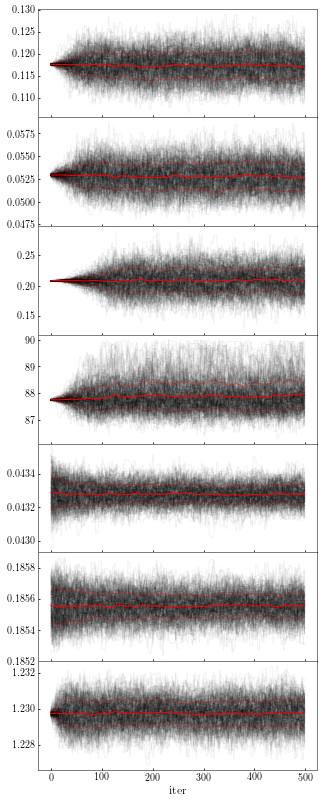

In [110]:
# lets see how the walkers are doing
plot_chain(sampler.flatchain,nwalkers)


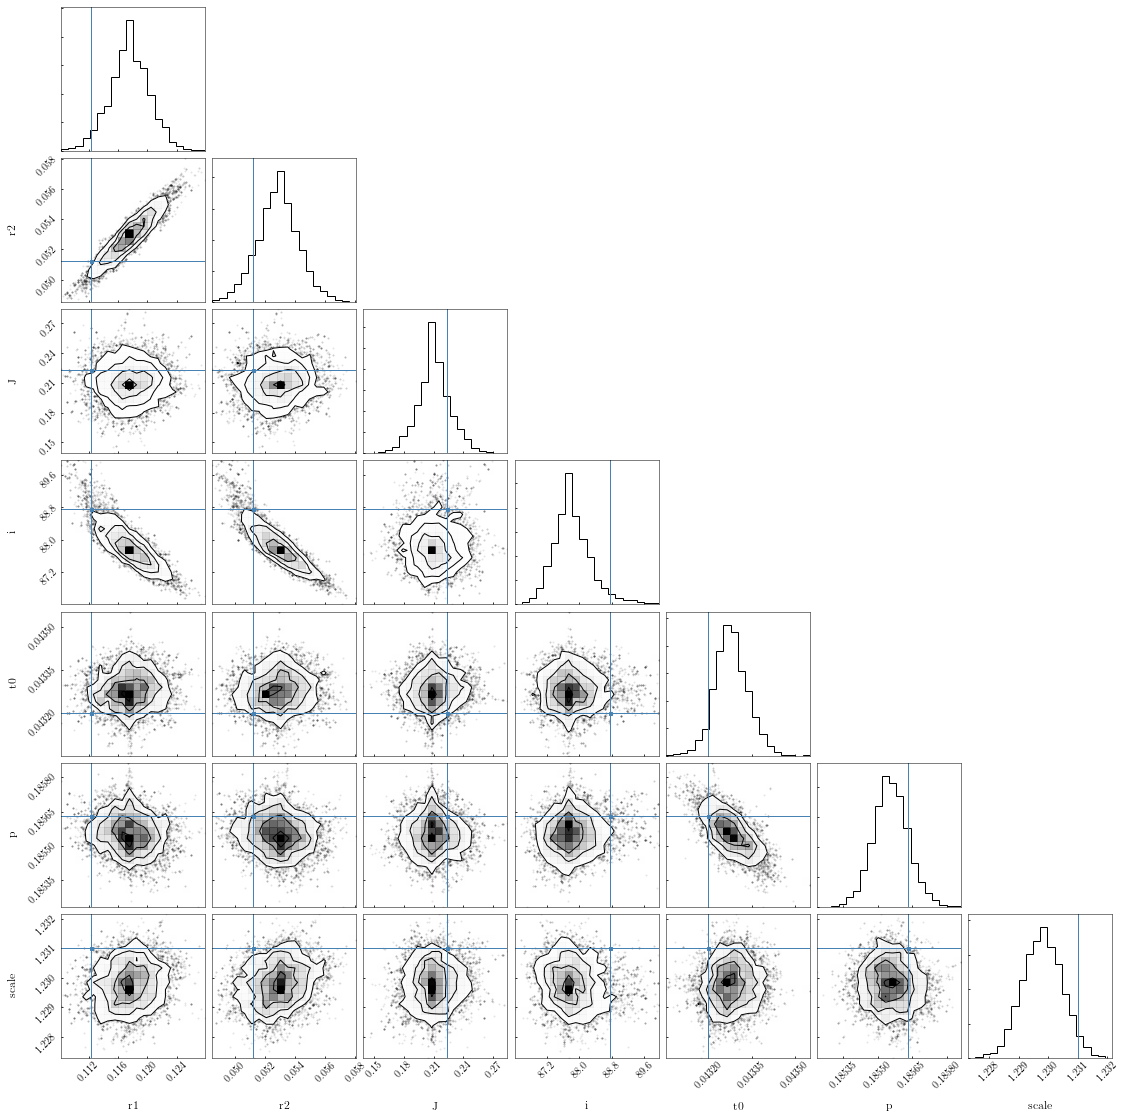

In [111]:
# now lets check the parameter uncertainties and correlations:

import corner
labels = 'r1 r2 J i t0 p scale'.split()
corner.corner(sampler.flatchain[-50*nwalkers:],labels=labels,truths=model_pars)
plt.show()
